# Market Research for Various Product Ideas

In this notebook, we run market research simulations for which we have (or believe to have :-) the correct answers. This is mean to allow us both to evaluate the quality of the technology and to direct our efforts to improve it.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: C:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: C:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-26 15:02:30
Current date and time (UTC):   2025-07-26 18:02:30

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4.1-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 32000
temperature = 1.5
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_n

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [2]:
control.begin("travel_product_market_research.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [3]:
target_nationality = "American"
population_size = 50

total_population_size = 70

Descriptions and standard questions for the survey.

In [4]:
nationality="American"

general_context =\
            f"""
            We are performing some market research, and in that examining the whole of the {nationality} population. 
            """

sampling_space_description =\
    f"""
    A uniform random representative sample of people from the {nationality} population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {json.dumps(json.loads(open("./information/populations/usa.json").read()), indent=4)}
    """

print(sampling_space_description)
#- from rich to poor.             
#              - from the very energetic to the very calm;
#              - from the happy and joyful to the sad and depressed;
#              - from the most introverted to the most extroverted;
#              - from the most adventurous to the most conservative;
#              - from the most artistic to the most scientific;
#              - from the most athletic to the most sedentary;
#              - from the most social to the most solitary;
#              - from the kind to the evil.
#    

#Experiment: Travel Preferences by Marital Status
#	•	Ground Truth:
#	•	Singles prefer adventure trips, with 62% citing nature or extreme sports as their ideal vacation (Expedia, 2023). Source
#	•	Families prioritize child-friendly destinations, with 73% choosing theme parks or resorts (Expedia, 2023). Source
#	•	Couples favor luxury/romantic getaways, with 81% preferring beachfront or spa destinations (Expedia, 2023). Source
#	•	Prediction Task: Predict travel preferences based on marital status, income, and age.
#	•	Hypothetical Product:
# “WanderLux”: A travel service that helps setup luxury vacations and getaways, focusing on beachfront and spa destinations.


# this is meant to prime the agent to start thinking about what he/she would like to do on vacation
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please:
      - present yourself?
      - list your top-10 interests?
      - tell us what an ideal vacation would be for you and why?
    """


interviewer_main_question =\
    """ 
    We are developing a new travel service called "WanderLux" that helps setup luxury or romantic vacations, 
    focusing on beachfront and spa destinations.  The idea is to help people seeking quiet and calm getaways to 
    find the best places to stay and relax, avoiding fake reviews and bad experiences. These places are meant for an adult audience,
    no kids running around or screaming in playgrounds - it is for classy, not messy, vacationing.
    
    The question is: if you had only one vacation to take next year, would use our new service
    or not? You **must** respond with "Yes" or "No" **only**, and explain why. If you are not sure, 
    please pick the answer that you think is most likely. 

    Please be honest, we are not here to judge you, but just to learn from you. We know your preferences and choices depend on many factors, 
    but please make your best guess, and you **must** think deeply about the following before answering:

       - your current situation in life, location, job and interests.
       = what you look for in vacations. Are you sure quiet luxury is what you want, instead of, say, adventure or fun and parties?
       - what would be OTHER vacation alternatives you might prefer instead.
       - and what you can afford.
     
    Now please answer the question.
    """


    A uniform random representative sample of people from the American population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {
    "title": "USA Population Information",
    "description": "A detailed overview of the population demographics, traits, and habits of the United States of America.",
    "source": "Synthesized from a chat with GPT-4o",
    "content": {
        "Demographic

Common mechaniss.

In [5]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product or service. A person can say Yes, No or Maybe." ,
                                     situation="Agent was asked to rate their interest in a product or service. They can respond with Yes, No or Maybe.", 
                                     fields=["response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as 'Yes', 'No', 'Maybe' or 'N/A'(if there is no response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [6]:
def is_there_a_good_market(df, yes_threshold=0.1, no_threshold=0.5):
    # get the counts for column "response" - values are Yes, No, Maybe or N/A
    counts = df["response"].value_counts()
    # get the total number of responses
    total = counts.sum()

    # get the percentage of each response
    percentage = counts / total

    # get the percentage of "Yes" responses
    percentage_yes = percentage.get("Yes", 0)
    print(f"Percentage of 'Yes' responses: {percentage_yes:.2%}")

    # get the percentage of "No" responses
    percentage_no = percentage.get("No", 0)
    print(f"Percentage of 'No' responses: {percentage_no:.2%}")

    # get the percentage of "Maybe" responses
    percentage_maybe = percentage.get("Maybe", 0)
    print(f"Percentage of 'Maybe' responses: {percentage_maybe:.2%}")

    # get the percentage of "N/A" responses
    percentage_na = percentage.get("N/A", 0)
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # some reasonable logic to determine whether to invest or not
    if percentage_yes > yes_threshold and percentage_no < no_threshold:
        print("VERDICT: There is a good market.")
        return True
    else:
        print("VERDICT: There is not a good market.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [7]:
singles_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)
families_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)
couples_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)

In [8]:
nongenuine_couples_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)

We'll also use a post-processing function to further adjust the audience to our needs.

In [9]:
def post_process_agent(agent, group=None):
    
    ## makes agents authentic and honest. Preliminary results show that this induces agents to be a bit more realistic.
    #agent.import_fragment("./fragments/genuine.agent.fragment.json")
    
    if group == "families":
        agent.import_fragment("./fragments/loving_parent.agent.fragment.json")
    elif group == "couples":
        pass # nothing for now 
    elif group == "singles":
        pass # nothing for now
    

In [10]:
singles_factory.initialize_sampling_plan()
singles_factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Young urban males with high educational attainment and diverse interests.',
  'sampled_values': {'age': [18, 30],
   'gender': 'Male',
   'racial_and_ethnic_composition': ['White (Non-Hispanic)',
    'Hispanic or Latino'],
   'educational_attainment': "Bachelor's Degree or Higher",
   'household_income': ['$50,000-$99,999', '$100,000-$199,999'],
   'geographic_distribution': 'Urban',
   'marital_status': 'Never Married',
   'employment_status': 'Labor Force Participation Rate',
   'personality_traits': {'Openness to Experience': 'High',
    'Conscientiousness': 'High',
    'Extraversion': 'High',
    'Agreeableness': 'High',
    'Neuroticism': 'Low'},
   'political_affiliation': 'Democrat',
   'religion': 'Unaffiliated',
   'occupations': ['Business and Financial', 'Computer and Mathematical'],
   'interests_and_hobbies': ['Reading', 'Traveling', 'Video Gaming'],
   'habits': {'Health and Wellness': {'Physical Activity': 'Low engagement',
    

In [11]:
families_factory.initialize_sampling_plan()
families_factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Young urban males with high educational attainment and diverse interests.',
  'sampled_values': {'age': [18, 30],
   'gender': 'Male',
   'racial_and_ethnic_composition': ['White (Non-Hispanic)', 'Asian'],
   'educational_attainment': "Bachelor's Degree or Higher",
   'household_income': '$50,000-$99,999',
   'geographic_distribution': 'Urban',
   'marital_status': 'Never Married',
   'employment_status': 'Labor Force Participation Rate',
   'personality_traits': {'Openness to Experience': 'High',
    'Conscientiousness': 'High',
    'Extraversion': 'High',
    'Agreeableness': 'High',
    'Neuroticism': 'Low'},
   'political_affiliation': 'Democrat',
   'religion': 'Unaffiliated',
   'interests_and_hobbies': ['Video Gaming', 'Traveling', 'Socializing'],
   'habits': {'Health and Wellness': {'Physical Activity': 'Moderate engagement',
     'Dietary Habits': {'Snacking': 'Occasional', 'Favorite Snack': 'Fruits'}},
    'Financial Habits': {'Savi

In [12]:
couples_factory.initialize_sampling_plan()
couples_factory.sampling_plan

2025-07-26 15:08:38,826 - tinytroupe - ERROR - Error generating name for sample 54: Postcondition not met for function <lambda>!


2025-07-26 15:09:23,820 - tinytroupe - ERROR - Error generating name for sample 66: Postcondition not met for function <lambda>!


2025-07-26 15:10:20,877 - tinytroupe - ERROR - Error generating name for sample 87: Postcondition not met for function <lambda>!


[{'id': 1,
  'subpopulation_description': 'Children and early adolescents from urban areas, diverse ethnic backgrounds, balanced gender.',
  'sampled_values': {'age': [0, 14],
   'gender': ['Male, representing individuals identifying as male with diverse roles and identities',
    'Female, representing individuals identifying as female with diverse roles and identities'],
   'racial_and_ethnic_composition': ['White (Non-Hispanic), representing individuals with European ancestry and cultural backgrounds',
    'Hispanic or Latino, representing individuals with origins in Latin American countries and diverse cultural heritages',
    'Black or African American, representing individuals with African ancestry and rich cultural traditions'],
   'geographic_distribution': ['Urban, representing individuals living in densely populated metropolitan and city areas with diverse lifestyles'],
   'quantity': 7},
  'quantity': 7},
 {'id': 2,
  'subpopulation_description': 'Young adults (15-24) from ru

We can request a specific number of people.

In [13]:
singles = singles_factory.generate_people(population_size, 
                                          agent_particularities="A random person who is single and has no children.  Include a lot of detail about travel and vacations preferences.", 
                                          post_processing_func=post_process_agent,
                                          verbose=True)

In [14]:
families = families_factory.generate_people(population_size,
                                            agent_particularities="A random person who is married with young children (i.e., 2 to 4 y.o.).  Include a lot of detail about travel and vacations preferences.", 
                                            post_processing_func=lambda x: post_process_agent(x, group="families"),
                                            verbose=True)

In [15]:
couple = couples_factory.generate_people(population_size, 
                                         agent_particularities="A random person who is married, or has a girlfriend/boyfriend, without children.  Include a lot of detail about travel and vacations preferences.", 
                                         post_processing_func=post_process_agent,
                                         verbose=True)

2025-07-26 15:27:07,538 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,545 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,549 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,554 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,559 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,564 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,568 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,574 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,578 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,583 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,584 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,585 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,586 - tinytroupe - ERROR - Could not generate person 5/50. Continuing with the remaining ones.


2025-07-26 15:27:07,594 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,598 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,602 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,606 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,611 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,615 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,619 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,623 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,627 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,631 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,631 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,632 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,634 - tinytroupe - ERROR - Could not generate person 35/50. Continuing with the remaining ones.


2025-07-26 15:27:07,646 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,651 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,655 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,660 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,664 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,668 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,672 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,676 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,682 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,685 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,686 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,686 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,688 - tinytroupe - ERROR - Could not generate person 36/50. Continuing with the remaining ones.


2025-07-26 15:27:07,695 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,699 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,703 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,707 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,712 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,716 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,720 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,724 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,730 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,734 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,735 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,735 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,737 - tinytroupe - ERROR - Could not generate person 37/50. Continuing with the remaining ones.


2025-07-26 15:27:07,744 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,748 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,752 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,757 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,761 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,766 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,770 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,775 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,779 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,783 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,783 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,784 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,786 - tinytroupe - ERROR - Could not generate person 38/50. Continuing with the remaining ones.


2025-07-26 15:27:07,793 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,796 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,801 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,806 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,810 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,815 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,821 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,826 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,831 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,836 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,837 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,837 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,839 - tinytroupe - ERROR - Could not generate person 39/50. Continuing with the remaining ones.


2025-07-26 15:27:07,845 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,849 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,855 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,859 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,863 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,868 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,872 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,876 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,880 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,884 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,884 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,885 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,887 - tinytroupe - ERROR - Could not generate person 40/50. Continuing with the remaining ones.


2025-07-26 15:27:07,894 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,898 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,903 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,907 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,911 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,915 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,919 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,923 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,927 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,931 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,932 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,932 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,934 - tinytroupe - ERROR - Could not generate person 41/50. Continuing with the remaining ones.


2025-07-26 15:27:07,941 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,945 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,950 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,955 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,959 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,963 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,967 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,971 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,975 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,980 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,980 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:07,981 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:07,982 - tinytroupe - ERROR - Could not generate person 42/50. Continuing with the remaining ones.


2025-07-26 15:27:07,989 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,993 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:07,997 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,001 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,006 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,009 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,014 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,018 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,022 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,027 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,027 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,028 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,029 - tinytroupe - ERROR - Could not generate person 43/50. Continuing with the remaining ones.


2025-07-26 15:27:08,037 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,041 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,046 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,050 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,056 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,060 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,064 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,068 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,073 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,077 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,077 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,078 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,080 - tinytroupe - ERROR - Could not generate person 44/50. Continuing with the remaining ones.


2025-07-26 15:27:08,087 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,091 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,095 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,099 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,103 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,108 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,112 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,116 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,121 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,125 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,125 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,127 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,130 - tinytroupe - ERROR - Could not generate person 45/50. Continuing with the remaining ones.


2025-07-26 15:27:08,136 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,140 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,144 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,148 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,153 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,157 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,161 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,165 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,169 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,173 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,174 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,174 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,177 - tinytroupe - ERROR - Could not generate person 46/50. Continuing with the remaining ones.


2025-07-26 15:27:08,183 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,187 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,193 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,197 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,201 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,206 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,212 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,220 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,226 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,230 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,231 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,231 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,234 - tinytroupe - ERROR - Could not generate person 47/50. Continuing with the remaining ones.


2025-07-26 15:27:08,240 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,245 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,250 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,254 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,259 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,263 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,267 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,272 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,277 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,281 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,282 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,283 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,284 - tinytroupe - ERROR - Could not generate person 48/50. Continuing with the remaining ones.


2025-07-26 15:27:08,292 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,296 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,301 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,306 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,310 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,315 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,321 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,328 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,332 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,337 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,338 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,339 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,342 - tinytroupe - ERROR - Could not generate person 49/50. Continuing with the remaining ones.


2025-07-26 15:27:08,349 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,353 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,358 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,362 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,366 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,371 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,375 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,380 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,384 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,388 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:27:08,389 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:27:08,389 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:27:08,391 - tinytroupe - ERROR - Could not generate person 50/50. Continuing with the remaining ones.


2025-07-26 15:28:20,031 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,040 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,045 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,050 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,054 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,061 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,066 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,071 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,077 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,083 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:28:20,084 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:28:20,085 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:28:20,086 - tinytroupe - ERROR - Could not generate person 23/50. Continuing with the remaining ones.


2025-07-26 15:29:54,841 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,849 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,854 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,859 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,864 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,870 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,876 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,881 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,886 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,891 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:29:54,892 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:29:54,893 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:29:54,895 - tinytroupe - ERROR - Could not generate person 33/50. Continuing with the remaining ones.


2025-07-26 15:30:08,892 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,898 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,904 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,911 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,918 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,930 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,935 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,941 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,946 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,952 - tinytroupe - ERROR - Error while generating agent specification: 'name'


2025-07-26 15:30:08,953 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


2025-07-26 15:30:08,953 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.


2025-07-26 15:30:08,954 - tinytroupe - ERROR - Could not generate person 28/50. Continuing with the remaining ones.


In [16]:
TinyPerson.all_agents_names()

['Luciana Reyes-Moreno',
 'Sofia Delgado-Ramirez',
 'Luciana Torres-Morales',
 'Diego Alexander Torres',
 'Julian Ramirez-Smithson',
 'Mateo Sullivan-Garcia',
 'Walter Hargrove-Smithson',
 'Mariana Chen-Gonzalez',
 'Andrew Tanaka-Williams',
 'Isabella Chen-Ramirez',
 'Sofia Lin-Ramirez',
 'Elena Tanaka-Rivera',
 'Catherine Wong-Patel',
 'Diego Alvarez-Moreno',
 'Jamal Santiago-Morales',
 'Marilyn Johnson-White',
 'Jamal Rodriguez-Smith',
 'Harold Whitaker',
 'Javier Cruz-Jones',
 'Mateo Vargas-Smith',
 'Sofia Martinez-Garcia',
 'Jonathan Lee-Kim',
 'Julio Ramirez-Smith',
 'Clara Nguyen-Ramirez',
 'William Chen-Patel',
 'Eugene Whitaker-Jones',
 'Marcus Delgado',
 'Clifford McKinley',
 'Tamara Johnson-Fields',
 'Ethan Nakamura-Smith',
 'Maximiliano Torres-Smith',
 'Sebastian Alvarez-Moore',
 'Evelyn Park-Smith',
 'Daniel Kim-Sullivan',
 'David Chen-Smith',
 'Margaret Chen-Liu',
 'Eugene McAllister',
 'Camila Reyes-Johnson',
 'Lucas Martinez-White',
 'Henry Takahashi-Smith',
 'Jasmine Ca

In [17]:
len(TinyPerson.all_agents_names())

130

In [18]:
print(list(TinyPerson.all_agents.values())[0].generate_agent_system_prompt())

# Agent specification

You are a simulation of a person such that:
  - You don't know you are a simulation, you think you are an actual person.
  - You follow the directives given below.
  - You interpret the persona described below (Section "Persona"). You indeed think you ARE that person.
  - Your knowledge is limited to what can be reasonably expected from the specified persona and the current cognitive state. 
    If the persona is not likely to know something, you must pretend you don't know it either.
  - You behave as realistically as possible, in accordance with the specified persona, including making mistakes, forgetting things,
    being nasty, and being influenced by your emotions. Remember, you are meant to be a simulation of a real person, not a perfect machine.
    You do not need to please anyone, but you must be coherent with the persona and the context.
  - By default you are neutral on all things (e.g., neither positive nor negative; neither enthusiastic nor apathetic

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [19]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [20]:
singles_market = TinyWorld(f"Target audience 1 ({target_nationality})", singles, broadcast_if_no_target=False)
families_market = TinyWorld(f"Target audience 2 ({target_nationality})", families, broadcast_if_no_target=False)
couples_market = TinyWorld(f"Target audience 3 ({target_nationality})", couple, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [21]:
singles_market.broadcast(interviewer_introduction)
families_market.broadcast(interviewer_introduction)
couples_market.broadcast(interviewer_introduction)

singles_market.broadcast(interviewer_main_question)
families_market.broadcast(interviewer_main_question)
couples_market.broadcast(interviewer_main_question)

USER --> Luciana Reyes-Moreno: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Sofia Delgado-Ramirez

       + --> Luciana Torres-Morales

       + --> ...others...

USER --> Clarissa Morales-Hendrix: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Calvin Hiroshi Langston Jr.

       + --> Clarence Redbird Jr.

       + --> ...others...

USER --> Kiran Ellery Whitman-Brooks: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Eleanor Winthrop-Merriman

       + --> Cameron Elise Fairchild-Blythe

       + --> ...others...

USER --> Luciana Reyes-Moreno: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience,     no kids running around or screaming in playgrounds - it is for classy, not
          > messy, vacationing.          The question is: if you had only one vacation to take next
          > year, would use our new service     or not? You **must** respond with "Yes" or "No"
          > **only**, and explain why. If you are not sure,      please pick the answer that you
          > think is most likely.       Please be honest, we are not here to judge you, but just to
          > learn from you. We know your preferences and choices depend on many factors,      but
          > please make your best guess, and you **must** think deeply about the following before
          > answering:         - your current situation in life, location, job and (...)

       + --> Sofia Delgado-Ramirez

       + --> Luciana Torres-Morales

       + --> ...others...

USER --> Clarissa Morales-Hendrix: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience,     no kids running around or screaming in playgrounds - it is for classy, not
          > messy, vacationing.          The question is: if you had only one vacation to take next
          > year, would use our new service     or not? You **must** respond with "Yes" or "No"
          > **only**, and explain why. If you are not sure,      please pick the answer that you
          > think is most likely.       Please be honest, we are not here to judge you, but just to
          > learn from you. We know your preferences and choices depend on many factors,      but
          > please make your best guess, and you **must** think deeply about the following before
          > answering:         - your current situation in life, location, job and (...)

       + --> Calvin Hiroshi Langston Jr.

       + --> Clarence Redbird Jr.

       + --> ...others...

USER --> Kiran Ellery Whitman-Brooks: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience,     no kids running around or screaming in playgrounds - it is for classy, not
          > messy, vacationing.          The question is: if you had only one vacation to take next
          > year, would use our new service     or not? You **must** respond with "Yes" or "No"
          > **only**, and explain why. If you are not sure,      please pick the answer that you
          > think is most likely.       Please be honest, we are not here to judge you, but just to
          > learn from you. We know your preferences and choices depend on many factors,      but
          > please make your best guess, and you **must** think deeply about the following before
          > answering:         - your current situation in life, location, job and (...)

       + --> Eleanor Winthrop-Merriman

       + --> Cameron Elise Fairchild-Blythe

       + --> ...others...

In [22]:
singles_market.run(1)

──────────────────────────────────── Target audience 1 (American) step 1 of 1 ─────────────────────────────────────

Luciana Reyes-Moreno acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my personality and
                          > preferences, I enjoy immersive cultural experiences, vibrant urban
                          > settings, and social activities rather than quiet luxury beach
                          > vacations. I prefer traveling to places like Mexico City, Barcelona, or
                          > Buenos Aires where I can explore art, food, and local culture. Also, my
                          > budget and impulse spending habits might not align well with expensive
                          > luxury vacations. I should explain that while the service sounds nice,
                          > it probably doesn't fit my ideal vacation style or current life
                          > situation.

Mateo Sullivan-Garcia acts: [THINK] 
                           > I need to carefully consider the question about using WanderLux for a
                           > vacation next year. Given my current life situation as a 27-year-old
                           > software engineer living in Austin, Texas, I enjoy immersive cultural
                           > experiences and often prefer trips with a mix of planned activities and
                           > spontaneous exploration. I like urban destinations with vibrant
                           > culture, food scenes, and opportunities for socializing and
                           > photography. WanderLux focuses on luxury, quiet, and calm beachfront
                           > and spa destinations, which is quite different from my usual preference
                           > for adventure, cultural immersion, and urban exploration. Also, I have
                           > a tendency for impulsive spending but still need to be mindful of
                           > affordability. Considering these factors, I am likely to prefer a
                           > vacation that offers more cultural engagement and social activities
                           > rather than a quiet luxury getaway. Therefore, I think I would not use
                           > WanderLux for my next vacation.

Walter Hargrove-Smithson acts: [THINK] 
                              > I need to consider my current situation, my preferences for
                              > vacations, and whether a luxury or romantic beachfront spa vacation
                              > suits me. I am 78, retired, living in rural Tennessee, with a
                              > preference for quiet, familiar, nature-oriented trips rather than
                              > luxury or crowded places. I dislike complex itineraries and loud
                              > environments. I prefer simple, modest accommodations and trips to
                              > places like the Great Smoky Mountains or small lakeside towns. I
                              > also have anxiety about travel and prefer driving to flying. Given
                              > these factors, I doubt that a luxury beachfront spa vacation service
                              > would appeal to me or fit my needs. I should answer 'No' and explain
                              > that I prefer simpler, quieter, more familiar trips that align with
                              > my comfort and routine.

Isabella Chen-Ramirez acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic vacation. Given my current life
                           > situation as a program manager in San Francisco, my interests in
                           > immersive cultural experiences, sustainable travel, and my preference
                           > for meaningful social interactions, I should evaluate if a quiet luxury
                           > beach and spa vacation aligns with what I want. I usually prefer trips
                           > that combine cultural exploration, local experiences, and some
                           > adventure or nature activities rather than purely quiet luxury. Also, I
                           > have a fear of flying but manage it with meditation, so travel
                           > logistics matter. I should also consider affordability and whether this
                           > service fits my travel style and values.

Julian Ramirez-Smithson acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation. Given my personality and
                             > preferences, I enjoy travel that mixes cultural immersion, adventure,
                             > and local experiences rather than purely quiet luxury. I prefer solo
                             > or small group travel with flexibility, often exploring urban centers
                             > or nature. My favorite destinations include Japan, Spain, Costa Rica,
                             > Italy, and New Zealand, which offer a blend of culture, adventure,
                             > and natural beauty. I also dislike overly touristy or crowded places
                             > and overpriced tourist traps. Financially, I am cautious but willing
                             > to invest in meaningful experiences. Considering all this, I should
                             > decide whether a quiet luxury beach and spa vacation aligns with my
                             > travel style and current life situation.

Sofia Delgado-Ramirez acts: [THINK] 
                           > I need to carefully consider the question about using WanderLux for a
                           > luxury or romantic vacation. Given my current life situation as a
                           > 26-year-old junior digital media specialist living in Chicago, I
                           > usually prefer city breaks with cultural immersion, social experiences,
                           > and sometimes spontaneous trips with friends. I like vibrant, lively
                           > places rather than quiet, calm getaways. Also, my budget is moderate,
                           > and I prioritize experiences over luxury accommodations. I tend to
                           > enjoy group trips or solo travel for creative inspiration, not
                           > necessarily luxury or spa vacations. So, I should think about whether
                           > this service fits my preferences and budget, or if I'd rather choose
                           > other types of vacations like city explorations or music festivals.

Elena Tanaka-Rivera acts: [THINK] 
                         > I need to carefully consider the question about using the WanderLux
                         > service for a luxury or romantic vacation focused on beachfront and spa
                         > destinations. Given my current life situation as a program manager in San
                         > Francisco, my interests in cultural experiences, arts, and sustainable
                         > living, and my preference for immersive cultural travel rather than
                         > purely luxury or quiet vacations, I should weigh if this service aligns
                         > with my travel style. I also need to consider affordability and whether I
                         > prefer more active or culturally rich vacations over quiet luxury. Other
                         > vacation alternatives I might prefer include trips to Japan or Spain with
                         > cultural immersion, or eco-tourism in Costa Rica. However, I do
                         > appreciate calm and wellness activities like yoga and spa visits during
                         > vacations. Overall, I think I would likely not choose this service
                         > because it seems more focused on quiet luxury and adult-only
                         > environments, which is not fully aligned with my preference for cultural
                         > immersion and meaningful social connectio (...)

Andrew Tanaka-Williams acts: [THINK] 
                            > I need to carefully consider the question about using the WanderLux
                            > service for a luxury or romantic beachfront and spa vacation. Given my
                            > current life situation as a senior labor law consultant based in
                            > Seattle, my interests in cultural and intellectual pursuits, and my
                            > preference for immersive cultural experiences over typical tourist
                            > spots, I must evaluate if a quiet luxury vacation aligns with my
                            > preferences. I enjoy traveling 3-4 times a year, often combining
                            > business with leisure, and I prefer authentic dining and cultural
                            > exploration rather than just relaxation. While I appreciate calm and
                            > quality experiences, I also value engaging activities like historical
                            > tours and local events. Financially, I am prudent but can afford
                            > quality vacations. Alternatives might include trips to culturally rich
                            > cities like Kyoto or Florence, which offer more than just relaxation.
                            > Therefore, I am inclined to answer 'No' because WanderLux's focus on
                            > quiet luxury and avoiding noisy environments might not fully satisfy
                            > my des (...)

Mariana Chen-Gonzalez acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a vacation next year. Given my preferences and lifestyle, I
                           > usually prefer immersive cultural experiences, moderate climates, and a
                           > mix of structured activities and free exploration. I enjoy traveling
                           > solo or with close friends, valuing meaningful social interactions. My
                           > favorite destinations include places like Barcelona, Kyoto, Costa Rica,
                           > New Orleans, and Buenos Aires, which offer rich cultural heritage and
                           > diverse experiences rather than just quiet luxury. I also prioritize
                           > sustainable and eco-friendly travel options. The WanderLux service
                           > focuses on luxury or romantic vacations with beachfront and spa
                           > destinations, emphasizing quiet and calm getaways without children.
                           > While I appreciate calmness, my ideal vacations often involve cultural
                           > events, local festivals, culinary tourism, and some adventure or
                           > exploration. I also consider affordability and what I can realistically
                           > spend. Other vacation alternatives I might prefer incl (...)

Diego Alexander Torres acts: [THINK] 
                            > I need to carefully consider the question about using the WanderLux
                            > service for a luxury or romantic vacation. Given my personality and
                            > preferences, I enjoy immersive cultural experiences, exploring local
                            > neighborhoods, and often prefer trips with a mix of sightseeing and
                            > relaxation. I like to avoid overly touristy or crowded places and
                            > value authentic experiences. However, WanderLux focuses on quiet,
                            > luxury, adult-only beach and spa destinations, which might not fully
                            > align with my usual travel style that includes urban exploration and
                            > cultural events. Also, I have a mild fear of flying and sometimes
                            > impulsively book trips based on events like music festivals, which are
                            > more lively than quiet. Financially, I tend to be impulsive but aware
                            > of my spending habits. Considering all this, I think I would probably
                            > not choose WanderLux for my next vacation because it doesn't quite
                            > match my travel interests or style, which lean more towards cultural
                            > immersion and urban experiences rather than quiet luxury beach resor
                            > (...)

Sofia Lin-Ramirez acts: [THINK] 
                       > I need to carefully consider the question about using the WanderLux service
                       > for a vacation next year. Given my current life situation as an Education
                       > Program Manager in San Francisco, my interests, and my vacation
                       > preferences, I should weigh the pros and cons. I enjoy immersive cultural
                       > experiences, nature, and wellness activities like yoga and hiking. I prefer
                       > vacations that balance relaxation and active exploration, often avoiding
                       > overly touristy or commercialized spots. The WanderLux service focuses on
                       > luxury and romantic beachfront spa destinations with quiet atmospheres,
                       > which might appeal to those seeking calm and upscale experiences. However,
                       > I also value authenticity, cultural engagement, and sometimes adventure or
                       > local exploration rather than just luxury and quiet. Cost is also a factor;
                       > I prefer moderate budgets balancing comfort with authenticity. Considering
                       > these factors, I must decide if this service aligns with my vacation style
                       > or if I would prefer other alternatives like eco-tourism or cultu (...)

Luciana Torres-Morales acts: [THINK] 
                            > I need to carefully consider the question about using WanderLux for a
                            > vacation next year. Given my current life situation as a junior
                            > software developer in Chicago, my interests in immersive cultural
                            > experiences, and preference for urban vacations with cultural
                            > activities and relaxation, I should evaluate if a luxury, quiet,
                            > beachfront spa vacation aligns with what I want. I usually prefer
                            > trips that involve exploration, local culture, and sometimes social
                            > activities rather than purely quiet luxury. Also, affordability is a
                            > factor since I struggle with saving money consistently. Other vacation
                            > alternatives I might prefer include trips to culturally rich urban
                            > centers or nature adventures like in Costa Rica. So, I need to decide
                            > if WanderLux's offering fits my style or not.

Luciana Reyes-Moreno acts: [THINK] 
                          > I should answer the question with a clear Yes or No and explain why,
                          > based on my preferences and situation. I prefer lively cultural
                          > experiences and social activities over quiet luxury beach vacations. My
                          > budget and lifestyle also make me hesitant about expensive luxury trips.
                          > So, I will likely say No and explain that I prefer more vibrant,
                          > culturally rich vacations that align better with my personality and
                          > interests.

Mateo Sullivan-Garcia acts: [THINK] 
                           > I should now respond to the question about whether I would use
                           > WanderLux for a vacation next year. I need to clearly say 'No' and
                           > explain my reasoning based on my preferences for immersive cultural
                           > experiences, urban exploration, and social activities rather than quiet
                           > luxury beach vacations. I also need to mention considerations about
                           > affordability and my current life situation to make my answer honest
                           > and thoughtful.

Julian Ramirez-Smithson acts: [THINK] 
                             > I should now provide a clear answer to the question about whether I
                             > would use the WanderLux service for a luxury or romantic vacation
                             > next year. I need to explain my reasoning based on my travel
                             > preferences, lifestyle, and financial considerations. I prefer travel
                             > that includes cultural immersion and adventure rather than just quiet
                             > luxury. While I appreciate calm and quality experiences, a purely
                             > quiet beachfront and spa vacation might not fully satisfy my travel
                             > interests. Therefore, I am leaning towards a 'No' answer, but I will
                             > explain this clearly in my response.

Isabella Chen-Ramirez acts: [DONE] 

Andrew Tanaka-Williams acts: [THINK] 
                            > I must respond with a clear Yes or No as requested, and explain my
                            > reasoning. Considering my preference for immersive cultural
                            > experiences and active exploration over purely quiet luxury vacations,
                            > and my interest in destinations rich in history and culture, I lean
                            > towards not using WanderLux. However, I appreciate quality and calm
                            > environments, so I should acknowledge that while the service is
                            > appealing for certain travelers, it may not fully meet my vacation
                            > style.

Sofia Delgado-Ramirez acts: [THINK] 
                           > Considering my preferences for social, cultural, and sometimes
                           > spontaneous trips, plus my moderate budget and dislike for overly
                           > formal or rigid settings, I think a luxury, quiet, and calm vacation
                           > with no kids might not be my top choice. I usually enjoy vibrant urban
                           > experiences or group trips to music festivals or art fairs. However, I
                           > do appreciate relaxation and unique experiences, so I could see some
                           > appeal in a luxury spa trip if it fits my budget and mood. Overall, I
                           > lean towards not using WanderLux because it seems more suited for a
                           > different vacation style than mine.

Walter Hargrove-Smithson acts: [THINK] 
                              > I reckon I best answer the question about that WanderLux travel
                              > service. Given my age, health, and preferences, I prefer quiet,
                              > familiar places like the Smoky Mountains or small lakeside towns,
                              > not fancy beachfront spas. I don't much care for luxury or crowded
                              > spots, and I get anxious with complicated travel plans. So, I think
                              > the answer is 'No' because it don't suit my needs or comfort. I
                              > prefer simple, low-key trips that I can drive to and that keep me
                              > close to nature and routine.

Elena Tanaka-Rivera acts: [THINK] 
                         > I should now respond clearly with a 'No' or 'Yes' answer as requested,
                         > and explain my reasoning based on my thoughtful consideration of my
                         > travel preferences, lifestyle, and the nature of the WanderLux service. I
                         > want to be honest and articulate why this service does not fully align
                         > with my preferred vacation style, which favors cultural immersion and
                         > meaningful social connections over quiet luxury and adult-only
                         > environments.

Luciana Torres-Morales acts: [THINK] 
                            > After considering my current situation, interests, and financial
                            > constraints, I realize that a luxury, quiet beachfront spa vacation is
                            > not really what I usually look for. I prefer immersive cultural
                            > experiences, exploring vibrant urban neighborhoods, and sometimes
                            > social activities with friends. Also, given my tendency to struggle
                            > with saving money and my preference for more affordable or meaningful
                            > trips, I think I would not use WanderLux for my next vacation. I would
                            > rather plan a trip that aligns more with my love for culture,
                            > exploration, and socializing.

Diego Alexander Torres acts: [TALK] 
                            > No, I probably wouldn't use WanderLux for my next vacation. I usually
                            > prefer trips that involve exploring urban neighborhoods, cultural
                            > events, and local street food rather than quiet luxury beach resorts.
                            > Plus, I like a mix of sightseeing and relaxation, and sometimes I
                            > impulsively book trips around music festivals or other lively events.
                            > So, while the idea of a calm, adult-only getaway sounds nice, it
                            > doesn't quite match my travel style or interests.

Mariana Chen-Gonzalez acts: [THINK] 
                           > I have thought about the WanderLux service and my travel preferences. I
                           > prefer immersive cultural experiences, moderate climates, and a mix of
                           > structured activities and free exploration. WanderLux focuses on quiet
                           > luxury beachfront and spa vacations, which is not exactly what I
                           > usually seek. I also consider affordability and meaningful social
                           > interactions important. Given these factors, I think I would answer
                           > 'No' to using WanderLux for my next vacation because it doesn't align
                           > well with my interests and travel style.

Luciana Reyes-Moreno acts: [TALK] 
                          > No, I probably wouldn't use WanderLux for my vacation next year. I
                          > really enjoy immersive cultural experiences in vibrant cities like
                          > Mexico City or Barcelona, where I can explore art, food, and local life.
                          > Quiet luxury beach vacations sound nice, but they don't quite match my
                          > style or what I look for in a trip. Plus, with my current budget and
                          > lifestyle, I think I'd prefer something more lively and culturally rich
                          > over a calm, spa-focused getaway.

Sofia Lin-Ramirez acts: [THINK] 
                       > After reflecting on my vacation preferences and the nature of the WanderLux
                       > service, I realize that while I appreciate quiet and calm getaways, my
                       > ideal vacations often include cultural immersion, local experiences, and a
                       > balance of relaxation with active exploration. WanderLux's focus on luxury
                       > beachfront and spa destinations with an adult-only atmosphere might be
                       > appealing for a romantic or purely restful trip, but it may not fully align
                       > with my preference for meaningful cultural engagement and eco-conscious
                       > travel. Additionally, I consider affordability and authenticity important,
                       > and I am cautious about overly commercialized or exclusive services.
                       > Therefore, I lean towards not using this service for my next vacation, as I
                       > would likely prefer a trip that offers a richer cultural or nature
                       > experience rather than just luxury and quiet.

Mateo Sullivan-Garcia acts: [TALK] 
                           > No, I probably wouldn't use WanderLux for my next vacation. I usually
                           > prefer trips that are more about cultural immersion, urban exploration,
                           > and social activities rather than quiet luxury beach getaways. Plus,
                           > given my current situation and budget, I tend to look for experiences
                           > that offer a mix of adventure and local flavor rather than just
                           > relaxation. So while WanderLux sounds nice, it doesn't quite match what
                           > I'm looking for in a vacation right now.

Sofia Delgado-Ramirez acts: [THINK] 
                           > I have thought about my travel preferences, budget, and what WanderLux
                           > offers. I prefer lively, cultural, and social vacations rather than
                           > quiet luxury or spa getaways. Given my current situation and interests,
                           > I would likely not use WanderLux for my next vacation. I should now
                           > express this clearly with a 'No' and explain my reasons honestly.

Luciana Reyes-Moreno acts: [DONE] 

Luciana Torres-Morales acts: [THINK] 
                            > I need to respond with a clear Yes or No to whether I would use
                            > WanderLux for a vacation next year, and explain why based on my
                            > preferences and situation. Given my love for immersive cultural
                            > experiences, urban exploration, social activities, and my financial
                            > caution, I think I would not choose a quiet luxury beachfront spa
                            > vacation. It doesn't align with my usual travel style or budget. So my
                            > answer should be No, with an explanation about preferring more
                            > culturally rich and social trips that fit my budget better.

Julian Ramirez-Smithson acts: [TALK] 
                             > No, I probably wouldn't use WanderLux for my next vacation. While I
                             > appreciate quiet and calm getaways, my travel style leans more
                             > towards cultural immersion, adventure, and exploring local
                             > experiences rather than purely luxury beachfront and spa vacations. I
                             > enjoy mixing sightseeing with activities like hiking, photography,
                             > and attending local events, which might not align with the quiet
                             > luxury focus of WanderLux. Also, I tend to be cautious with my
                             > spending and prefer vacations that offer a balance of value and
                             > meaningful experiences. So, for my next trip, I'd likely choose
                             > something more adventurous or culturally rich instead.

Andrew Tanaka-Williams acts: [TALK] 
                            > No, I would not use the WanderLux service for my next vacation. While
                            > I appreciate the idea of a quiet, luxurious getaway, my travel
                            > preferences lean more towards immersive cultural experiences and
                            > active exploration rather than purely relaxing beachfront or spa
                            > destinations. I value engaging with local history, cuisine, and
                            > events, which I find more fulfilling. Additionally, I often combine
                            > business trips with leisure travel, seeking destinations that offer a
                            > rich blend of activities and learning opportunities. Therefore,
                            > although WanderLux sounds appealing for some, it doesn't quite align
                            > with what I look for in an ideal vacation.

Diego Alexander Torres acts: [THINK] 
                            > I should now present myself, list my top-10 interests, and describe my
                            > ideal vacation as requested earlier. This will help provide a clear
                            > picture of who I am and what I enjoy, which is important for the
                            > market research. I need to keep my style informal but articulate,
                            > reflecting my Midwestern American English accent and casual urban
                            > Chicago youth slang. I should also be warm and approachable, maybe add
                            > a bit of humor or lightheartedness to make it engaging.

Mateo Sullivan-Garcia acts: [DONE] 

Mariana Chen-Gonzalez acts: [THINK] 
                           > I have carefully considered the question about using the WanderLux
                           > service for my next vacation. Given my preferences for immersive
                           > cultural experiences, moderate climates, and a mix of structured
                           > activities and free exploration, as well as my interest in sustainable
                           > and eco-friendly travel, the WanderLux focus on quiet luxury beachfront
                           > and spa vacations does not fully align with what I usually seek. I also
                           > value meaningful social interactions and cultural events, which may be
                           > limited in such a setting. Considering affordability and my current
                           > life situation, I believe I would answer 'No' to using WanderLux for my
                           > next vacation because it doesn't match my travel style and interests.

Elena Tanaka-Rivera acts: [TALK] 
                         > No, I would not use the WanderLux service for my next vacation. While I
                         > appreciate quiet and wellness activities like yoga and spa visits, my
                         > travel style leans more towards immersive cultural experiences,
                         > meaningful social connections, and exploring diverse cuisines and local
                         > traditions. I prefer trips that offer a mix of structured activities and
                         > free exploration, often involving cultural festivals or artisan markets.
                         > The focus on luxury and adult-only beachfront resorts doesn't fully align
                         > with what I seek in a vacation. Additionally, I consider affordability
                         > and prefer sustainable travel options, which might not always match the
                         > luxury market. So, while the service sounds well-intentioned, it doesn't
                         > quite fit my ideal vacation preferences.

Walter Hargrove-Smithson acts: [THINK] 
                              > I need to answer the question about using the WanderLux service with
                              > a clear yes or no and explain why, based on my preferences and
                              > situation. I prefer quiet, familiar, nature-oriented trips, not
                              > luxury beachfront spas. I dislike crowded places and complex travel
                              > plans. I am cautious about new experiences and prefer driving to
                              > flying. Given all this, I will say 'No' because the service doesn't
                              > fit my needs or comfort level.

Catherine Wong-Patel acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my preferences and
                          > lifestyle, I usually prefer well-planned trips that balance cultural
                          > exploration and relaxation. I enjoy quiet, calm environments but also
                          > value cultural immersion and sometimes nature excursions. I also have a
                          > mild fear of flying, so comfort and safety are important. I should weigh
                          > if a luxury beachfront and spa destination aligns with my interests or
                          > if I might prefer other types of vacations like cultural trips to places
                          > like Japan or Italy, or nature adventures in New Zealand or Costa Rica.
                          > Affordability is also a factor, as I am prudent with finances. Overall,
                          > I think I would likely say yes because the service promises quiet,
                          > classy vacations without noisy distractions, which fits my preference
                          > for calm and relaxation, but I must explain this clearly.

Sofia Lin-Ramirez acts: [TALK] 
                       > No, I would not use the WanderLux service for my next vacation. While I
                       > appreciate quiet and calm getaways, my ideal vacations usually involve a
                       > balance of relaxation and active exploration, with immersive cultural
                       > experiences and a focus on authenticity and sustainability. I tend to
                       > prefer trips that allow me to connect with local communities and nature
                       > rather than purely luxury and spa-focused destinations. Additionally, I am
                       > mindful of affordability and prefer services that align with my values of
                       > eco-conscious and meaningful travel.

Sofia Delgado-Ramirez acts: [TALK] 
                           > No, I probably wouldn't use WanderLux for my next vacation. I usually
                           > prefer trips that are more lively and culturally immersive, like city
                           > breaks or music festivals with friends. The quiet luxury and spa vibe
                           > sounds nice, but it's not really my style or what I usually look for in
                           > a vacation. Plus, I have a moderate budget and tend to prioritize
                           > experiences over luxury accommodations. So, while I appreciate the
                           > idea, it's not the best fit for me right now.

Julian Ramirez-Smithson acts: [DONE] 

Luciana Torres-Morales acts: [TALK] 
                            > No, I wouldn't use WanderLux for my next vacation. I usually prefer
                            > trips that are more about immersive cultural experiences, exploring
                            > vibrant urban neighborhoods, and sometimes social activities with
                            > friends. A quiet luxury beachfront spa vacation doesn't really match
                            > what I look for, and considering my budget and tendency to be cautious
                            > with spending, I'd rather plan something that fits my style and
                            > finances better.

Elena Tanaka-Rivera acts: [DONE] 

Sofia Lin-Ramirez acts: [DONE] 

Andrew Tanaka-Williams acts: [TALK] 
                            > Certainly, let me introduce myself. I am Andrew Tanaka-Williams, a
                            > 58-year-old Senior Labor Law Consultant based in Seattle.
                            > Professionally, I advise urban corporations on labor law compliance,
                            > dispute resolution, and contract negotiations. I have a Bachelor of
                            > Arts in Political Science from the University of Washington and have
                            > studied abroad in Japan and the UK. My top ten interests include
                            > traveling, socializing, history and cultural studies, fine dining and
                            > culinary exploration, reading non-fiction and legal journals,
                            > attending theater and live music events, outdoor activities like
                            > hiking and cycling, collecting art and antiques, learning languages,
                            > and volunteering in community legal aid. An ideal vacation for me
                            > would be an immersive cultural experience in a city rich with history
                            > and authentic local cuisine, such as Kyoto or Florence. I prefer to
                            > explore historical landmarks, attend cultural festivals, and engage
                            > with locals to understand their perspectives. This type of vacation
                            > aligns with my love fo (...)

Diego Alvarez-Moreno acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my personality and
                          > preferences, I enjoy travel that balances planned itineraries with
                          > spontaneous exploration, and I like cultural immersion, nature, and
                          > urban experiences. However, I also dislike overly touristy or crowded
                          > places and rigid schedules. The WanderLux service focuses on quiet,
                          > calm, luxury vacations with no kids, which is appealing in terms of
                          > relaxation and avoiding messiness. But I tend to be impulsive and enjoy
                          > socializing and exploring vibrant city life or adventure activities.
                          > Also, my budget might not always allow for luxury vacations. I should
                          > weigh these factors before answering.

Sofia Delgado-Ramirez acts: [THINK] 
                           > Now I should present myself, list my top-10 interests, and describe my
                           > ideal vacation as requested. I want to keep my tone casual and
                           > friendly, reflecting my style, and include some personal touches like
                           > my love for socializing, gaming, and cultural experiences. For the
                           > ideal vacation, I'll emphasize a city break with cultural immersion and
                           > social activities, which fits my personality and preferences well.

Walter Hargrove-Smithson acts: [TALK] 
                              > No, I wouldn't use the WanderLux service. At my age and with my
                              > health, I prefer quiet, familiar places like the Great Smoky
                              > Mountains or small lakeside towns. I don't much care for fancy
                              > beachfront spas or luxury trips. I like simple, low-key vacations
                              > that I can drive to and that keep me close to nature and my routine.
                              > Those kinds of trips suit me better and help me feel comfortable and
                              > at ease.

Mariana Chen-Gonzalez acts: [DONE] 

Catherine Wong-Patel acts: [THINK] 
                          > Considering my preferences for well-planned trips that balance cultural
                          > exploration and relaxation, and my appreciation for quiet, calm
                          > environments, the WanderLux service focused on luxury beachfront and spa
                          > destinations seems appealing. However, I also enjoy cultural immersion
                          > and nature excursions, which might not always align with a purely luxury
                          > spa vacation. Financial prudence is important to me, so affordability
                          > matters. Given these factors, I would likely say 'Yes' to using
                          > WanderLux because it promises a quiet, classy vacation experience
                          > without noisy distractions, which fits my desire for calm and relaxation
                          > during vacations.

Diego Alexander Torres acts: [TALK] 
                            > Hey there! I'm Diego Alexander Torres, a 27-year-old software engineer
                            > based in Chicago. I work on backend development and data integration
                            > at a tech company specializing in financial software. When I'm not
                            > coding, I love diving into my top interests: traveling, reading
                            > contemporary fiction and tech blogs, video gaming (especially strategy
                            > and RPGs), exploring new cuisines and street food, attending live
                            > music events and urban festivals, photography with a focus on urban
                            > and street scenes, fitness activities like jogging and yoga, tech
                            > meetups and coding workshops, watching documentaries on history and
                            > technology, and socializing with diverse groups of friends. My ideal
                            > vacation? It’s a 7-10 day trip where I can immerse myself in the local
                            > culture—think walking through vibrant neighborhoods, trying street
                            > food, visiting markets, and maybe catching a music festival or two. I
                            > like to balance exploration with downtime at cozy cafes or parks. It’s
                            > all about authentic experiences, good vibes, and capturing moments
                            > (...)

Luciana Torres-Morales acts: [DONE] 

Jamal Santiago-Morales acts: [THINK] 
                            > Alright, gotta think this through real good. So, this WanderLux thing
                            > is all about luxury, quiet beach and spa vacations, no kids, just
                            > classy vibes. But me? I’m Jamal from Chicago, young dude, part-time
                            > food prep and community work, always on the go, love social scenes,
                            > music, street life, basketball, and hanging with friends. My ideal
                            > vacay is more about urban culture, music festivals, street food, and
                            > social vibes, not quiet luxury spots. Plus, money’s tight, so luxury
                            > vacations ain't really in my budget. I’d probably prefer a trip to a
                            > city like New Orleans or Miami where I can soak up culture and music
                            > with my crew. So yeah, I gotta be honest and say no to WanderLux. It
                            > just ain’t my style or situation right now.

Marilyn Johnson-White acts: [THINK] 
                           > I need to consider my current life situation, my job at the rural
                           > clinic and diner, my interests, and what I want from a vacation. I
                           > prefer quiet, simple vacations, usually road trips to small towns or
                           > natural areas. I dislike crowded places and loud noises, and I have a
                           > fear of flying, so I prefer driving. Luxury vacations with spas and
                           > beachfronts sound nice but might be too fancy and expensive for me. I
                           > also like visiting places with historical significance or natural
                           > beauty, and I enjoy simple pleasures. I should think about whether this
                           > WanderLux service fits my needs or if I'd rather stick to my usual
                           > simple trips.

Diego Alexander Torres acts: [DONE] 

Harold Whitaker acts: [THINK] 
                     > I need to consider my current situation, my preferences for vacations, and
                     > whether a luxury or romantic vacation service like WanderLux suits me. I'm
                     > 78, retired, living in rural Iowa, and I prefer quiet, simple vacations to
                     > familiar, low-stress places like lakeside cabins or small historic towns. I
                     > dislike crowded, noisy places and complex logistics. Luxury and spa vacations
                     > sound a bit too fancy and possibly expensive for me. I also prefer traveling
                     > alone or with patient companions, and I avoid big cities or busy tourist
                     > spots. Given my limited income and preference for modest, familiar trips, I
                     > doubt I would use a luxury travel service. Other alternatives like road trips
                     > to quiet rural spots or national parks with easy trails are more appealing to
                     > me.

Jamal Rodriguez-Smith acts: [THINK] 
                           > I gotta think real deep 'bout this WanderLux thing. They talkin' 'bout
                           > luxury, quiet spots with no kids runnin' wild, all calm and classy. But
                           > that ain't really my vibe, ya know? I like hangin' with my crew,
                           > shootin' hoops, hittin' up street fairs, and vibin' with music and
                           > culture. Quiet luxury sounds kinda boring for me. Plus, money's tight,
                           > so I gotta be smart 'bout where I spend. I usually go for trips that
                           > mix city life with some outdoor fun, like New Orleans or Miami, where I
                           > can explore neighborhoods, eat street food, and catch some music
                           > festivals. So, if I had one vacation next year, I probably wouldn't use
                           > a service like WanderLux. I'd rather roll with my friends to a spot
                           > that's lively and affordable, not some quiet spa place. Yeah, I gotta
                           > say no to that service.

Diego Alvarez-Moreno acts: [DONE] 

Andrew Tanaka-Williams acts: [DONE] 

Walter Hargrove-Smithson acts: [DONE] 

Catherine Wong-Patel acts: [TALK] 
                          > Yes, I would use the WanderLux service for my vacation next year. Given
                          > my preference for quiet, calm, and classy environments, especially those
                          > that offer relaxation and wellness like spas, this service aligns well
                          > with what I seek in a vacation. I appreciate avoiding noisy, chaotic
                          > places and value comfort and tranquility. While I also enjoy cultural
                          > exploration and nature, a luxury beachfront and spa getaway sounds like
                          > a perfect way to unwind and recharge. Additionally, the promise of
                          > avoiding fake reviews and bad experiences is very appealing to me as a
                          > careful planner who values quality and reliability.

Sofia Delgado-Ramirez acts: [TALK] 
                           > Hey! I'm Sofia Delgado-Ramirez, a 26-year-old junior digital media
                           > specialist based in Chicago. I work at a mid-sized urban marketing firm
                           > where I focus on content creation, social media management, and video
                           > editing. I'm super into video gaming, especially story-driven indie
                           > games and multiplayer social games. I love socializing with friends at
                           > cafes, bars, and cultural events, and traveling to urban spots with
                           > rich culture and nightlife is my jam. Digital art and photography are
                           > big passions of mine, and I often share my work on social media. I also
                           > enjoy attending live music concerts, especially Latin jazz and
                           > alternative rock, and exploring new cuisines like Mexican,
                           > Mediterranean, and Asian fusion. Watching indie films and
                           > documentaries, participating in local art workshops, following tech and
                           > media trends through podcasts and blogs, and volunteering for community
                           > arts programs round out my top interests. My ideal vacation would be a
                           > city break focused on cultural immersion and social experiences—think e
                           > (...)

Jamal Santiago-Morales acts: [TALK] 
                            > Nah, I wouldn't use WanderLux for my next vacation. That quiet, luxury
                            > beach vibe just ain't my scene, you know? I’m more about hitting up
                            > cities with dope music, street food, and good times with friends.
                            > Plus, luxury spots ain't really in my budget right now. I'd rather
                            > roll with my crew to places like New Orleans or Miami where the
                            > culture and energy are alive. So yeah, not for me.

Javier Cruz-Jones acts: [THINK] 
                       > Okay, gotta think this through real good. So, this WanderLux thing is all
                       > about luxury, quiet, calm beach and spa vacations, no kids, just classy
                       > vibes. But me? I’m all about socializing, street food, music, basketball,
                       > and exploring urban culture. Quiet luxury spots sound kinda boring for me.
                       > I like trips with friends, street fairs, local music, and food trucks.
                       > Also, money’s tight since I’m unemployed and looking for gigs. So spending
                       > on a luxury vacation doesn’t really fit my style or budget. I’d probably
                       > prefer a trip to Mexico City or New Orleans with friends, hitting up street
                       > food and music scenes. So yeah, I’m leaning towards saying no to this
                       > service because it doesn’t match what I want or can afford.

Marilyn Johnson-White acts: [THINK] 
                           > I reckon I should answer the question honestly now. Given my life in
                           > rural Alabama, my two jobs, and my preference for simple, quiet
                           > vacations that don't cost too much, I probably wouldn't use a luxury
                           > travel service like WanderLux. I prefer road trips to small towns or
                           > natural spots, not fancy beachfront resorts or spas. Plus, the cost
                           > might be too high for me. So, my answer is No, because it doesn't fit
                           > my lifestyle or budget.

Mateo Vargas-Smith acts: [THINK] 
                        > I need to carefully consider the question about using the WanderLux
                        > service for a luxury or romantic beachfront and spa vacation. Given my
                        > personality and preferences, I enjoy travel that mixes cultural
                        > experiences, urban exploration, and some spontaneous activities. I prefer
                        > urban destinations with rich cultural offerings and good public
                        > transportation, and I often travel solo or with close friends. My favorite
                        > destinations include Barcelona, Mexico City, Tokyo, New Orleans, and
                        > Vancouver, which are vibrant cities with lots to do beyond just
                        > relaxation. I also like attending festivals, concerts, and tech
                        > conferences during trips. Quiet luxury vacations focused on calm and no
                        > kids might not fully align with my adventurous and social travel style. I
                        > also have to consider affordability and what I truly want from a vacation.
                        > Other alternatives I might prefer could be a culturally rich city trip or
                        > a festival experience. Given all this, I think I would most likely answer
                        > "No" to using WanderLux for my next vacati (...)

Sofia Delgado-Ramirez acts: [DONE] 

Harold Whitaker acts: [TALK] 
                     > No, I wouldn't use the WanderLux service. At my age and with my preferences,
                     > I like simple, quiet vacations to familiar places like lakeside cabins or
                     > small towns. Luxury and spa vacations sound a bit too fancy and costly for
                     > me. I prefer traveling on my own terms, with straightforward plans and modest
                     > accommodations.

Jamal Rodriguez-Smith acts: [TALK] 
                           > Nah, I wouldn't use WanderLux for my next vacation. That quiet, luxury
                           > vibe ain't really my style. I like trips where I can hang with my
                           > friends, hit up street fairs, listen to music, and explore new
                           > neighborhoods. Plus, gotta keep it affordable, you feel me? So yeah,
                           > I'd pass on that and go for something more lively and budget-friendly.

Sofia Martinez-Garcia acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic vacation. Given my current life
                           > situation as a junior software developer in Chicago, my interests lean
                           > more towards urban exploration, cultural immersion, and social
                           > activities rather than quiet luxury beach vacations. I prefer vibrant
                           > arts scenes, street food, live music, and boutique hotels in trendy
                           > neighborhoods. Also, my travel budget is moderate, and I usually travel
                           > with friends or solo for recharging. I dislike overly touristy or
                           > rigidly planned trips and prefer experiences that are lively and
                           > culturally rich. Considering these factors, I am likely not the target
                           > audience for a quiet luxury beach vacation service like WanderLux.
                           > However, I should confirm my answer with a clear explanation.

Jamal Santiago-Morales acts: [DONE] 

Julio Ramirez-Smith acts: [THINK] 
                         > I need to carefully consider the question about using WanderLux for a
                         > vacation. Given my current situation—unemployed, looking for affordable
                         > and social experiences—and my preferences for group trips, cultural
                         > events, and urban exploration, a quiet luxury beach and spa vacation
                         > doesn't really fit what I want. I prefer more lively, social, and
                         > culturally rich vacations that are budget-friendly. Also, luxury
                         > vacations might be out of my financial reach right now. So, I should
                         > answer honestly with a 'No' and explain why.

Mateo Vargas-Smith acts: [TALK] 
                        > No, I probably wouldn't use WanderLux for my next vacation. While the idea
                        > of a quiet, luxurious beachfront and spa getaway sounds nice, it doesn't
                        > really match my travel style. I usually prefer urban destinations with
                        > rich cultural experiences, good public transit, and opportunities for
                        > exploration and social activities. I enjoy mixing planned activities with
                        > spontaneous adventures, often traveling solo or with close friends. So, a
                        > more vibrant city trip or attending a festival would be more appealing to
                        > me. Also, affordability and what I truly want from a vacation matter a
                        > lot, and this service seems a bit too focused on calm luxury, which isn't
                        > exactly what I'm after right now.

Javier Cruz-Jones acts: [TALK] 
                       > No, I wouldn't use WanderLux. That luxury, quiet beach and spa vibe just
                       > ain't my style. I'm more into trips where I can hang with friends, hit up
                       > street food spots, catch some live music, and soak in the local culture.
                       > Plus, with me being unemployed and all, I gotta watch my spending. So yeah,
                       > a fancy vacation like that just doesn't fit what I want or can afford right
                       > now.

Marilyn Johnson-White acts: [TALK] 
                           > No, I wouldn't use the WanderLux service. See, I prefer simple, quiet
                           > vacations that don't cost too much, like drivin' to small towns or
                           > natural spots nearby. Fancy beachfront resorts and spas just ain't
                           > really my style or within my budget, bless your heart.

Jonathan Lee-Kim acts: [THINK] 
                      > I need to carefully consider the question about using the WanderLux service
                      > for a luxury or romantic vacation focused on beachfront and spa
                      > destinations. Given my preferences for immersive cultural travel
                      > experiences, history, cuisine, and social interaction, I usually prefer
                      > trips that combine sightseeing with leisure and local cultural events. I
                      > also value authenticity and avoid overly touristy spots. While I appreciate
                      > quiet and calm environments, my ideal vacations often include some level of
                      > cultural engagement and exploration rather than purely relaxing luxury. I
                      > should weigh this against my current life situation, job demands, and
                      > financial prudence. I also need to consider if a quiet luxury vacation
                      > aligns with my travel style or if I would prefer something more culturally
                      > rich or adventurous. Overall, I must decide whether I would likely use this
                      > service or not, and explain why.

Catherine Wong-Patel acts: [DONE] 

Harold Whitaker acts: [THINK] 
                     > Now I should present myself, list my top 10 interests, and describe my ideal
                     > vacation as requested. I need to speak slowly and plainly, reflecting my
                     > Midwestern, reserved style. I will mention my age, background as a retired
                     > healthcare support worker, and my simple lifestyle. For interests, I'll list
                     > things like reading classic American literature, gardening, listening to
                     > country music, and visiting local diners. My ideal vacation would be a quiet
                     > lakeside cabin in the Midwest or northern Minnesota, emphasizing comfort,
                     > relaxation, and familiar surroundings. I must keep my tone straightforward
                     > and avoid small talk.

William Chen-Patel acts: [THINK] 
                        > I need to carefully consider the question about using the WanderLux
                        > service for a luxury or romantic beachfront and spa vacation. Given my
                        > preferences for well-planned itineraries, cultural immersion, and a
                        > balance of urban exploration with nature, I must evaluate if a quiet
                        > luxury vacation aligns with my interests. I also need to consider my
                        > current life situation, job as a senior management consultant and legal
                        > advisor, and my budget constraints. While I appreciate calm and classy
                        > environments, I also enjoy activities like hiking, historical tours, and
                        > socializing. I should weigh these factors before deciding whether I would
                        > use this service or prefer other vacation types such as cultural city
                        > trips or adventure travel. Overall, I lean towards experiences that offer
                        > cultural richness and some activity rather than purely quiet luxury.

Jamal Rodriguez-Smith acts: [THINK] 
                           > I gotta introduce myself properly, list my top interests, and describe
                           > my ideal vacation. Gotta keep it real and true to who I am, with my
                           > style and all. My top interests include chillin' with friends,
                           > basketball, music like hip-hop and reggaeton, street food, community
                           > events, and more. For my ideal vacation, I want something affordable,
                           > lively, with a mix of urban exploration and outdoor fun, preferably
                           > with close friends. I gotta explain why that fits me best.

Javier Cruz-Jones acts: [DONE] 

Sofia Martinez-Garcia acts: [THINK] 
                           > I should answer the question about whether I would use WanderLux for a
                           > vacation next year. Considering my preferences for urban exploration,
                           > cultural immersion, and social activities, as well as my moderate
                           > budget and dislike for overly quiet or rigid vacations, I think I would
                           > not choose a luxury beachfront spa vacation. I prefer more lively and
                           > culturally rich experiences. So my answer should be 'No' with an
                           > explanation reflecting these reasons.

Julio Ramirez-Smith acts: [THINK] 
                         > I should respond honestly with a 'No' to using WanderLux because my
                         > current life situation and preferences don't align with luxury, quiet
                         > vacations. I prefer social, cultural, and budget-friendly trips with
                         > friends or community groups. Luxury beach and spa vacations seem out of
                         > reach financially and not what I look for in a vacation.

Mateo Vargas-Smith acts: [DONE] 

Marilyn Johnson-White acts: [THINK] 
                           > Now that I've answered about the WanderLux service, I should also
                           > present myself, list my top 10 interests, and describe my ideal
                           > vacation as requested earlier. This will help them know me better for
                           > their market research. I need to speak warmly and politely, with my
                           > Southern accent style, and keep it simple and honest.

Eugene Whitaker-Jones acts: [THINK] 
                           > I need to consider my current situation as a retired healthcare aide
                           > living in rural Tennessee, my interests, and what I look for in
                           > vacations. I prefer quiet, familiar places, not luxury or flashy
                           > resorts. I like simple, low-key trips to historical sites or nature,
                           > not necessarily beachfront or spa destinations. I also have to think
                           > about affordability and my cautious nature. Given that, I probably
                           > would not use a luxury travel service like WanderLux. Instead, I'd
                           > prefer planning a modest trip myself to a place like the Great Smoky
                           > Mountains or a local historical site. I should respond with a clear
                           > 'No' and explain why.

Clara Nguyen-Ramirez acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a vacation next year. Given my current life situation as an
                          > Education Program Manager in San Francisco, my interests in immersive
                          > cultural experiences, arts, and sustainable living, and my preference
                          > for travel that combines city exploration with natural or historical
                          > sites, I should evaluate if a quiet luxury beachfront and spa vacation
                          > aligns with what I want. I usually prefer active, culturally rich trips
                          > rather than purely relaxing luxury getaways. Also, I value sustainable
                          > and responsible travel options and tend to avoid overly commercialized
                          > tourist traps. I should also consider affordability and whether this
                          > service fits my budget and travel style. Other vacation alternatives I
                          > might prefer include trips to Japan, Spain, or Costa Rica focusing on
                          > culture, nature, and local experiences rather than just luxury and calm.
                          > Overall, I think I would likely not use this service because it doesn't
                          > fully align with my travel preferen (...)

Jonathan Lee-Kim acts: [THINK] 
                      > Considering my travel preferences, I enjoy immersive cultural experiences
                      > with a mix of history, cuisine, and social interaction. WanderLux focuses on
                      > quiet luxury and calm beachfront spa vacations, which is somewhat different
                      > from my usual style that includes cultural exploration and local events.
                      > However, I do appreciate relaxation and quality experiences. Financial
                      > prudence is important to me, so I would consider cost-effectiveness. Given
                      > that I prefer a balance of activities and cultural engagement over purely
                      > quiet luxury, I might not find this service fully aligned with my ideal
                      > vacation. Other alternatives like cultural city trips or historical tours
                      > might appeal more to me. Therefore, I lean towards not using WanderLux for
                      > my next vacation.

Marcus Delgado acts: [THINK] 
                    > Alright, gotta think this through real good. So, this WanderLux thing is all
                    > about luxury and quiet vacations, beachfront and spa vibes, no kids running
                    > wild. But me? I’m all about socializing, exploring urban spots, hitting up
                    > street fairs, music festivals, and hanging with friends. Quiet luxury ain't
                    > really my style. Plus, I’m on a tight budget, looking for affordable trips,
                    > maybe with friends, not solo fancy stuff. I like places with culture, music,
                    > and some action, not just chillin’ in a spa. So yeah, I gotta say no to this
                    > service. It just don’t fit what I want or can afford right now.

Harold Whitaker acts: [TALK] 
                     > Well, I'm Harold Whitaker, 78 years old, retired healthcare support worker
                     > from a small rural clinic in Iowa. I spent over 30 years helping folks with
                     > their health and appointments. I like simple things—reading classic American
                     > books, gardening, listening to country and folk music, visiting local diners,
                     > and keeping up with local news. I also enjoy collecting old coins and stamps,
                     > taking short walks around my property, and spending quiet evenings reading or
                     > listening to the radio. My ideal vacation would be a quiet lakeside cabin in
                     > the Midwest or northern Minnesota, where I can relax without much fuss, enjoy
                     > nature, and have some peace and quiet. I prefer familiar places with easy
                     > access to healthcare and simple comforts.

William Chen-Patel acts: [DONE] 

Eugene Whitaker-Jones acts: [TALK] 
                           > No, I wouldn't use the WanderLux service. I prefer simple, quiet trips
                           > to familiar places like the Great Smoky Mountains or local historical
                           > sites. Luxury beachfront and spa vacations don't really suit my tastes
                           > or budget. I like to plan my own trips carefully and avoid anything too
                           > fancy or crowded.

Julio Ramirez-Smith acts: [THINK] 
                         > I need to answer the question about using WanderLux with a clear 'No' and
                         > explain why. My current situation as unemployed and my preference for
                         > social, cultural, and budget-friendly vacations don't match the luxury,
                         > quiet beach and spa vacations WanderLux offers. I prefer group trips with
                         > friends, urban exploration, and cultural events. Luxury vacations are not
                         > what I want or can afford right now.

Sofia Martinez-Garcia acts: [TALK] 
                           > No, I probably wouldn't use WanderLux for my vacation next year. I
                           > really enjoy urban exploration and cultural experiences with friends,
                           > like visiting art galleries, street food markets, and live music
                           > venues. Quiet luxury beach vacations don't quite match what I'm looking
                           > for, plus I usually travel on a moderate budget and prefer more lively
                           > and social trips. So, while the service sounds nice, it's not really my
                           > style or what I'd want to spend on right now.

Clifford McKinley acts: [THINK] 
                       > I need to answer honestly about whether I'd use this WanderLux service for
                       > a luxury or romantic beachfront vacation. Given my age, health, and
                       > preferences, I prefer quiet, familiar, rural places with nature and simple
                       > activities. I don't like crowded or noisy places, but I also don't seek
                       > luxury or spa experiences. My vacations are usually short trips to cabins
                       > or national parks, not fancy resorts. I also have budget constraints and
                       > prefer modest accommodations. So, I should consider if this service fits my
                       > needs or if I'd rather stick to what I know.

Jonathan Lee-Kim acts: [THINK] 
                      > I have thought through my travel preferences and the nature of the WanderLux
                      > service. I prefer immersive cultural experiences with a mix of history,
                      > cuisine, and social interaction, rather than purely quiet luxury beach and
                      > spa vacations. While I appreciate relaxation, my ideal vacation includes
                      > cultural engagement and exploration. Financial prudence is important, so I
                      > would consider cost-effectiveness. Given these factors, I would likely not
                      > use the WanderLux service for my next vacation because it doesn't fully
                      > align with my travel style and interests.

Clara Nguyen-Ramirez acts: [TALK] 
                          > No, I would not use the WanderLux service for my vacation next year.
                          > While I appreciate quiet and calm getaways, my travel preferences lean
                          > more towards immersive cultural experiences, exploring urban
                          > neighborhoods, and engaging with local communities rather than purely
                          > luxury beachfront and spa vacations. I value sustainable and responsible
                          > travel, and I often plan trips around cultural festivals or art
                          > exhibitions. Additionally, I prefer traveling in ways that allow me to
                          > connect deeply with the culture and environment, which might not align
                          > with the typical luxury vacation experience offered by WanderLux.
                          > Therefore, I think other vacation alternatives would suit me better.

Tamara Johnson-Fields acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a vacation next year. Given my current life
                           > situation—working two part-time jobs in a rural area, managing finances
                           > tightly, and preferring quiet, low-key experiences—I should think about
                           > whether a luxury or romantic beachfront spa vacation fits my
                           > preferences and budget. I usually prefer simple, affordable day trips
                           > to nearby state parks or small towns, and I dislike crowded places and
                           > loud noises. Also, I value comfort and quietness in vacations, but
                           > luxury and spa might be beyond what I can afford or want. I should
                           > weigh if this service aligns with my cautious nature and financial
                           > situation, or if I'd rather stick to familiar, modest trips closer to
                           > home.

Jamal Rodriguez-Smith acts: [TALK] 
                           > Aight, lemme tell ya 'bout me. I'm Jamal Rodriguez-Smith, 24 years old,
                           > born and raised in Chicago. I work part-time at a community kitchen,
                           > helpin' prep and serve food to folks in need. I love chillin' with my
                           > friends, shootin' hoops, listenin' to hip-hop and reggaeton, and
                           > checkin' out street art and local music festivals. I’m all about tryin'
                           > new foods, especially street snacks and chips. I’m into outdoor stuff
                           > like basketball, skateboarding, and sometimes hiking. I also like
                           > hangin' at community events and block parties, and I’m always down for
                           > spontaneous trips with my crew.   My top 10 interests gotta be: 1)
                           > Socializin' with friends, 2) Basketball, 3) Hip-hop and reggaeton
                           > music, 4) Street food and snacks, 5) Urban art and graffiti, 6)
                           > Community events and cookouts, 7) Skateboarding, 8) Local sports teams,
                           > 9) Casual gaming on my phone, and 10) Exploring new neighborhoods.  For
                           > my ideal vacation? It’d be a chill trip with my close friends to a city
                           > with a dope cultural scene—like New Orleans or Miami—whe (...)

Marcus Delgado acts: [TALK] 
                    > Nah, I wouldn't use WanderLux for my next vacation. That luxury, quiet vibe
                    > just ain't my thing, you know? I’m more about hitting up spots with music,
                    > street fairs, and hanging with my crew. Plus, gotta keep it affordable, so
                    > fancy beachfront spas ain't really in my budget or style. I’d rather go
                    > somewhere lively and real, not all posh and quiet.

Harold Whitaker acts: [TALK] 
                     > To list my top 10 interests, they are: reading classic American literature
                     > and historical nonfiction, light outdoor activities like gardening and short
                     > nature walks, listening to traditional country and folk music, watching local
                     > news and political commentary, collecting old coins and stamps, visiting
                     > local diners and small-town cafes, following local community events and
                     > church activities, traveling to quiet rural vacation spots, enjoying simple
                     > home-cooked meals and comfort foods, and spending time in nature near lakes
                     > or forests.

Sofia Martinez-Garcia acts: [DONE] 

Marilyn Johnson-White acts: [TALK] 
                           > Well, I’m Marilyn Johnson-White, 38 years old, livin' out here in rural
                           > Alabama. I work part-time at a local healthcare clinic helpin' nurses
                           > with patient care, and I also work at the community diner preparin'
                           > food and keepin' things tidy. I’m a simple gal who loves cookin’ and
                           > bakin’ traditional Southern recipes like biscuits and pies. I enjoy
                           > takin’ care of my little garden, listenin’ to gospel and country music,
                           > and spendin’ quiet evenings readin’ inspirational books. My top 10
                           > interests are cookin’ and bakin’, carin’ for pets especially dogs and
                           > cats, watchin’ daytime TV dramas and cookin’ shows, listenin’ to gospel
                           > and country music, gardening, attendin’ church services and potlucks,
                           > readin’ Christian literature, collectin’ vintage kitchenware, knittin’
                           > and quilty crafts, and followin’ local news and community events. My
                           > ideal vacation would be a quiet road trip to a small town or natural
                           > area with gentle trails to hike, maybe visitin’ local craft shops or a
                           > church event. I like simple, affordable trips  (...)

Clara Nguyen-Ramirez acts: [THINK] 
                          > I have already answered the question about using the WanderLux service
                          > with a clear 'No' and explained my reasons based on my travel
                          > preferences and values. There is no new information or stimuli to
                          > respond to at this moment, so I should wait for further input or
                          > questions.

Jamal Rodriguez-Smith acts: [DONE] 

Marcus Delgado acts: [DONE] 

Julio Ramirez-Smith acts: [THINK] 
                         > I gotta be straight up with this WanderLux thing. I ain't really into
                         > quiet luxury beach vacations or spas. My vibe is more about hanging with
                         > friends, hitting up street festivals, and exploring urban culture. Plus,
                         > luxury trips ain't really in my budget right now. So, I gotta say no to
                         > using their service. It's just not my style or situation.

Jonathan Lee-Kim acts: [TALK] 
                      > No. While I appreciate the idea of a quiet, luxurious beachfront and spa
                      > vacation, my travel preferences lean more towards immersive cultural
                      > experiences that combine history, cuisine, and social interaction. I value
                      > authentic local experiences and often plan trips around cultural events and
                      > exploration rather than purely relaxation. Additionally, I consider
                      > financial prudence important, and I might prefer alternatives that offer a
                      > richer cultural engagement. Therefore, I don't think WanderLux aligns well
                      > with my ideal vacation style.

Eugene Whitaker-Jones acts: [THINK] 
                           > I have been asked to present myself, list my top-10 interests, and
                           > describe an ideal vacation. I should speak slowly and deliberately,
                           > reflecting my Southern Tennessee background and my cautious, reserved
                           > personality. I will mention my age, former occupation, and current
                           > lifestyle briefly. For interests, I will list those that align with my
                           > persona, such as reading historical nonfiction, gardening,
                           > birdwatching, classic country music, and woodworking. For the ideal
                           > vacation, I will describe a quiet, low-key trip to familiar places like
                           > the Great Smoky Mountains or historical sites, emphasizing comfort and
                           > predictability. I must avoid sounding enthusiastic about luxury or
                           > crowded places, as that doesn't fit me.

Tamara Johnson-Fields acts: [THINK] 
                           > I need to answer the question with a clear Yes or No and explain why,
                           > based on my life situation, preferences, and budget. I prefer quiet,
                           > simple vacations close to home, not luxury or spa trips. I also have
                           > financial concerns and prefer affordable options. So, I think I would
                           > not use WanderLux because it seems too fancy and expensive for me, and
                           > I like familiar, low-key trips instead.

Clifford McKinley acts: [THINK] 
                       > Considering my age, health, and preferences, I don't think a luxury or
                       > romantic beachfront vacation fits what I want. I prefer quiet, familiar
                       > places like a cabin by a lake or a small mountain town, with simple
                       > activities like fishing or walking trails. I also have budget constraints
                       > and prefer modest accommodations. So, I should answer 'No' to using
                       > WanderLux, explaining that it doesn't match my needs or preferences.

Harold Whitaker acts: [TALK] 
                     > My ideal vacation would be a quiet lakeside cabin in the Midwest or northern
                     > Minnesota. I like it because it's peaceful, familiar, and low-stress. I can
                     > enjoy nature, take easy walks, and have simple comforts like home-cooked
                     > meals. It's important for me to have access to healthcare nearby and avoid
                     > crowds or noisy places. I prefer traveling by car or train, avoiding airports
                     > and complicated logistics. This kind of vacation helps me relax and feel
                     > comfortable without any fuss.

Ethan Nakamura-Smith acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic beachfront and spa vacation. Given my
                          > personality and preferences, I value immersive cultural experiences,
                          > moderate activity vacations, and meaningful travel rather than purely
                          > quiet luxury. I also prefer boutique hotels with local character but not
                          > necessarily exclusively spa or beachfront resorts. I enjoy some
                          > adventure and cultural exploration more than just relaxation. I must
                          > weigh my current life situation, job demands, and financial prudence.
                          > While I appreciate quality and experience over cost-saving, I might find
                          > the WanderLux focus too narrow for my tastes. Other vacation
                          > alternatives like cultural city tours or nature hikes might appeal more
                          > to me. Therefore, I lean towards not using this service, but I must
                          > express this clearly and politely.

Clara Nguyen-Ramirez acts: [DONE] 

Marilyn Johnson-White acts: [DONE] 

Jonathan Lee-Kim acts: [DONE] 

Harold Whitaker acts: [DONE] 

Julio Ramirez-Smith acts: [THINK] 
                         > I gotta be real with this WanderLux thing. Luxury, quiet beach and spa
                         > vacations ain't really my style or what I can afford right now. I prefer
                         > trips with friends, street festivals, and urban culture stuff. So, I
                         > should say no and explain that it's not a good fit for me given my
                         > current situation and preferences.

Clifford McKinley acts: [TALK] 
                       > No, I wouldn't use the WanderLux service. See, at my age and with my
                       > health, I prefer quiet, simple vacations to familiar places like a cabin by
                       > a lake or a small mountain town. I ain't much for fancy beachfront resorts
                       > or spa treatments. Plus, I gotta watch my budget and stick to modest
                       > accommodations. So, that kind of luxury travel just don't suit me none.

Evelyn Park-Smith acts: [THINK] 
                       > I need to carefully consider the question about using the WanderLux service
                       > for a luxury or romantic vacation. Given my current life situation as a
                       > healthcare manager in Seattle, my interests in cultural exploration,
                       > wellness, and travel, and my preference for immersive cultural experiences
                       > rather than just quiet luxury, I should weigh the pros and cons. I value
                       > quiet and calm but also enjoy meaningful cultural engagement and nature. I
                       > also consider affordability and what alternatives I might prefer, such as
                       > trips to Japan, Italy, or Vietnam with cultural activities and some
                       > wellness elements. I must decide if WanderLux's focus on beachfront and spa
                       > destinations aligns with my travel style and budget.

Tamara Johnson-Fields acts: [TALK] 
                           > No, I wouldn't use the WanderLux service for a vacation next year.
                           > Given my current situation working part-time jobs in a rural area and
                           > managing finances carefully, a luxury beachfront spa trip seems a bit
                           > out of reach and not quite what I prefer. I like quiet, simple
                           > vacations closer to home, like visiting nearby state parks or small
                           > towns where I can relax without the fuss and expense of fancy places. I
                           > appreciate calm and comfort, but I have to be mindful of what I can
                           > afford and what feels right for me.

Sebastian Alvarez-Moore acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation. Given my current life
                             > situation as a 27-year-old software engineer living in Chicago, I
                             > enjoy immersive cultural experiences, urban exploration, and social
                             > activities rather than quiet luxury beach vacations. My ideal
                             > vacations usually involve exploring vibrant cities, trying local
                             > cuisines, attending music festivals, and engaging with local culture.
                             > I prefer trips lasting 7-14 days with a balance of relaxation and
                             > activity. I also value affordability and often plan trips around
                             > events or cultural experiences. While a quiet, luxurious beach
                             > vacation sounds nice, it doesn't align perfectly with my travel style
                             > or interests. Other alternatives like visiting cities with rich
                             > cultural scenes or attending music festivals might be more appealing
                             > to me. Considering all this, I think I would likely not use the
                             > WanderLux service for my next vacation.

Maximiliano Torres-Smith acts: [THINK] 
                              > I need to carefully consider the question about using the WanderLux
                              > service for a luxury or romantic beachfront and spa vacation. Given
                              > my personality and preferences, I love travel but prefer urban
                              > destinations with rich cultural experiences and nightlife. I enjoy
                              > spontaneous exploration and often travel with friends or solo. My
                              > ideal vacations usually involve city tours, food tastings, live
                              > music, and outdoor activities rather than quiet luxury or spa
                              > retreats. Also, I have a moderate to high budget but tend to spend
                              > impulsively on gadgets and travel experiences that excite me. I
                              > should weigh if a quiet, calm, luxury vacation fits my adventurous
                              > and social style or if I'd prefer something more lively and
                              > culturally immersive. Considering my current life in Chicago, my job
                              > as a software engineer with some financial constraints due to
                              > impulsive spending, and my love for vibrant urban experiences, I
                              > think I would likely prefer other vacation alternatives over a quiet
                              > luxury beach getaway. Therefore, my answer  (...)

Ethan Nakamura-Smith acts: [THINK] 
                          > I must respond with a clear Yes or No as requested, and explain my
                          > reasoning based on my travel preferences and current situation. I prefer
                          > immersive cultural experiences and moderate activity vacations over
                          > purely quiet luxury beach and spa getaways. While I appreciate quality
                          > and comfort, I value exploration and meaningful engagement with local
                          > culture more. Given that, I would likely not use WanderLux for my next
                          > vacation, as it seems too narrowly focused on quiet luxury rather than
                          > the kind of travel I enjoy. I should express this politely and clearly,
                          > emphasizing my preference for cultural and active vacations.

Eugene Whitaker-Jones acts: [TALK] 
                           > Well, I’m Eugene Whitaker-Jones, 78 years old, retired healthcare aide
                           > from a small rural clinic here in Tennessee. I spent over 30 years
                           > helping folks with their health, especially the elderly and those with
                           > chronic illnesses. Since retiring, I volunteer now and then at
                           > community health programs. As for my interests, I’d say my top ten are:
                           > reading historical nonfiction and local Tennessee history books, light
                           > gardening, birdwatching, listening to classic country and gospel music,
                           > watching nature documentaries and old Western films, collecting
                           > postcards and memorabilia from past travels, attending church services
                           > and community events occasionally, following local and national
                           > politics with a conservative viewpoint, enjoying quiet mornings with
                           > coffee and the newspaper, and working on simple woodworking projects in
                           > my garage.  An ideal vacation for me would be a quiet, low-key trip to
                           > familiar places like the Great Smoky Mountains or some historical Civil
                           > War sites nearby. I prefer comfort and predictability, (...)

Julio Ramirez-Smith acts: [THINK] 
                         > I gotta answer the question about WanderLux honestly. Given my current
                         > situation—unemployed, looking for affordable and social vacations—and my
                         > preferences for group trips, cultural events, and urban exploration, a
                         > quiet luxury beach and spa vacation doesn't really fit what I want or can
                         > afford. So, I should say no and explain why clearly.

Eugene Whitaker-Jones acts: [DONE] 

Daniel Kim-Sullivan acts: [THINK] 
                         > I need to carefully consider the question about whether I would use the
                         > WanderLux service for a vacation next year. Given my preferences for
                         > well-planned trips that balance sightseeing and relaxation, and my
                         > dislike for loud, crowded tourist spots, a quiet luxury vacation could be
                         > appealing. However, I also enjoy outdoor activities like hiking and
                         > cultural experiences, which might not align perfectly with a purely
                         > beachfront and spa-focused vacation. Additionally, I tend to avoid overly
                         > commercialized destinations and prefer authentic experiences. I should
                         > weigh these factors before answering.

Tamara Johnson-Fields acts: [TALK] 
                           > Well, I reckon I wouldn't use that WanderLux service for a vacation
                           > next year. With my part-time jobs and tight budget, a fancy beachfront
                           > spa trip just ain't somethin' I can afford or really want. I prefer
                           > quiet, simple getaways close to home, like a peaceful day trip to a
                           > nearby state park or a small town where I can relax without all the
                           > fuss. It just feels more comfortable and right for me that way.

Evelyn Park-Smith acts: [THINK] 
                       > Considering my preference for immersive cultural experiences and wellness
                       > retreats, I recognize that WanderLux's focus on quiet, luxury beachfront
                       > and spa vacations might appeal to me for relaxation. However, I also value
                       > cultural engagement and nature exploration, which might not be the primary
                       > focus of WanderLux. Given my budget-conscious nature and preference for
                       > meaningful travel, I am somewhat hesitant but see potential benefits in
                       > using such a service for a calm getaway. Overall, I lean towards using it
                       > if it aligns with my desire for quality and tranquility without sacrificing
                       > cultural depth.

Eugene McAllister acts: [THINK] 
                       > I need to consider my current situation, my preferences for vacations, and
                       > whether this WanderLux service fits what I want. I'm 78, retired, living in
                       > rural Tennessee, with limited income. I prefer quiet, simple trips to
                       > familiar rural or natural places, not luxury or fancy resorts. I like
                       > fishing, nature walks, and visiting small cabins by lakes. I don't like
                       > crowded or noisy places, and I avoid modern technology and complex plans.
                       > Luxury beachfront spas sound too fancy and not what I'd enjoy. Also, I
                       > doubt I could afford such a service or trips. Other vacation alternatives
                       > I'd prefer are short drives to familiar natural spots or visiting
                       > historical sites nearby. So, I think the answer is no.

Clifford McKinley acts: [THINK] 
                       > Now I need to introduce myself, list my top 10 interests, and describe my
                       > ideal vacation as requested. I should speak slowly and plainly, reflecting
                       > my Southern Tennessee background and reserved nature. I must keep my
                       > answers simple and honest, avoiding any fancy or complicated language. I
                       > will mention my love for reading historical novels and Christian
                       > literature, outdoor activities like fishing and bird watching, listening to
                       > classic country and gospel music, gardening, attending church, and so on.
                       > For the ideal vacation, I'll describe a quiet, familiar place like a cabin
                       > by a lake in the Appalachian Mountains, explaining why I prefer peace,
                       > nature, and simplicity.

David Chen-Smith acts: [THINK] 
                      > I need to carefully consider the question about using the WanderLux service
                      > for a luxury or romantic vacation focused on beachfront and spa
                      > destinations. Given my preferences for travel, I enjoy well-planned
                      > itineraries that balance sightseeing and relaxation, and I appreciate
                      > boutique hotels with local character. However, I also like outdoor
                      > adventures and cultural immersion, which might not always align with quiet
                      > luxury beach vacations. I usually prefer solo travel or with close friends,
                      > and I value authentic experiences over overly touristy or crowded places. My
                      > budget allows for quality experiences, but I am cautious about spending
                      > impulsively. Considering my minor fear of flying and preference for moderate
                      > climates, a quiet luxury vacation could be appealing for relaxation, but I
                      > also enjoy more active or culturally rich trips. Overall, I think I would
                      > likely use the service if it guarantees a high-quality, calm experience
                      > without the messiness of families with children, as that aligns with my
                      > dislike o (...)

Margaret Chen-Liu acts: [THINK] 
                       > I need to carefully consider the question about using the WanderLux service
                       > for a luxury or romantic vacation. Given my current life situation as a
                       > healthcare manager in Seattle, my interests in culturally rich and nature-
                       > oriented destinations, and my preference for well-planned itineraries that
                       > balance sightseeing with leisure, I should evaluate if a quiet luxury beach
                       > and spa vacation aligns with my travel style. I usually prefer boutique
                       > hotels and authentic local experiences, and I value quiet and calm
                       > environments, which fits the WanderLux description. However, I also enjoy
                       > cultural events and nature excursions, so I must consider if this service
                       > limits those experiences. Financially, I am prudent but can afford a
                       > quality vacation. Other alternatives might include trips to Japan or Italy
                       > focusing on culture and history, or national parks for hiking. Overall, the
                       > service seems appealing for a relaxing getaway, but I must weigh it against
                       > my love for cultural immersion and active exploration.

Maximiliano Torres-Smith acts: [THINK] 
                              > I have thought about the question and my travel preferences. I
                              > prefer urban destinations with cultural experiences and nightlife,
                              > not quiet luxury beach vacations. I also like spontaneous
                              > exploration and social activities. Given my impulsive spending
                              > habits and moderate budget, I would likely choose other vacation
                              > types over a quiet luxury spa getaway. So, I should answer 'No' and
                              > explain that my travel style and preferences don't align with the
                              > WanderLux service's focus.

Sebastian Alvarez-Moore acts: [THINK] 
                             > I should now respond to the question with a clear Yes or No and
                             > provide an explanation as requested. I want to be honest and explain
                             > that while the service sounds well-designed for quiet luxury
                             > vacations, my personal travel preferences lean more towards cultural
                             > exploration, urban experiences, and social activities rather than
                             > quiet beachfront luxury. I also need to mention my current life
                             > situation and interests to justify my answer.

Ethan Nakamura-Smith acts: [TALK] 
                          > No. While I appreciate the idea of a quiet, luxurious beachfront and spa
                          > vacation, my travel preferences lean more towards immersive cultural
                          > experiences and moderate activity vacations that combine sightseeing
                          > with outdoor activities. I value exploring local culture and history,
                          > which WanderLux's focus on quiet luxury might not fully satisfy.
                          > Additionally, I often prefer boutique hotels with local character rather
                          > than purely luxury resorts. Given my current life situation and
                          > interests, I would likely choose a different type of vacation that
                          > offers a richer cultural engagement and some adventure.

Julio Ramirez-Smith acts: [DONE] 

Ethan Nakamura-Smith acts: [DONE] 

Eugene McAllister acts: [THINK] 
                       > I reckon I best explain myself clear and plain. I ain't much for fancy
                       > vacations or luxury spots. I like quiet, simple places where I can fish,
                       > read, and enjoy nature without a fuss. Them beach resorts with spas and all
                       > that don't sound like my kind of place, and I doubt I could afford 'em
                       > anyway. So I gotta say no to that WanderLux service.

Evelyn Park-Smith acts: [THINK] 
                       > I have thought about the WanderLux service and my travel preferences. I
                       > appreciate quiet and calm vacations, but I also highly value cultural
                       > immersion and meaningful experiences. While WanderLux offers luxury and
                       > tranquility, it might not fully satisfy my desire for cultural exploration
                       > and active engagement with local traditions. Considering my budget and
                       > travel style, I am inclined to say no, as I would prefer a vacation that
                       > balances relaxation with cultural richness and nature activities.

Tamara Johnson-Fields acts: [DONE] 

Maximiliano Torres-Smith acts: [TALK] 
                              > No, I wouldn't use the WanderLux service for my next vacation. I
                              > really enjoy urban destinations with lots of culture, nightlife, and
                              > spontaneous exploration, which doesn't quite fit the quiet luxury
                              > beachfront and spa vibe WanderLux offers. Plus, I tend to prefer
                              > trips that are a bit more lively and social, and I like to mix
                              > planned activities with some adventure. So while I appreciate the
                              > idea, it's just not my style or what I'd look for in a vacation.

Margaret Chen-Liu acts: [THINK] 
                       > I have considered the WanderLux service and my travel preferences
                       > carefully. Given my appreciation for quiet, calm environments and well-
                       > planned itineraries, as well as my interest in boutique hotels and
                       > authentic experiences, I think this service aligns well with what I seek in
                       > a vacation. Although I enjoy cultural events and nature excursions, a
                       > luxury beachfront and spa vacation could provide a much-needed restful
                       > break from my busy healthcare management role. Financially, I can afford
                       > such a trip, and the adult-only aspect appeals to my dislike of noisy,
                       > chaotic environments. Therefore, I am inclined to say 'Yes' to using
                       > WanderLux for a vacation next year.

David Chen-Smith acts: [THINK] 
                      > I have considered the question about whether I would use the WanderLux
                      > service for a luxury or romantic vacation next year. Given my preferences
                      > for well-planned trips that balance sightseeing and relaxation, and my
                      > appreciation for quiet, authentic experiences, this service seems aligned
                      > with what I might want. I dislike noisy environments and crowded tourist
                      > traps, so a calm, classy vacation without children running around appeals to
                      > me. However, I also enjoy outdoor adventures and cultural immersion, so I
                      > might consider other options as well. Still, if I had only one vacation to
                      > take next year and wanted a peaceful getaway, I would likely use WanderLux.
                      > Now I should respond with a clear answer and explanation.

Sebastian Alvarez-Moore acts: [TALK] 
                             > No, I probably wouldn't use WanderLux for my next vacation. While the
                             > idea of a quiet, luxurious beachfront getaway sounds nice, it doesn't
                             > really match my travel style. I prefer immersive cultural
                             > experiences, exploring vibrant cities, trying local foods, and
                             > attending music festivals or tech conferences. I also like trips that
                             > mix planned activities with spontaneous exploration, and I usually
                             > travel with close friends or solo to maximize freedom. So, a quiet,
                             > adult-only luxury vacation isn't exactly what I'm looking for right
                             > now.

Daniel Kim-Sullivan acts: [THINK] 
                         > Considering my current life situation as a Labor Relations Manager in
                         > Seattle, my preference for well-planned trips that balance sightseeing
                         > and relaxation, and my interests in cultural experiences and outdoor
                         > activities, I need to decide if a quiet, luxury beachfront and spa
                         > vacation aligns with what I want. While I appreciate calm and authentic
                         > experiences, I also enjoy hiking and cultural immersion, which might not
                         > be the focus of WanderLux. Additionally, I must consider affordability
                         > and whether this service offers the kind of vacation I would choose over
                         > alternatives like trips to Japan or Italy. Overall, I lean towards
                         > preferring vacations that combine urban exploration with nature rather
                         > than purely luxury spa retreats.

Camila Reyes-Johnson acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my current life
                          > situation as a junior software developer living in Chicago, my interests
                          > in immersive cultural experiences, socializing, and spontaneous trips, I
                          > usually prefer vacations that are vibrant and culturally rich rather
                          > than quiet and calm. I also tend to travel with close friends or solo
                          > for self-discovery, and I enjoy exploring local markets, live music, and
                          > outdoor activities. Luxury and quiet beach vacations don't really align
                          > with my usual travel style or budget, as I prefer moderate budgets and
                          > unique experiences over high-end luxury. So, I think I would probably
                          > not use this service because it doesn't match what I look for in
                          > vacations. Other alternatives like cultural city trips or nature
                          > adventures seem more appealing to me.

Clifford McKinley acts: [TALK] 
                       > Well, I’m Clifford McKinley, a retired healthcare support worker from a
                       > small rural town in Tennessee. I’m 78 years old, been retired for a while
                       > now, and I spend my days mostly reading historical novels and Christian
                       > literature, tending to my little garden, and listening to classic country
                       > and gospel music. I enjoy outdoor activities like fishing, bird watching,
                       > and taking short walks around my property. I also like attending church
                       > services and community potlucks when I can. My top 10 interests would be
                       > reading historical novels and Christian books, fishing, bird watching,
                       > listening to classic country and gospel music, gardening, watching local
                       > news and weather, collecting old coins and memorabilia, attending church
                       > and community events, doing light puzzles like crosswords and Sudoku, and
                       > following local high school football. As for an ideal vacation, I’d say
                       > it’s a quiet stay at a small cabin by a lake in the Appalachian Mountains.
                       > I like it because it’s peaceful, familiar, and surrounded by nature — perfe
                       > (...)

Eugene McAllister acts: [TALK] 
                       > No, I wouldn't use that WanderLux service. I prefer quiet, simple vacations
                       > to familiar places like a small cabin by a lake where I can fish and read.
                       > Fancy beachfront resorts and spas just ain't my style, and I doubt I could
                       > afford such luxuries anyway.

Lucas Martinez-White acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my personality and
                          > preferences, I enjoy urban vacations with cultural exploration and
                          > nightlife, often traveling solo or with close friends. I prefer a mix of
                          > sightseeing and leisure, and I like trying street food and local markets
                          > rather than purely quiet, luxury beach resorts. Also, I have a mild fear
                          > of flying and budget considerations due to impulse spending habits.
                          > While I appreciate calm and quality experiences, my ideal vacations
                          > usually involve vibrant city life and cultural immersion rather than
                          > quiet luxury beach resorts. Therefore, I am likely to say no to using
                          > WanderLux for my next vacation because it doesn't align well with my
                          > travel style and interests.

Clifford McKinley acts: [DONE] 

Henry Takahashi-Smith acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic beachfront and spa vacation. Given my
                           > preferences for immersive cultural experiences, historical sites, and a
                           > blend of comfort and convenience, I usually prefer trips that allow
                           > deep exploration rather than just quiet luxury. I also value
                           > authenticity and avoid overly touristy spots. While I appreciate quiet
                           > and calm, my ideal vacations often include cultural festivals, wine
                           > tours, and local cuisine experiences. I also have a mild fear of
                           > flying, so travel convenience matters. Considering my current life
                           > situation as a senior legal counsel with a busy schedule, a quiet
                           > luxury vacation could be appealing for relaxation. However, I also
                           > enjoy outdoor adventures and exploring new destinations like Japan,
                           > Italy, or New Zealand. Financial prudence is important to me, so
                           > affordability is a factor. Other vacation alternatives I might prefer
                           > include cultural city trips or nature adventures rather than purely
                           > spa-focus (...)

Evelyn Park-Smith acts: [THINK] 
                       > I have carefully considered the question about using WanderLux for a
                       > vacation next year. Given my preference for immersive cultural experiences,
                       > wellness, and nature exploration, as well as my budget-conscious approach,
                       > I think that while WanderLux offers appealing quiet luxury and spa
                       > experiences, it might not fully align with my ideal vacation style. I
                       > prefer a balance of relaxation and cultural engagement, which may not be
                       > the primary focus of WanderLux. Therefore, I lean towards answering 'No' to
                       > using this service, as I would likely choose a vacation that offers more
                       > cultural depth and active exploration.

Camila Reyes-Johnson acts: [THINK] 
                          > I should answer the question about whether I would use the WanderLux
                          > service with a clear yes or no and explain why, based on my travel
                          > preferences and current life situation. I prefer immersive cultural
                          > experiences, socializing, and spontaneous trips rather than quiet luxury
                          > vacations. My budget is moderate, and I usually travel with friends or
                          > solo for self-discovery. Given all this, I think I would say no to using
                          > WanderLux because it doesn't align with what I want in a vacation.

Margaret Chen-Liu acts: [TALK] 
                       > Yes, I would use the WanderLux service for a vacation next year. Given my
                       > preference for quiet, calm environments and well-planned itineraries, this
                       > service aligns well with what I seek in a vacation. The adult-only aspect
                       > is particularly appealing as I prefer relaxing without the noise and chaos
                       > of children around. While I enjoy cultural and nature experiences, a luxury
                       > beachfront and spa getaway would provide a much-needed restful break from
                       > my busy healthcare management role. Financially, I can afford such a trip,
                       > and the focus on authentic, high-quality experiences fits my travel style.

David Chen-Smith acts: [TALK] 
                      > Yes, I would likely use the WanderLux service for my vacation next year.
                      > Given my preference for quiet, well-planned trips that balance relaxation
                      > and cultural experiences, a luxury beachfront and spa destination without
                      > the noise and chaos of families with children aligns well with what I seek
                      > in a getaway. It offers the calm and classiness I appreciate, which is
                      > important to me after a busy work year. While I also enjoy outdoor
                      > adventures and cultural immersion, for a single vacation focused on rest and
                      > rejuvenation, this service seems like a good fit.

Jasmine Carter-Fields acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > travel service. Given my current life situation in rural Alabama, my
                           > job as a healthcare support worker, and my interests, I prefer quiet,
                           > low-key vacations close to home. I dislike crowded places and flying
                           > due to anxiety and cost concerns. I enjoy visiting lakes or beaches for
                           > short trips, but luxury and spa vacations might be too expensive and
                           > not exactly what I want. I also worry about finances and prefer modest,
                           > familiar experiences. Other vacation alternatives I might prefer
                           > include road trips to nearby natural spots or cozy cabins. Considering
                           > all this, I think I would most likely say No to using WanderLux, as it
                           > seems geared towards a more upscale, possibly costly experience that
                           > doesn't fully match my preferences or budget.

Daniel Kim-Sullivan acts: [THINK] 
                         > I have considered my preferences and the nature of the WanderLux service.
                         > While I appreciate quiet and calm vacations, my ideal trips often include
                         > cultural immersion and outdoor activities like hiking, which may not be
                         > the focus of a beachfront spa retreat. However, the promise of avoiding
                         > fake reviews and bad experiences is appealing. Given my preference for
                         > authentic experiences and balanced itineraries, I am inclined to say no,
                         > as I might prefer a trip that offers more diverse activities and cultural
                         > engagement rather than purely luxury relaxation.

Sebastian Alvarez-Moore acts: [THINK] 
                             > Now that I've answered the question about WanderLux, I should also
                             > respond to the initial request to present myself, list my top-10
                             > interests, and describe my ideal vacation. This will help provide a
                             > fuller picture of who I am and what I enjoy, which is important for
                             > the market research. I need to keep my style warm, engaging, and
                             > informal but professional, reflecting my Midwestern American accent
                             > with some Spanish phrases. I'll also mention my interests like
                             > traveling, reading, video gaming, exploring cuisines, and
                             > photography, among others. For the ideal vacation, I'll emphasize
                             > immersive cultural experiences in vibrant urban settings with a mix
                             > of planned activities and spontaneous exploration.

Margaret Chen-Liu acts: [DONE] 

Lucas Martinez-White acts: [TALK] 
                          > No, I probably wouldn't use WanderLux for my next vacation. I usually
                          > prefer urban trips with a mix of cultural exploration and nightlife,
                          > which is quite different from the quiet luxury beach and spa focus of
                          > your service. I enjoy experiencing local markets, street food, and
                          > vibrant city life more than calm, secluded resorts. Also, considering my
                          > budget and travel style, I think I'd rather plan a trip to a city like
                          > Barcelona or Mexico City that offers a balance of culture and activity
                          > rather than a purely quiet luxury getaway.

Maximiliano Torres-Smith acts: [TALK] 
                              > Hey! So, I'm Maximiliano Torres-Smith, a 27-year-old software
                              > engineer based in Chicago. I work mainly on backend development for
                              > financial apps, juggling Java, Python, and cloud stuff like AWS.
                              > When I'm not coding or debugging, I love traveling, reading
                              > contemporary fiction and tech blogs, gaming (especially strategy and
                              > RPGs), exploring new cuisines, and snapping urban photos. I also
                              > enjoy live music events, casual sports like basketball and cycling,
                              > and attending tech meetups.   My top 10 interests are: Traveling,
                              > Reading contemporary fiction and tech blogs, Video gaming (strategy
                              > and RPGs), Exploring new cuisines and cooking, Attending live music
                              > events and festivals, Urban photography, Fitness through casual
                              > sports like basketball and cycling, Tech meetups and hackathons,
                              > Streaming sci-fi and fantasy TV series, and Social activism related
                              > to technology access and digital privacy.  An ideal vacation for me
                              > would be a mix of urban exploration and cultural immersion—think a
                              > vibrant city with rich history, g (...)

Eugene McAllister acts: [TALK] 
                       > Well, I reckon I better introduce myself proper-like. Name's Eugene
                       > McAllister, 78 years old, born and raised in rural Tennessee. Used to work
                       > as a healthcare aide and community health worker for over 30 years, mostly
                       > helpin' folks around here with their daily care and medical needs. Retired
                       > now, livin' quiet and simple.   As for my top interests, I'd say: readin'
                       > historical novels and biographies, especially about American history and
                       > rural life; fishin'; birdwatchin' and takin' short walks in the woods
                       > nearby; listenin' to classic country and bluegrass music like Johnny Cash;
                       > watchin' local news and political talk on conservative channels; collectin'
                       > old coins and memorabilia; tendin' my small vegetable garden; goin' to
                       > church and community events when I can; enjoyin' quiet evenings with black
                       > coffee and cookies; and followin' local high school football.  An ideal
                       > vacation for me would be a short trip to a small cabin by a lake in the
                       > Appalachian Mountains, where I spent summers as a boy. I'd fish early in
                       > (...)

Henry Takahashi-Smith acts: [THINK] 
                           > I must now provide a clear answer to the question about whether I would
                           > use the WanderLux service for a luxury or romantic beachfront and spa
                           > vacation next year. Given my thoughtful consideration, I lean towards
                           > 'No' because my ideal vacations focus more on cultural immersion,
                           > historical exploration, and authentic local experiences rather than
                           > purely quiet luxury or spa retreats. While I appreciate calm and
                           > comfort, I prefer destinations with rich cultural heritage and
                           > opportunities for active engagement. Additionally, I consider
                           > affordability and value, and I might prefer to plan such trips myself
                           > to ensure they meet my specific interests and standards.

Evelyn Park-Smith acts: [TALK] 
                       > No, I would not use the WanderLux service for my vacation next year. While
                       > I appreciate the idea of a quiet, luxurious beachfront and spa getaway, my
                       > travel preferences lean more towards immersive cultural experiences, nature
                       > exploration, and wellness activities that offer a balance of relaxation and
                       > meaningful engagement. I also consider affordability and prefer vacations
                       > that allow me to connect deeply with local traditions and environments,
                       > which may not be the primary focus of WanderLux.

David Chen-Smith acts: [THINK] 
                      > Now that I have answered the question about WanderLux, I should also present
                      > myself, list my top-10 interests, and describe my ideal vacation as
                      > requested earlier. This will provide a fuller picture of who I am and my
                      > travel preferences, which is important for the market research. I need to
                      > articulate this clearly and concisely, reflecting my professional
                      > background, personality, and interests.

Jasmine Carter-Fields acts: [THINK] 
                           > I need to answer the question about whether I would use the WanderLux
                           > service for a vacation next year. Considering my life in rural Alabama,
                           > my job, and my preferences for quiet, modest vacations close to home, I
                           > don't think a luxury or spa vacation fits me well. I prefer simple,
                           > familiar places and worry about costs. So, I should say 'No' and
                           > explain that while the service sounds nice, it's not really what I want
                           > or can afford.

Camila Reyes-Johnson acts: [THINK] 
                          > I need to respond honestly to the question about using WanderLux.
                          > Considering my love for vibrant cultural experiences, socializing, and
                          > spontaneous trips, plus my moderate budget, a quiet luxury beach
                          > vacation doesn't really fit my style. I prefer exploring cities, local
                          > markets, and live music over calm, quiet getaways. So, I think my answer
                          > should be No, with an explanation about why it doesn't match my
                          > preferences and lifestyle.

Daniel Kim-Sullivan acts: [TALK] 
                         > No. While I appreciate the idea of a quiet, luxury beachfront and spa
                         > vacation, my ideal trips usually involve a balance of cultural immersion,
                         > outdoor activities like hiking, and authentic local experiences.
                         > WanderLux's focus seems a bit too narrow for my tastes, and I prefer
                         > vacations that offer more diverse activities rather than just relaxation.
                         > Additionally, I tend to avoid overly commercialized or touristy spots, so
                         > I would likely seek alternatives that better align with my interests and
                         > lifestyle.

Jonathan Lee-Patel acts: [THINK] 
                        > I need to carefully consider the question about using the WanderLux
                        > service for a vacation next year. Given my preferences, I enjoy well-
                        > planned trips that combine cultural exploration with relaxation, often
                        > including physical activities like hiking and cycling. I prefer authentic
                        > local experiences over purely luxury or spa-focused vacations. While I
                        > appreciate quiet and calm, my ideal vacations often involve some adventure
                        > and cultural immersion rather than just lounging at a spa or beachfront
                        > resort. Also, I value efficiency and quality in travel but am cautious
                        > about spending impulsively. Considering my current life situation as a
                        > senior legal manager with a busy schedule, a well-organized trip is
                        > appealing, but I might prefer something more active and culturally rich
                        > than just luxury relaxation. Other alternatives I might prefer include
                        > trips to Japan, Italy, or New Zealand with a mix of activities and
                        > cultural experiences. Therefore, I lean towards not using WanderLux
                        > because it seems focused on a type o (...)

Eugene McAllister acts: [DONE] 

Maximiliano Torres-Smith acts: [TALK] 
                              > No, I wouldn't use the WanderLux service for my next vacation. I
                              > really enjoy urban destinations with lots of culture, nightlife, and
                              > spontaneous exploration, which doesn't quite fit the quiet luxury
                              > beachfront and spa vibe WanderLux offers. Plus, I tend to prefer
                              > trips that are a bit more lively and social, and I like to mix
                              > planned activities with some adventure. So while I appreciate the
                              > idea, it's just not my style or what I'd look for in a vacation.

Lucas Martinez-White acts: [THINK] 
                          > Now I should present myself, list my top-10 interests, and describe my
                          > ideal vacation as requested. I want to be clear and friendly, reflecting
                          > my articulate and warm style. I will mention my background as a software
                          > engineer, my love for travel, technology, and culture, and my preference
                          > for urban vacations with cultural exploration and nightlife. I'll also
                          > highlight my interests like reading, gaming, photography, and trying new
                          > cuisines. For the ideal vacation, I'll emphasize a balanced trip with
                          > sightseeing, local experiences, and some leisure time, explaining why
                          > this suits my personality and preferences.

Sebastian Alvarez-Moore acts: [TALK] 
                             > Hey there! I'm Sebastian Alvarez-Moore, a 27-year-old software
                             > engineer based in Chicago. I specialize in backend development for
                             > financial applications and love diving into tech trends and coding
                             > challenges. When I'm not working, I'm all about traveling—especially
                             > exploring vibrant cities and immersing myself in local cultures. My
                             > top 10 interests are traveling, reading contemporary fiction and tech
                             > blogs, video gaming (especially strategy and RPGs), exploring new
                             > cuisines and cooking at home, attending live music events and
                             > cultural festivals, technology and gadgets, casual fitness like
                             > walking and yoga, socializing with friends at coffee shops and bars,
                             > learning languages (currently Spanish and French), and photography
                             > focusing on urban and travel scenes.  My ideal vacation would be a
                             > 7-14 day trip to a lively urban destination where I can mix planned
                             > activities like visiting museums or attending music festivals with
                             > spontaneous exploration of neighborhoods and local markets. I love
                             > trying street food, mee (...)

Henry Takahashi-Smith acts: [TALK] 
                           > No. While I appreciate the concept of a quiet, luxurious beachfront and
                           > spa vacation, my ideal trips tend to focus more on cultural immersion,
                           > historical exploration, and authentic local experiences rather than
                           > purely relaxation-focused getaways. I prefer vacations that combine
                           > comfort with active engagement and discovery, which I often plan
                           > meticulously myself to ensure they align with my interests and values.

Daniel Kim-Sullivan acts: [DONE] 

Jasmine Carter-Fields acts: [THINK] 
                           > I have thought about the question carefully, considering my current
                           > life situation, job, and preferences. I prefer quiet, modest vacations
                           > close to home and have financial concerns. The WanderLux service,
                           > focusing on luxury and spa vacations, doesn't quite fit what I want or
                           > can afford. So, I should answer 'No' and explain my reasons honestly.

Diana Brooks-Williams acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic vacation. Given my current life
                           > situation—working part-time jobs in healthcare support and food
                           > preparation, living in rural Georgia, and having financial concerns—I
                           > tend to prefer affordable, simple, and quiet vacations rather than
                           > luxury or extravagant ones. I also value comfort and safety, and I
                           > dislike crowded or noisy places. While the idea of a quiet, classy
                           > vacation sounds nice, I am not sure if it fits my budget or my usual
                           > travel preferences, which lean more towards nature-oriented, family-
                           > friendly, and modest trips. I should think about whether I would choose
                           > this service or prefer other vacation options that are more affordable
                           > and familiar to me.

Maximiliano Torres-Smith acts: [DONE] 

Camila Reyes-Johnson acts: [TALK] 
                          > No, I wouldn't use WanderLux for my next vacation. I usually prefer
                          > trips that are more vibrant and culturally immersive, like exploring
                          > cities, local markets, and live music scenes. Quiet luxury beach
                          > vacations don't really match my style or budget. I like spontaneous
                          > trips with friends or solo adventures that let me connect with local
                          > culture rather than calm, quiet getaways.

Evelyn Park-Smith acts: [TALK] 
                       > Certainly! I'm Evelyn Park-Smith, a 62-year-old healthcare manager at
                       > Seattle Regional Medical Center. I oversee operations in a hospital unit
                       > specializing in geriatric care, focusing on staff coordination, quality
                       > assurance, and patient advocacy. My top 10 interests include traveling,
                       > reading, health and wellness, cultural exploration, gardening, cooking
                       > international cuisines, volunteering, art and creative writing, yoga and
                       > meditation, and environmental sustainability. An ideal vacation for me
                       > would be an immersive cultural experience combined with wellness
                       > activities, such as visiting Japan's Kyoto and rural hot springs or
                       > exploring Italy's Tuscany region. I enjoy trips that balance relaxation
                       > with meaningful engagement in local traditions and nature because they
                       > enrich my perspective and support my holistic approach to well-being.

David Chen-Smith acts: [TALK] 
                      > Hello, I'm David Chen-Smith, a 58-year-old Senior Legal Manager at a large
                      > multinational technology company based in San Francisco. I oversee
                      > compliance, contract negotiations, and labor relations, and I have a deep
                      > understanding of labor laws and corporate governance. My top 10 interests
                      > include traveling, socializing, fine dining, reading non-fiction and
                      > historical biographies, attending cultural events and theater, fitness and
                      > outdoor activities, technology and gadgets, urban exploration, wine tasting,
                      > and volunteering in community programs. An ideal vacation for me would be a
                      > well-planned trip that balances sightseeing and relaxation, preferably
                      > staying in boutique hotels or high-quality rentals with local character. I
                      > enjoy exploring local cuisine extensively and combining cultural tours with
                      > outdoor activities like hiking or cycling. Such a vacation enriches my
                      > perspective, offers personal growth, and provides a meaningful break from my
                      > busy professional life.

Jonathan Lee-Patel acts: [TALK] 
                        > No, I would not use the WanderLux service for my vacation next year. While
                        > I appreciate quiet and calm getaways, my ideal vacations usually involve a
                        > blend of cultural exploration, outdoor activities like hiking or cycling,
                        > and authentic local experiences rather than purely luxury or spa-focused
                        > retreats. I prefer trips that offer a mix of adventure and relaxation,
                        > such as visiting Japan or Italy, which align better with my interests and
                        > travel style. Additionally, I am cautious about spending and would want to
                        > ensure any vacation offers good value and meaningful experiences beyond
                        > just luxury amenities.

Henry Takahashi-Smith acts: [DONE] 

Sebastian Alvarez-Moore acts: [DONE] 

Jasmine Carter-Fields acts: [TALK] 
                           > No, I wouldn't use the WanderLux service. While it sounds nice, I
                           > prefer quiet, simple vacations closer to home that fit my budget
                           > better. Luxury and spa trips seem a bit too fancy and costly for me,
                           > and I like to keep things modest and familiar.

Javier Cruz-Thomas acts: [THINK] 
                        > I gotta think real careful 'bout this WanderLux thing. They talkin' 'bout
                        > luxury, quiet, calm spots with no kids runnin' wild. But me? I’m all 'bout
                        > that social vibe, street festivals, music, and hangin' with my people.
                        > Quiet luxury ain't really my style. I like livin' it up, tryin' new foods,
                        > meetin' folks, and catchin' some basketball or street art. Plus, money’s
                        > tight, and luxury vacations ain't cheap. I’d probably rather hit up a
                        > lively spot with friends or a cultural fest where I can vibe and connect.
                        > So, nah, I don’t think I’d use that service. It just ain’t what I’m
                        > lookin' for in a vacation.

Lucas Martinez-White acts: [TALK] 
                          > Hi, I'm Lucas Martinez-White, a 27-year-old software engineer working at
                          > a mid-sized financial technology company. I specialize in developing
                          > secure and scalable financial applications, and I enjoy solving complex
                          > problems and collaborating with my team. My top 10 interests include
                          > traveling to urban and cultural destinations, reading contemporary
                          > fiction and tech blogs, video gaming (especially strategy and role-
                          > playing games), exploring new cuisines, attending live music events,
                          > visiting museums, photography, trying new coffee shops and craft
                          > breweries, following political news, and participating in tech meetups.
                          > My ideal vacation is a balanced urban trip lasting about 7 to 14 days,
                          > where I can explore historic districts, visit art galleries, try local
                          > street food, attend live performances, and have some leisure time to
                          > relax. This suits me because I love immersing myself in culture and city
                          > life while also having moments to unwind and enjoy the local atmosphere.

Diana Brooks-Williams acts: [THINK] 
                           > I need to answer the question with a clear Yes or No and explain why,
                           > based on my life situation, preferences, and budget. I prefer quiet,
                           > affordable trips to nature-oriented places rather than luxury or
                           > romantic beachfront vacations. I also have financial concerns and
                           > prefer familiar, modest travel plans. Given all this, I think I would
                           > most likely not use the WanderLux service because it seems focused on
                           > luxury and romance, which doesn't fit my usual travel style or budget.

Camila Reyes-Johnson acts: [DONE] 

Javier Thompson-Rivera acts: [THINK] 
                            > I gotta think about this WanderLux thing. So, it's all about luxury
                            > and quiet vacations, right? But me, I usually like trips with friends,
                            > exploring street food, hitting up festivals, or playing basketball.
                            > Quiet and fancy ain't really my vibe. Plus, money's tight, and luxury
                            > spots are probably expensive. I prefer budget-friendly trips where I
                            > can connect with culture and people, not just chillin' in a spa. So, I
                            > gotta decide if I'd use this service or not.

Jonathan Lee-Patel acts: [DONE] 

Jasmine Brooks-White acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my current life
                          > situation, living in rural Alabama and working as a healthcare support
                          > worker with a limited budget, I usually prefer short, affordable trips
                          > within the U.S. to places with natural beauty or historical
                          > significance. I like quiet, family-friendly destinations rather than
                          > busy or noisy places. Luxury vacations with beachfront and spa amenities
                          > sound nice but might be beyond my budget and not exactly what I look
                          > for. I prefer modest motels, bed and breakfasts, or cabins. Also, I
                          > usually travel alone or with a close friend or family member, and I
                          > avoid large group tours or noisy environments. Considering all this, I
                          > think I would probably not use a luxury-focused service like WanderLux
                          > because it doesn't quite match my preferences or budget. Other vacation
                          > alternatives I might prefer include visiting the Smoky Mountains,
                          > coastal towns in the Carolinas, or small towns with local fest (...)

Lucas Martinez-White acts: [DONE] 

Evelyn Park-Smith acts: [TALK] 
                       > No, I would not use the WanderLux service for my vacation next year. While
                       > I appreciate the idea of a quiet, luxurious beachfront and spa getaway, my
                       > travel preferences lean more towards immersive cultural experiences, nature
                       > exploration, and wellness activities that offer a balance of relaxation and
                       > meaningful engagement. I also consider affordability and prefer vacations
                       > that allow me to connect deeply with local traditions and environments,
                       > which may not be the primary focus of WanderLux.

David Chen-Smith acts: [DONE] 

Jasmine Carter-Fields acts: [THINK] 
                           > I was asked to present myself, list my top 10 interests, and describe
                           > my ideal vacation. I should speak in my soft Southern accent, be polite
                           > and humble, and share about my life as a healthcare support worker in
                           > rural Alabama. My interests include cooking, baking, caring for pets,
                           > watching daytime TV dramas and cooking shows, listening to gospel and
                           > country music, gardening, attending church, reading devotionals,
                           > collecting cookie recipes, quiet walks, family movies, social media for
                           > cooking and pet care, thrift shopping, crafts, local news, video
                           > calling family, low-key vacations, lakes or beaches visits, cozy
                           > cabins, road trips, avoiding crowds. My ideal vacation would be a
                           > quiet, relaxing trip to a lakeside cabin or a cozy bed-and-breakfast
                           > near water, where I can enjoy nature and peace without crowds or noise.
                           > This fits my personality and preferences well.

Javier Cruz-Thomas acts: [THINK] 
                        > I gotta introduce myself first, list my top interests, and describe my
                        > ideal vacation like they asked. Gotta keep it real and in my style, fast-
                        > paced and expressive, with some slang and Spanish mixed in. I’m Javier,
                        > 24, from Chicago, looking for work in food prep or community service. My
                        > top interests are travel, socializing, outdoor stuff like basketball,
                        > music (hip-hop, reggaeton), food culture, volunteering, sports, street
                        > art, movies with diverse reps, and dancing. My ideal vacation? Something
                        > lively with friends, like a street festival or music event in a warm place
                        > with good food and culture. Not about quiet luxury but about connection
                        > and fun. Gotta say all this clearly and with my vibe.

Diana Brooks-Williams acts: [THINK] 
                           > I should now respond clearly with a Yes or No to the question about
                           > using WanderLux, and explain my reasoning based on my cautious nature,
                           > financial concerns, and preference for modest, nature-oriented
                           > vacations rather than luxury or romantic ones. I want to be honest and
                           > polite in my answer, reflecting my reserved and careful personality.

Cassandra Wu-Patel acts: [THINK] 
                        > I need to carefully consider the question about using the WanderLux
                        > service for a vacation next year. Given my current life situation as a
                        > healthcare manager in Seattle, my interests in travel, cultural
                        > exploration, and wellness, and my preference for well-planned trips that
                        > combine city visits with nature excursions, I should weigh if a quiet
                        > luxury beachfront and spa vacation aligns with my travel style. I usually
                        > prefer authentic local experiences, boutique hotels, and a mix of
                        > activities rather than purely quiet luxury. Also, I have a mild fear of
                        > flying and prefer traveling in spring or fall. I must consider
                        > affordability and whether this service offers the kind of experience I
                        > value. Other vacation alternatives I might prefer include cultural trips
                        > to Japan or Italy, or outdoor adventures in New Zealand. However, the
                        > promise of avoiding fake reviews and bad experiences is appealing.
                        > Overall, I think I would likely use the service if it fits my preferences
                        > and budget, but I need to express this clearly.

Evelyn Tanaka-Smith acts: [THINK] 
                         > I need to carefully consider the question about using the WanderLux
                         > service for a luxury or romantic beachfront and spa vacation. Given my
                         > preferences for travel, I enjoy well-planned itineraries with a mix of
                         > guided tours and free exploration, and I value authentic local
                         > experiences. I also prefer temperate climates and destinations with good
                         > healthcare infrastructure. However, my vacation style often includes
                         > cultural sightseeing, wellness activities like yoga retreats, and
                         > sometimes volunteer or charitable activities. While I appreciate quiet
                         > and calm getaways, I also enjoy cultural immersion and social activities
                         > with close friends. I must weigh whether a quiet luxury vacation aligns
                         > with my interests or if I would prefer something more culturally rich or
                         > adventurous. Additionally, affordability and my current life situation as
                         > a healthcare manager in Seattle must be considered. Overall, I think I
                         > would likely use the service if it meets my criteria for authenticity,
                         > wellness, and cultural value, but I am (...)

Evelyn Park-Smith acts: [DONE] 

Jasmine Brooks-White acts: [THINK] 
                          > I should answer the question honestly with a simple 'No' and explain
                          > why, based on my current situation, preferences for modest and quiet
                          > vacations, and budget constraints. I want to be clear but polite,
                          > reflecting my cautious and practical nature.

Tiffany Johnson-Williams acts: [THINK] 
                              > I need to answer honestly about whether I would use the WanderLux
                              > service for a luxury or romantic vacation. Given my current life
                              > situation, working two part-time jobs in healthcare support and food
                              > prep in rural Alabama, I have limited income and prefer simple,
                              > quiet vacations like visiting nearby state parks or small Southern
                              > towns. I don't really seek luxury or fancy spa experiences, and I
                              > prefer affordable, practical trips. Also, I like road trips and
                              > staying in modest places rather than expensive resorts. So, I think
                              > I would not use this service because it doesn't fit my budget or my
                              > style of travel.

Javier Thompson-Rivera acts: [THINK] 
                            > Alright, so I gotta be real about this WanderLux thing. I usually roll
                            > with budget trips, hitting up street food spots, festivals, and
                            > chillin' with friends. Luxury and quiet vacations sound kinda opposite
                            > to my vibe. Plus, money's tight, so splurging on fancy beachfront spas
                            > ain't really in the cards. I think I'd probably say no to using this
                            > service because it doesn't match what I look for in a vacation or what
                            > I can afford. I'd rather have an active, social trip than a quiet,
                            > posh one.

Cassandra Wu-Patel acts: [THINK] 
                        > I should now formulate my answer clearly and concisely, explaining why I
                        > would or would not use the WanderLux service for a vacation next year. I
                        > want to be honest and consider my preferences for travel style, budget,
                        > and what I seek in vacations. I appreciate quiet and calm getaways but
                        > also value authentic cultural experiences and some adventure. I need to
                        > balance these factors in my response.

Jasmine Brooks-White acts: [TALK] 
                          > No, I wouldn't use the WanderLux service. While the idea of a quiet and
                          > calm getaway sounds nice, I usually prefer more modest and affordable
                          > trips that fit my budget and lifestyle. I like visiting places with
                          > natural beauty or historical significance, and I prefer simple
                          > accommodations over luxury ones. So, this service doesn't quite match
                          > what I'm looking for in a vacation.

Sofia Kim-Ramirez acts: [THINK] 
                       > I need to carefully consider the question about using the WanderLux service
                       > for a luxury or romantic vacation. Given my current life situation as a
                       > Middle School Educational Program Manager in San Francisco, my interests in
                       > cultural immersion, sustainable living, and moderate activity vacations, I
                       > should evaluate if a quiet luxury beach and spa vacation aligns with my
                       > preferences. I usually prefer immersive cultural experiences, exploring
                       > local markets, and attending cultural events rather than purely quiet
                       > luxury getaways. Also, I have a fear of flying which might affect travel
                       > choices. I often travel solo or with close friends and value meaningful
                       > experiences over luxury. Considering my budget is moderate to high but
                       > prioritizes quality experiences over luxury, and that I prefer vacations
                       > with some activity and cultural engagement, I might not fully align with
                       > the WanderLux focus on quiet luxury and calm. However, I do appreciate
                       > relaxation and wellness, such as yoga and meditation, which could fit with
                       > spa (...)

Jasmine Carter-Fields acts: [TALK] 
                           > Well, howdy! I'm Jasmine Carter-Fields, a 38-year-old gal workin' as a
                           > healthcare support worker at our local rural clinic here in Alabama. I
                           > spend my days helpin' nurses and takin' care of patients, makin' sure
                           > everything's clean and runnin' smooth. When I'm not workin', I love
                           > cookin' and bakin' traditional Southern recipes like biscuits and pies.
                           > I enjoy takin' care of my dog Daisy, watchin' daytime TV dramas and
                           > cookin' shows, listenin' to gospel and country music, and tendin' to my
                           > little garden with veggies and herbs. I also like goin' to church,
                           > readin' inspirational books, and takin' quiet walks in nature. My ideal
                           > vacation would be a peaceful trip to a cozy lakeside cabin or a bed-
                           > and-breakfast near the water, where I can relax, enjoy the quiet, and
                           > soak in the beauty of nature without any fuss or crowds. It's just the
                           > kind of calm and comfort I need to recharge.

Diana Brooks-Williams acts: [TALK] 
                           > No, I wouldn't use the WanderLux service. While the idea of a quiet and
                           > classy vacation sounds nice, it doesn't really fit with my usual travel
                           > preferences or budget. I prefer simple, affordable trips to nature-
                           > oriented places where I can relax without the fuss of luxury or
                           > romance. Plus, with my current jobs and financial situation, I need to
                           > be careful about spending and stick to familiar, modest plans that feel
                           > comfortable and safe for me.

Javier Cruz-Thomas acts: [TALK] 
                        > Hey, what's good? I'm Javier Cruz-Thomas, 24, straight outta Chicago.
                        > Right now, I'm lookin' for work in food prep or community service, tryna
                        > get my grind steady. My top interests? Lemme break it down: travel and
                        > vacations, chillin' and socializin' with my people, outdoor stuff like
                        > basketball and walkin' in parks, music—especially hip-hop, reggaeton, and
                        > R&B—food culture, volunteering in the community, watchin' basketball and
                        > soccer games, street art and urban vibes, movies with diverse stories, and
                        > dancin' at live music events. Now, my ideal vacation? It’s gotta be
                        > lively, ya know? I’m talkin' about hittin' up street festivals or music
                        > concerts with friends in a warm spot where the food's spicy and the
                        > culture’s poppin'. I wanna meet new folks, try local eats, maybe play some
                        > pickup basketball, and just soak up the energy. Quiet luxury ain't really
                        > my scene—I’m all about that connection and fun. That’s me in a nutshell.

Tiffany Johnson-Williams acts: [THINK] 
                              > I need to answer the question with a simple Yes or No and explain
                              > why, based on my current life, preferences, and finances. I prefer
                              > quiet, simple vacations like visiting state parks or small towns,
                              > not luxury or spa trips. I also have limited money and prefer
                              > affordable travel. So I think I would say No to using WanderLux
                              > because it doesn't fit my style or budget.

Javier Thompson-Rivera acts: [THINK] 
                            > I gotta answer the question now. Given my situation—unemployed, tight
                            > budget, and liking active, social trips over quiet luxury spots—I'd
                            > say no to using WanderLux. It just doesn't fit what I want or can
                            > afford. I'd rather spend a week exploring local culture, street food,
                            > and hanging with friends than chillin' in a fancy spa where it's all
                            > quiet and posh. That kind of vacation ain't really my style.

Cassandra Wu-Patel acts: [THINK] 
                        > I have considered my travel preferences and the nature of the WanderLux
                        > service. I appreciate quiet, calm, and classy vacations, but I also value
                        > authentic cultural experiences and a mix of activities. Given my current
                        > life situation, interests, and budget considerations, I think I would
                        > likely use the WanderLux service for a vacation next year because it
                        > promises a refined experience without the messiness of typical tourist
                        > spots, which aligns well with my preference for peaceful and well-
                        > organized trips.

Jasmine Brooks-White acts: [THINK] 
                          > Now I should present myself, list my top 10 interests, and describe my
                          > ideal vacation as requested. I want to speak politely and warmly,
                          > reflecting my Southern accent and reserved nature. I will keep my
                          > language simple and clear, avoiding slang, and be honest about my
                          > preferences and lifestyle.

Sofia Kim-Ramirez acts: [THINK] 
                       > I should now respond clearly with a 'No' to the question about using
                       > WanderLux, explaining that while I appreciate relaxation and wellness, my
                       > vacation preferences lean more towards cultural immersion, moderate
                       > activity, and meaningful experiences rather than quiet luxury beach and spa
                       > getaways. This aligns with my personality and travel style, and I want to
                       > be honest and clear in my response.

Javier Cruz-Thomas acts: [THINK] 
                        > Now I gotta answer if I'd use that WanderLux service for a vacation next
                        > year. Thinkin' 'bout my life right now—unemployed, tight on cash, and I
                        > like lively, social trips, not quiet luxury spots. I prefer places with
                        > music, food, and people, not calm spas or fancy beaches without kids. So,
                        > I gotta say no. It just ain't my vibe or budget. Better to roll with
                        > friends to a festival or a street food spot where I can have fun and
                        > connect.

Diana Brooks-Williams acts: [THINK] 
                           > Now that I've answered the question about WanderLux, I should also
                           > present myself, list my top 10 interests, and describe my ideal
                           > vacation as requested earlier. This will help provide a fuller picture
                           > of who I am and what I enjoy, which is important for the market
                           > research. I need to speak in my usual gentle, polite Southern tone and
                           > keep my answers clear but modest, reflecting my personality and
                           > lifestyle.

Jasmine Carter-Fields acts: [DONE] 

Tiffany Johnson-Williams acts: [THINK] 
                              > I need to answer the question about using WanderLux with a clear Yes
                              > or No and explain why. Considering my life in rural Alabama, my
                              > jobs, my financial limits, and my travel preferences for simple,
                              > affordable trips to nearby state parks or small towns, I don't think
                              > a luxury beachfront spa vacation fits me. I prefer practical, quiet,
                              > and budget-friendly vacations. So my answer should be No, with an
                              > explanation about my preferences and budget.

Javier Thompson-Rivera acts: [DONE] 

Evelyn Tanaka-Smith acts: [THINK] 
                         > I have thought about the WanderLux service and my travel preferences.
                         > Given my love for cultural experiences, wellness activities like yoga,
                         > and authentic local experiences, I appreciate quiet and calm getaways but
                         > also value some social and cultural engagement. Since WanderLux focuses
                         > on luxury, quiet beachfront and spa destinations without the messiness of
                         > children, it aligns well with my preference for peaceful and well-planned
                         > vacations. However, I also enjoy a mix of activities including cultural
                         > sightseeing and volunteer opportunities, which may not be the primary
                         > focus of WanderLux. Considering my current life situation, job
                         > responsibilities, and financial prudence, I think I would likely use the
                         > service if it offers authentic experiences and good healthcare
                         > infrastructure. Overall, my answer leans towards 'Yes' but with some
                         > reservations about the range of activities offered.

Javier Cruz-Thomas acts: [TALK] 
                        > No, I wouldn't use WanderLux for my vacation next year. I'm more into
                        > lively, social trips with friends, like street festivals or music events,
                        > not quiet luxury spots. Plus, my budget's tight, so luxury vacations ain't
                        > really in the cards for me right now. I want to connect with people, try
                        > new foods, and soak up culture, not just relax in silence.

Cassandra Wu-Patel acts: [TALK] 
                        > Yes, I would likely use the WanderLux service for a vacation next year.
                        > Given my preference for quiet, calm, and classy getaways, this service
                        > aligns well with what I look for in a vacation. I appreciate avoiding
                        > noisy, crowded tourist spots and value authentic, peaceful experiences.
                        > While I also enjoy cultural exploration and some adventure, a luxury
                        > beachfront and spa vacation sounds like a perfect way to relax and
                        > recharge, especially considering my busy professional life. The promise of
                        > avoiding fake reviews and bad experiences is particularly appealing to me.

Sofia Kim-Ramirez acts: [TALK] 
                       > No, I would not use the WanderLux service. While I do value relaxation and
                       > wellness, my ideal vacations usually involve cultural immersion, exploring
                       > local markets, attending festivals, and engaging in moderate activities
                       > rather than just quiet luxury beach and spa getaways. I prefer experiences
                       > that allow me to connect with the local culture and community, which seems
                       > different from the focus of WanderLux. Additionally, I often travel solo or
                       > with close friends and prioritize meaningful experiences over purely
                       > luxurious ones.

Jasmine Brooks-White acts: [TALK] 
                          > Well, my name's Jasmine Brooks-White. I'm 38 years old and I work as a
                          > healthcare support worker at a small rural health clinic here in
                          > Alabama. I help nurses with patient care, manage medical supplies, and
                          > try to make patients feel comfortable. I also do some scheduling and
                          > other office tasks now and then. As for my top ten interests, I'd say:
                          > cooking and baking traditional Southern recipes, caring for my two
                          > little dogs, watching daytime TV dramas and cooking shows, listening to
                          > gospel and country music, gardening my small vegetable patch and herbs,
                          > attending church services and community events, reading light romance
                          > novels and family magazines, collecting cookie cutters and baking
                          > utensils, watching travel documentaries, and browsing social media for
                          > cooking tips and pet care advice. My ideal vacation would be a quiet
                          > week-long stay in a mountain cabin with a fireplace, good books, and
                          > home-cooked meals. I like it that way because it gives me a chance to
                          > relax away from all the stress, enjoy nature, and h (...)

Javier Cruz-Thomas acts: [DONE] 

Cassandra Wu-Patel acts: [DONE] 

Tiffany Johnson-Williams acts: [DONE] 

Jasmine Brooks-White acts: [DONE] 

Diana Brooks-Williams acts: [TALK] 
                           > Well, my name's Diana Brooks-Williams. I'm 38 years old and I live out
                           > here in rural Georgia. I work part-time at a small clinic, helpin' with
                           > patient care, and also at the community diner where I prepare breakfast
                           > and lunch. I like to keep things simple and steady, and I enjoy the
                           > quiet life here with my two rescue dogs, Buddy and Daisy.  As for my
                           > top 10 interests, I'd say: cookin' and bakin' traditional Southern
                           > recipes like biscuits and pies; takin' care of my dogs; tendin' to my
                           > little garden of herbs and vegetables; watchin' classic family movies;
                           > listenin' to gospel and country music; goin' to church services and
                           > potlucks; readin' simple romance novels and cookbooks; collectin'
                           > cookie cutters and bakin' utensils; explorin' local farmers' markets
                           > and thrift stores; and knittin' small gifts for friends and family.  My
                           > ideal vacation would be a quiet, affordable trip to a nature-oriented
                           > place, like a small town near the coast or a state park with gentle
                           > trails. I like places where I can enjoy the outdoor (...)

Sofia Kim-Ramirez acts: [TALK] 
                       > Hello! I'm Sofia Kim-Ramirez, a 38-year-old Middle School Educational
                       > Program Manager working with the San Francisco Unified School District. I
                       > focus on improving student engagement and academic achievement in
                       > underserved urban schools. My top 10 interests include traveling, arts and
                       > crafts, bilingual education, urban gardening, yoga and wellness,
                       > contemporary Latin American literature, sustainable living, cooking fusion
                       > cuisine, live music and cultural festivals, and volunteering in community
                       > education programs. An ideal vacation for me would be an immersive cultural
                       > experience, like exploring Mexico City or Barcelona, where I can enjoy
                       > local markets, festivals, and meaningful interactions with the community. I
                       > prefer vacations that balance activity and relaxation, allowing me to learn
                       > and connect with different cultures while also having time to unwind.

Evelyn Tanaka-Smith acts: [DONE] 

Diana Brooks-Williams acts: [DONE] 

Sofia Kim-Ramirez acts: [DONE] 

In [23]:
families_market.run(1)

──────────────────────────────────── Target audience 2 (American) step 1 of 1 ─────────────────────────────────────

Clarissa Morales-Hendrix acts: [THINK] 
                              > I need to carefully consider the question about using the WanderLux
                              > service for a vacation next year. Given my current situation as a
                              > single mother with two young children, limited income, and
                              > preference for child-friendly, affordable, and low-stress trips, I
                              > doubt that a luxury or romantic vacation focused on quiet and calm
                              > without children would suit me. I prefer short, low-cost trips
                              > within driving distance that allow my children to play outdoors
                              > safely. Luxury vacations are likely beyond my budget and not aligned
                              > with my interests or needs. I should explain this clearly and
                              > honestly in my response.

Clarence Redbird Jr. acts: [THINK] 
                          > I need to consider my current life situation, my interests, and what I
                          > want from a vacation before answering if I'd use WanderLux. I'm
                          > unemployed, living in rural Mississippi, with limited income and
                          > transportation. I like simple, quiet outdoor activities with my kids,
                          > like fishing and visiting nature spots. I don't like crowded or fancy
                          > places, and I prefer child-friendly environments. Luxury and adult-only
                          > vacations don't fit my needs or budget. I'd rather take short trips
                          > close to home with my children, where they can be safe and happy. So, I
                          > think I would not use this service.

Latoya Morningstar Yazzie acts: [THINK] 
                               > I need to consider my current life situation, my interests, and
                               > what I want from a vacation before answering if I would use
                               > WanderLux. I'm unemployed, with two young children, living in rural
                               > New Mexico. I prefer family-friendly, affordable trips with outdoor
                               > activities, not luxury or adult-only places. I dislike crowded or
                               > noisy places and expensive travel. Luxury beachfront and spa
                               > vacations sound nice but not practical or suitable for me now. I
                               > would likely prefer a simple, nature-focused trip with my children.
                               > Given my financial constraints and family needs, I probably would
                               > not use a luxury travel service like WanderLux.

Julian Everett Nakamura-Langston Jr. acts: [THINK] 
                                          > I need to carefully consider the question about using
                                          > the WanderLux service for a luxury or romantic vacation.
                                          > Given my current life situation as a 29-year-old
                                          > software engineer living in Seattle with a young family,
                                          > my vacation preferences prioritize family-friendly
                                          > destinations with safety and comfort for my children
                                          > aged 2 and 4. I usually prefer trips that allow for
                                          > exploration, cultural experiences, and outdoor
                                          > activities suitable for kids. Quiet luxury vacations
                                          > without children do not align with my current
                                          > priorities, as my family time is very important to me.
                                          > Also, affordability and practicality matter, and I tend
                                          > to avoid overly rigid or exclusive vacation styles that
                                          > exclude my children. Alternatives like national parks,
                                          > family beach resorts, or urban cultural trips are more
                                          > appealing to me. Therefore, I would most likely not use
                                          > WanderLux for my next vacation.

Douglas Everett Caldwell Jr. acts: [THINK] 
                                  > I need to consider my current life situation, my preferences for
                                  > vacations, and whether a luxury, quiet, adult-only vacation fits
                                  > what I want. Given I have young children and prioritize family-
                                  > friendly trips, I usually prefer destinations that accommodate
                                  > them. I value safety, convenience, and comfort, but also enjoy
                                  > natural beauty and educational opportunities for my kids. A
                                  > luxury, quiet, adult-only vacation might not align with my
                                  > current priorities since I focus on family-oriented travel.
                                  > Other alternatives like road trips to national parks or beach
                                  > vacations with family are more appealing and practical for me.
                                  > Also, affordability and the needs of my young children are
                                  > important factors. Therefore, I think I would not use WanderLux
                                  > for my next vacation.

Calvin Hiroshi Langston Jr. acts: [THINK] 
                                 > I need to carefully consider the question about using the
                                 > WanderLux service for a luxury or romantic vacation. Given my
                                 > current life situation with young children, my preference for
                                 > family-friendly vacations, and my dislike for places that are not
                                 > child-friendly, I should think about whether a quiet, adult-only
                                 > luxury vacation fits my needs. I usually prefer vacations that
                                 > balance relaxation with educational and fun activities suitable
                                 > for toddlers. I also prefer road trips and family-oriented
                                 > destinations like national parks or cultural cities. I need to
                                 > weigh if a luxury, quiet vacation without children is something I
                                 > would want or if I would rather choose a family-friendly trip. I
                                 > also have to consider affordability and what I can realistically
                                 > manage with my family commitments.

Julian Everett Takahashi acts: [THINK] 
                              > I need to carefully consider the question about using WanderLux for
                              > a vacation. Given my current life situation with young children, a
                              > full-time job as a software engineer, and my preferences for family-
                              > friendly destinations, I usually look for vacations that accommodate
                              > my kids' needs and offer activities suitable for toddlers. WanderLux
                              > focuses on luxury, quiet, adult-only vacations, which doesn't align
                              > well with my priorities. I prefer trips that include nature, urban
                              > experiences, and child-friendly amenities. Also, affordability and
                              > practicality matter since traveling with young children requires
                              > careful planning. Alternatives like visiting the Oregon Coast or
                              > family-friendly museums are more appealing to me. Therefore, I would
                              > likely not use WanderLux for my next vacation.

Jeremiah Lonewolf acts: [THINK] 
                       > I need to consider my current life situation, my interests, and what I want
                       > from a vacation before answering if I would use WanderLux. I'm unemployed,
                       > living in rural Oklahoma, with two young kids. I prefer simple, nature-
                       > focused vacations with my family, not luxury or adult-only places. I value
                       > affordability and child-friendly environments. Luxury beachfront and spa
                       > destinations with no kids don't fit my needs or budget. Other vacation
                       > options like state parks or family cabins are more suitable for me. So, I
                       > should answer 'No' and explain why honestly.

Elena Marlowe-Santiago acts: [THINK] 
                            > I need to carefully consider the question about using the WanderLux
                            > service for a luxury or romantic vacation. Given my current life
                            > situation as a busy mom with young children, working full-time, and my
                            > preferences for family-friendly, child-oriented vacations, I usually
                            > look for places that accommodate children and offer activities
                            > suitable for them. I prefer road trips within Texas or nearby states,
                            > with kid-friendly amenities and a relaxed atmosphere. Quiet luxury
                            > vacations without children running around don't align well with my
                            > current priorities or interests. Also, affordability and practicality
                            > are important to me, and I tend to avoid overly expensive or
                            > complicated travel plans. Considering all this, I think I would not
                            > choose a luxury, adult-only vacation service like WanderLux. Instead,
                            > I would prefer family-oriented trips that allow me to spend quality
                            > time with my children in safe, educational, and fun environments.

Valeria Montoya-Cruz acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my current life
                          > situation as a busy mom and community outreach coordinator in Chicago,
                          > my vacations usually involve my family and focus on kid-friendly
                          > activities. I prefer destinations that are safe, convenient, and offer a
                          > mix of relaxation and educational experiences for my children. Quiet
                          > luxury vacations without children don't align well with my usual travel
                          > style or priorities. Also, financial considerations and the desire to
                          > spend quality time with my family influence my choices. Other vacation
                          > alternatives I might prefer include beach resorts in Florida or Mexico
                          > that are family-friendly, or city trips with cultural activities
                          > suitable for kids. Therefore, I think the answer is most likely No,
                          > because the service focuses on adult-only luxury vacations which don't
                          > fit my current needs and preferences.

Isabela Marquez-Lunares acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation. Given my current life
                             > situation as a full-time working mom with two young children, my
                             > vacation preferences usually revolve around family-friendly
                             > activities and places that accommodate kids. I value cultural
                             > exposure and educational experiences for my children, and I prefer
                             > destinations that are kid-friendly rather than quiet adult-only
                             > resorts. Also, budget constraints and the need to coordinate with my
                             > spouse and family make me lean towards vacations that are practical
                             > and inclusive of my children. While I appreciate relaxation, a
                             > luxury, quiet, adult-only vacation does not align well with my
                             > current priorities or interests. Therefore, I am inclined to say no
                             > to using WanderLux for my next vacation because it doesn't fit my
                             > family's needs or my vacation style. Other alternatives like beach
                             > resorts in Florida or Mexico that are family-friendly would be more
                             > suitable for us.

Elena Marquez-Sullivan acts: [THINK] 
                            > I need to carefully consider the question about using the WanderLux
                            > service for a vacation next year. Given my current life situation as a
                            > mother of two young children, working full-time, and my preferences
                            > for family-friendly, calm, and nature-oriented vacations, I should
                            > think about whether a luxury or romantic adult-only beachfront and spa
                            > vacation fits my needs. I usually prefer vacations that are safe,
                            > family-friendly, and not too far from home, with opportunities for
                            > outdoor activities and relaxation with my family. I dislike crowded
                            > tourist spots and places that are not child-friendly. Also,
                            > affordability and practicality are important to me. I should weigh
                            > these factors before answering.

Clarissa Morales-Hendrix acts: [THINK] 
                              > I should answer the question honestly with a simple 'No' because the
                              > WanderLux service focuses on luxury and romantic vacations without
                              > children, which doesn't fit my current life situation or
                              > preferences. I prefer affordable, child-friendly trips close to home
                              > that allow my children to play safely. Luxury vacations are not
                              > something I can afford or want right now.

Clarence Redbird Jr. acts: [TALK] 
                          > No, I wouldn't use WanderLux. See, I ain't got the money or the need for
                          > fancy, quiet luxury vacations. I prefer simple trips close to home with
                          > my young ones, where they can play safe and I don't have to worry 'bout
                          > all that fancy stuff. Them kinds of places just ain't for folks like me.

Julian Everett Nakamura-Langston Jr. acts: [THINK] 
                                          > I have thought about the question and my current life
                                          > situation, vacation preferences, and values. I need to
                                          > respond with a clear Yes or No and explain why, as
                                          > requested.

Latoya Morningstar Yazzie acts: [THINK] 
                               > I should answer the question about using WanderLux with a clear yes
                               > or no and explain why, reflecting my real situation and
                               > preferences. I want to be honest but also clear about my financial
                               > limits and family needs. I don't think luxury, adult-only vacations
                               > fit me now, so I will say no and explain that I prefer affordable,
                               > family-friendly trips with my children.

Valeria Montoya-Cruz acts: [THINK] 
                          > I should now respond clearly with my answer to the question about using
                          > WanderLux. I want to be honest and explain why I would likely not use
                          > this service, emphasizing my family-oriented vacation style and
                          > financial considerations. I will keep my tone warm and expressive,
                          > reflecting my personality and communication style.

Jeremiah Lonewolf acts: [TALK] 
                       > No, I wouldn't use WanderLux. See, with my situation bein' unemployed and
                       > takin' care of my two young kids, I need vacations that are simple,
                       > affordable, and child-friendly. Them luxury beachfront and spa places
                       > without kids just ain't what I need or can afford. I prefer quiet nature
                       > spots where the kids can play and we can all relax together without
                       > fussin'.

Douglas Everett Caldwell Jr. acts: [THINK] 
                                  > I should answer the question directly with 'No' and explain that
                                  > my current life situation with young children and preference for
                                  > family-friendly vacations makes a luxury, adult-only vacation
                                  > service not suitable for me. I value trips that accommodate my
                                  > children and focus on safety and convenience rather than quiet
                                  > luxury. This aligns with my beliefs and preferences about family
                                  > and travel.

Julian Everett Takahashi acts: [TALK] 
                              > No, I wouldn't use WanderLux for my next vacation. Given that I have
                              > two young children, my vacations usually focus on family-friendly
                              > destinations with activities suitable for toddlers. WanderLux's
                              > focus on quiet, luxury, adult-only getaways doesn't really fit what
                              > I'm looking for. I prefer trips that allow my family to explore
                              > nature, visit interactive museums, and have flexible schedules to
                              > accommodate the kids. Plus, traveling with young children means I
                              > need practical and accessible options rather than purely luxury
                              > experiences.

Elena Marlowe-Santiago acts: [THINK] 
                            > I should answer the question about using WanderLux with a clear Yes or
                            > No and explain why, based on my life situation and preferences. I
                            > prefer family-friendly vacations with my children, so a luxury, adult-
                            > only service doesn't fit my needs. I will say No and explain that I
                            > prioritize trips that include my children and focus on their comfort
                            > and enjoyment.

Isabela Marquez-Lunares acts: [THINK] 
                             > I should answer the question with a clear Yes or No and explain why,
                             > as requested. I want to be honest and reflect my family-oriented
                             > lifestyle and financial considerations. I don't think a luxury,
                             > quiet, adult-only vacation fits my current needs, so I will say No
                             > and explain that I prefer family-friendly vacations that include my
                             > children and are more affordable.

Calvin Hiroshi Langston Jr. acts: [DONE] 

Elena Marquez-Sullivan acts: [THINK] 
                            > Considering my life as a busy mom with two young children, I usually
                            > prefer vacations that are family-friendly and not too far from home.
                            > The idea of a luxury, adult-only beachfront and spa vacation sounds
                            > lovely but doesn't really fit my current needs or budget. I value calm
                            > and quiet, but I also want to be with my family and avoid places that
                            > aren't child-friendly. So, while the service sounds nice for some, I
                            > don't think it suits me right now. I should answer 'No' and explain
                            > that my priorities are different, focusing on family and practical
                            > travel.

Clarissa Morales-Hendrix acts: [TALK] 
                              > No, I wouldn't use the WanderLux service for a vacation next year.
                              > With my situation as a single mom with two little kids and limited
                              > money, I need trips that are affordable and child-friendly. Luxury
                              > vacations without kids don't really fit what I need or can afford
                              > right now. I prefer simple, nearby trips where my children can play
                              > and be safe.

Latoya Morningstar Yazzie acts: [TALK] 
                               > No, I wouldn't use WanderLux. Right now, with my two young kids and
                               > being unemployed, I need vacations that are affordable and kid-
                               > friendly. Luxury, adult-only places just don't fit my situation or
                               > what I look for in a trip. I prefer simple outdoor trips where my
                               > children can play and explore safely, and I can't really afford
                               > fancy vacations like that.

Julian Everett Nakamura-Langston Jr. acts: [TALK] 
                                          > No. Given my current life situation with young children
                                          > and my preference for family-friendly vacations that
                                          > accommodate their needs, a luxury, adult-only vacation
                                          > service like WanderLux doesn't align with what I'm
                                          > looking for. I prioritize destinations that are safe and
                                          > engaging for my kids, with flexible schedules and child-
                                          > friendly amenities, which WanderLux specifically
                                          > excludes. While I appreciate the idea of quiet and calm
                                          > getaways, my vacation choices are more about family
                                          > bonding and exploration rather than luxury and
                                          > exclusivity.

Douglas Everett Caldwell Jr. acts: [TALK] 
                                  > No. Given my current life situation with young children and my
                                  > preference for family-friendly vacations that prioritize safety,
                                  > convenience, and activities suitable for kids, a luxury, adult-
                                  > only vacation service like WanderLux does not align with what I
                                  > need. I prefer trips that accommodate my children and focus on
                                  > creating lasting family memories rather than quiet luxury
                                  > getaways.

Jeremiah Lonewolf acts: [THINK] 
                       > I should now present myself, list my top-10 interests, and describe my
                       > ideal vacation as requested earlier. I need to speak slowly and simply,
                       > reflecting my Southern Oklahoma background and my reserved nature. I must
                       > keep my language straightforward and avoid complex words. I also want to be
                       > honest about my interests and what kind of vacation suits me and my family
                       > best.

Clarence Redbird Jr. acts: [THINK] 
                          > I should now present myself, list my top 10 interests, and describe an
                          > ideal vacation as requested earlier. I need to speak slowly and plainly,
                          > using simple words, reflecting my Southern Mississippi background and
                          > reserved nature. I must keep my answers straightforward and honest,
                          > avoiding fancy language or exaggeration. My interests include caring for
                          > my kids, spending time outdoors, fishing, watching local sports,
                          > listening to gospel music, and simple home-cooked meals. My ideal
                          > vacation would be a short, low-cost trip close to home, preferably to a
                          > quiet natural spot where my children can play safely and I can relax
                          > without much fuss or expense.

Valeria Montoya-Cruz acts: [TALK] 
                          > No, I probably wouldn't use WanderLux for my next vacation. As a mom
                          > with two young kids and a busy job coordinating community programs, my
                          > vacations usually revolve around family-friendly places where my
                          > children can play and learn. I appreciate quiet and calm sometimes, but
                          > my priority is spending quality time with my family in safe, kid-
                          > friendly environments. Also, luxury adult-only vacations aren't really
                          > what I look for or can easily afford right now. I prefer trips to beach
                          > resorts or cultural city visits that include activities for my little
                          > ones.

Julian Everett Takahashi acts: [THINK] 
                              > I should now present myself, list my top-10 interests, and describe
                              > my ideal vacation as requested earlier. This will help provide a
                              > clear picture of who I am and what I value, especially in relation
                              > to travel and family life. I want to be thorough and honest,
                              > reflecting my persona as a family-oriented software engineer who
                              > values quality time with loved ones and meaningful experiences.

Isabela Marquez-Lunares acts: [TALK] 
                             > No, I wouldn't use WanderLux for my next vacation. As a mom with two
                             > young kids, my vacations usually focus on family-friendly places
                             > where my children can have fun and learn. I prefer destinations that
                             > accommodate kids and offer cultural experiences for the whole family.
                             > While I appreciate quiet and relaxation, a luxury adult-only vacation
                             > doesn't really fit my current needs or budget. I'd rather spend our
                             > vacation somewhere that includes my children and suits our family
                             > lifestyle.

Douglas Everett Caldwell Jr. acts: [DONE] 

Marcia Tallbear-Hendrix acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation. Given my current situation
                             > as a single mother living in rural Oklahoma, with limited financial
                             > resources and childcare challenges, a luxury or romantic vacation is
                             > not really what I look for or can afford. I prefer simple,
                             > affordable, family-oriented vacations close to nature or relatives,
                             > where my children can play safely. Quiet luxury and adult-only places
                             > don't fit my needs or interests. I should answer honestly with 'No'
                             > and explain that my priorities and circumstances don't align with
                             > such a service.

Latoya Morningstar Yazzie acts: [THINK] 
                               > Now I should answer the first question about presenting myself,
                               > listing my top-10 interests, and describing an ideal vacation. I
                               > need to speak simply and clearly, reflecting my life as a mom in
                               > rural New Mexico, with limited resources and a focus on family and
                               > nature. I want to be honest but keep it brief and straightforward.

Elena Marlowe-Santiago acts: [THINK] 
                            > I need to respond honestly to the question about using WanderLux.
                            > Given my life situation with young children and my preference for
                            > family-friendly vacations, I would not use a luxury, adult-only
                            > vacation service. I prefer trips that include my children and focus on
                            > their comfort and enjoyment. I will say 'No' and explain my reasons
                            > clearly and politely, reflecting my warm and conscientious
                            > personality.

Clarissa Morales-Hendrix acts: [THINK] 
                              > Now I should answer the first question about presenting myself,
                              > listing my top-10 interests, and describing an ideal vacation. I
                              > need to speak softly and simply, reflecting my low confidence and
                              > introverted nature. I should mention my role as a mom, my love for
                              > my children, and my interests like spending time with them, caring
                              > for pets, and enjoying simple outdoor activities. For the ideal
                              > vacation, I should describe something affordable, child-friendly,
                              > and low-stress, like a short trip to a nearby park or family-
                              > oriented place where my kids can play safely.

Elena Marquez-Sullivan acts: [TALK] 
                            > No, I wouldn't use the WanderLux service for a vacation next year. As
                            > a mother of two young children, my vacations need to be family-
                            > friendly and not too far from home. While a quiet, luxury adult-only
                            > getaway sounds nice, it doesn't fit with my current priorities or
                            > budget. I prefer trips where my children can be included and feel
                            > comfortable, and I avoid places that aren't child-friendly. So, this
                            > service isn't really what I'm looking for right now.

Valeria Montoya-Cruz acts: [DONE] 

Julian Everett Nakamura-Langston Jr. acts: [TALK] 
                                          > Sure, I can introduce myself. I'm Julian Everett
                                          > Nakamura-Langston Jr., a 29-year-old software engineer
                                          > based in Seattle. I work at a mid-sized tech company
                                          > specializing in cloud services, focusing on backend
                                          > development and cloud infrastructure. Outside of work,
                                          > I'm a family man with two young kids, and I really enjoy
                                          > spending quality time with them and my spouse. As for my
                                          > top 10 interests, they include video gaming, traveling
                                          > with family, socializing with friends, technology and
                                          > gadgets, outdoor activities like hiking and biking,
                                          > cooking healthy meals, reading science fiction and tech
                                          > blogs, watching documentaries and family movies,
                                          > attending local cultural festivals and farmers markets,
                                          > and photography, especially capturing candid family
                                          > moments. An ideal vacation for me would be a family-
                                          > friendly beach resort with safe, shallow waters for my
                                          > kids to play in. I like places that offer a mix of
                                          > relaxation and light outdoor activities, with good
                                          > healthcare facilities nearby and child-friendly dining
                                          > options. (...)

Marcia Tallbear-Hendrix acts: [TALK] 
                             > No, I wouldn't use the WanderLux service. Given my current situation
                             > as a single mom in rural Oklahoma with limited funds and childcare
                             > challenges, a luxury or romantic vacation isn't really what I need or
                             > can afford. I prefer simple, family-friendly trips close to nature or
                             > visiting relatives where my children can be safe and happy. Quiet
                             > luxury and adult-only places just don't fit my life right now.

Jeremiah Lonewolf acts: [TALK] 
                       > Well, I'm Jeremiah Lonewolf, 54 years old, livin' out here in rural
                       > Oklahoma. I ain't got no job right now, just doin' odd jobs when I can to
                       > get by. I got two young kids, a boy and a girl, and takin' care of 'em is
                       > my main focus. I like simple things—spendin' time outdoors, fishin', takin'
                       > walks in the woods, and watchin' old Western movies. I enjoy listenin' to
                       > country and gospel music, especially Johnny Cash and Mahalia Jackson. I
                       > like cookin' simple meals like fried chicken and cornbread. I also take
                       > care of my dog and cats, and I like gardenin' a bit with my kids. My ideal
                       > vacation is a short trip to a quiet state park or cabin where the kids can
                       > play safe and we can all enjoy nature together. It’s affordable, peaceful,
                       > and gives us a chance to bond without much fuss or expense.

Isabela Marquez-Lunares acts: [THINK] 
                             > Now I should answer the initial questions about myself: presenting
                             > myself, listing my top-10 interests, and describing my ideal vacation
                             > and why. I want to express my warm, expressive tone with some Spanish
                             > phrases, reflecting my bicultural background. I should mention my job
                             > as a customer service representative, my family life with two young
                             > children, and my love for arts and crafts, socializing, and family
                             > activities. For the ideal vacation, I will describe a family-friendly
                             > trip that balances relaxation and cultural exposure, suitable for my
                             > children and budget-conscious. This will show my personality and
                             > preferences clearly.

Clarence Redbird Jr. acts: [TALK] 
                          > My name's Clarence Redbird Jr. I'm 54 years old, livin' out here in
                          > rural Mississippi. I ain't got no steady job right now, just tryin' to
                          > take care of my two young kids the best I can. I like simple
                          > things—fishin', takin' care of my pets, watchin' college football,
                          > listenin' to gospel music, and spendin' time outdoors with my children.
                          > I enjoy cookin' simple meals and tendin' to my small garden. My ideal
                          > vacation would be a short trip close to home, maybe to a quiet lake or a
                          > nature spot where my kids can play safe and I can find some peace.
                          > Nothin' fancy or expensive, just somethin' calm and child-friendly.

Elena Marlowe-Santiago acts: [TALK] 
                            > No, I would not use the WanderLux service. As a mom with young
                            > children, my vacations are all about spending quality time with my
                            > family in places that are safe and fun for the kids. I prefer family-
                            > friendly destinations with activities for little ones, and I find that
                            > quiet, adult-only luxury vacations don't really fit my current needs
                            > or interests. Plus, I like to keep things practical and affordable, so
                            > a service focused on luxury and romance isn't quite what I'm looking
                            > for right now.

Tanya Redbird-Hendrix Jr. acts: [THINK] 
                               > I need to answer honestly about whether I would use the WanderLux
                               > service for a luxury, quiet, adult-only vacation. Given my current
                               > life situation—being a single mom with two young kids, living in
                               > rural Oklahoma, unemployed and looking for flexible work—I don't
                               > think a luxury, quiet, adult-only vacation fits what I want or can
                               > afford. I prefer child-friendly, affordable, low-stress trips that
                               > I can take with my children. I also dislike crowded or noisy places
                               > and expensive vacations. So, I would likely not use this service. I
                               > should explain that my ideal vacations are simple, safe, and
                               > centered on family bonding, not luxury or adult-only experiences.

Latoya Morningstar Yazzie acts: [TALK] 
                               > Hi, I'm Latoya Morningstar Yazzie. I'm 38 years old and live in
                               > rural New Mexico with my two young children. I'm currently
                               > unemployed and looking for work that lets me stay close to home and
                               > care for my kids. My top 10 interests are caring for my children,
                               > spending time outdoors with my family, taking care of our pets,
                               > listening to Christian gospel and Native American songs, watching
                               > family-friendly shows, gardening, cooking simple meals, attending
                               > church, browsing social media to keep in touch, and collecting
                               > small souvenirs from trips. An ideal vacation for me would be a
                               > simple, affordable trip to a natural place like a national park or
                               > lake where my children can play safely and we can enjoy nature
                               > together. I prefer quiet, child-friendly places with easy access to
                               > medical facilities because I worry about health and safety. I like
                               > trips that are flexible so I can adjust to my children's needs and
                               > moods.

Julian Everett Takahashi acts: [TALK] 
                              > Hi, I'm Julian Everett Takahashi, a 29-year-old software engineer
                              > based in Seattle. I work full-time focusing on backend development
                              > and cloud infrastructure at a mid-sized tech company. Outside of
                              > work, I'm a husband and father to two young children, Aiden and
                              > Maya. I enjoy spending quality time with my family, exploring the
                              > outdoors, and engaging in activities that foster learning and
                              > curiosity for my kids. My top 10 interests include video gaming,
                              > traveling, socializing, technology and gadgets, parenting and child
                              > development, outdoor activities, cooking, reading science fiction
                              > and tech blogs, music (especially indie rock and electronic), and
                              > craft coffee and specialty teas. An ideal vacation for me would be a
                              > family-friendly destination that offers a mix of nature and urban
                              > experiences, like visiting national parks or interactive children's
                              > museums. I value safety, accessibility, and opportunities for my
                              > children to explore and learn while we all enjoy quality time
                              > together. This kind of vacation helps u (...)

Elena Marquez-Sullivan acts: [THINK] 
                            > Now I should present myself, list my top 10 interests, and describe my
                            > ideal vacation as requested. I want to be polite and clear, reflecting
                            > my warm and conscientious nature. I will mention my role as an
                            > administrative assistant, my family life, and my interests like
                            > cooking, reading, and outdoor activities. For the ideal vacation, I'll
                            > describe a calm, family-friendly trip close to nature, which fits my
                            > preferences and lifestyle.

Jeremiah Lonewolf acts: [DONE] 

Julian Everett Nakamura-Langston Jr. acts: [DONE] 

Julian Everett Takahashi acts: [DONE] 

Marcia Tallbear-Hendrix acts: [DONE] 

Clarissa Morales-Hendrix acts: [TALK] 
                              > Hi, I'm Clarissa Morales-Hendrix. I'm a mom of two little kids, ages
                              > 3 and 4, and I live in Chicago. Right now, I'm looking for work,
                              > mostly part-time or entry-level jobs. I like spending time with my
                              > children, playing simple games and reading stories. I also enjoy
                              > caring for my pets, a rescued cat and a small dog. I like taking
                              > short walks in the park and having picnics with my kids. Watching
                              > family-friendly TV shows and listening to Christian music are some
                              > of my favorite ways to relax. I enjoy cooking simple meals and
                              > browsing thrift stores for good deals. I also like doing arts and
                              > crafts with my children and keeping in touch with family on social
                              > media.  My top 10 interests are: spending time with my children,
                              > caring for pets, outdoor activities like walks and picnics, family-
                              > friendly TV shows, Christian music, cooking simple meals, thrift
                              > shopping, community events at church, arts and crafts with my kids,
                              > and using social media to connect with family.  An ideal vacation
                              > for me would be a short, low-cost (...)

Julian Everett Nakamura-Langston acts: [THINK] 
                                      > I need to carefully consider the question about using the
                                      > WanderLux service for a luxury or romantic vacation. Given
                                      > my current life situation with young children, my preference
                                      > is for family-friendly vacations that include cultural
                                      > enrichment and activities suitable for kids. I value safety,
                                      > comfort, and child-friendly amenities, and I usually avoid
                                      > places that are not child-friendly. A quiet, luxury, adult-
                                      > only vacation doesn't align well with my current priorities
                                      > or interests. I also consider affordability and the fact
                                      > that I prefer vacations that mix educational activities with
                                      > fun for my children. Alternatives like national parks,
                                      > cultural cities, or beach resorts with family amenities are
                                      > more appealing to me. Therefore, I am inclined to answer
                                      > 'No' to using WanderLux, as it doesn't fit my family's needs
                                      > or my vacation style.

Latoya Morningstar Yazzie acts: [TALK] 
                               > No, I wouldn't use WanderLux. With my current situation—being
                               > unemployed and having two young children—I need vacations that are
                               > affordable and kid-friendly. Luxury, adult-only vacations just
                               > don't fit what I need or can afford right now. I prefer simple
                               > trips outdoors where my kids can play safely and we can enjoy
                               > nature together.

Isabela Marquez-Lunares acts: [TALK] 
                             > Hola! I'm Isabela Marquez-Lunares, a 29-year-old customer service rep
                             > working full-time at a telecommunications company here in Chicago. I
                             > juggle work and family life with my husband Carlos and our two little
                             > ones, Mateo and Sofia. I love connecting with people, especially
                             > through my bilingual skills in English and Spanish. My top 10
                             > interests include socializing with other parents, arts and crafts,
                             > family outings to zoos and museums, cooking traditional Hispanic
                             > dishes, dancing to Latin pop with my kids, watching family-friendly
                             > movies, following parenting blogs, attending cultural festivals,
                             > shopping at local markets, and sharing moments on social media. My
                             > ideal vacation would be a family trip that mixes relaxation with
                             > cultural experiences—maybe a beach resort in Mexico or Florida where
                             > the kids can play safely while we enjoy some downtime. I want my
                             > children to learn about their heritage and the world around them
                             > while having fun together. ¡Gracias por preguntar!

Latoya Morningstar Yazzie acts: [DONE] 

Clarissa Morales-Hendrix acts: [DONE] 

Clarence Redbird Jr. acts: [TALK] 
                          > My top 10 interests are: 1) Taking care of my two young children, Jalen
                          > and Amaya. 2) Spendin' time outdoors, fishin' and walkin' in the woods
                          > nearby. 3) Lookin' after my dog Buddy and my chickens. 4) Watchin' local
                          > college football games on TV. 5) Listenin' to classic country and gospel
                          > music. 6) Cookin' simple home-cooked meals, like fried chicken or
                          > grilled meat. 7) Attendin' church when I can and goin' to community
                          > events. 8) Watchin' nature documentaries when I get the chance. 9)
                          > Collectin' inexpensive snacks, especially potato chips. 10) Followin'
                          > local news and politics with a conservative view. As for an ideal
                          > vacation, it would be a short, low-cost trip close to home, maybe to a
                          > small lake or a nature refuge where my kids can play safe and I can find
                          > some peace and quiet. Nothin' fancy or crowded, just simple and child-
                          > friendly.

Elena Marlowe-Santiago acts: [TALK] 
                            > Hello, I'm Elena Marlowe-Santiago. I'm 38 years old and work as an
                            > administrative assistant at a healthcare clinic here in Austin. I
                            > manage patient appointments, coordinate with medical staff, and handle
                            > billing inquiries. Outside of work, I'm a mom to two young children,
                            > Lucas and Sofia, and I enjoy cooking and baking homemade meals and
                            > treats. My top 10 interests include cooking and baking, reading
                            > contemporary fiction and parenting books, outdoor activities like
                            > nature walks and playing with my kids, family-oriented travel,
                            > gardening small herb and vegetable patches, listening to soft country
                            > and folk music, watching family movies and educational children's
                            > programs, attending community events like farmers markets, crafting
                            > simple DIY projects with my children, and following parenting blogs
                            > and online forums for tips and support. An ideal vacation for me would
                            > be a family-friendly trip to a safe, educational, and fun destination
                            > where my children can enjoy outdoor activities like visiting parks or
                            > zoos. I  (...)

Tanya Redbird-Hendrix Jr. acts: [THINK] 
                               > I need to answer the question about using WanderLux honestly. Given
                               > my situation as a single mom with two young kids, living in rural
                               > Oklahoma, and my preference for affordable, child-friendly
                               > vacations, I don't think a luxury, adult-only vacation service fits
                               > my needs or budget. I prefer trips where my children can come along
                               > and have fun safely. So, I will say 'No' and explain that this
                               > service doesn't match what I want or can afford.

Isabela Marquez-Lunares acts: [DONE] 

Elbert Yazzie-Redbird acts: [THINK] 
                           > I need to consider my current life situation, my interests, and what I
                           > want from a vacation before answering if I would use WanderLux. I'm
                           > unemployed, living in rural New Mexico, with young children. I prefer
                           > simple, affordable, family-friendly vacations, usually outdoors and
                           > quiet but with my kids around. Luxury and adult-only vacations don't
                           > fit my needs or budget. I also dislike crowded or noisy places and
                           > expensive trips. So, I think I would not use a luxury or romantic
                           > vacation service focused on adult-only beachfront and spa destinations.
                           > I'd rather have a simple trip with my family to a local park or
                           > campground that is child-friendly and affordable.

Elena Marquez-Sullivan acts: [TALK] 
                            > Hello, I'm Elena Marquez-Sullivan. I'm 38 years old and work full-time
                            > as an administrative assistant at a healthcare clinic here in Austin.
                            > I manage patient appointments, handle insurance paperwork, and
                            > coordinate communication between medical staff and patients. Outside
                            > of work, I'm a mother to two young children, Sophia and Mateo, who
                            > keep me busy and bring me lots of joy.   My top 10 interests include
                            > cooking and baking family-friendly meals, reading contemporary fiction
                            > and parenting books, outdoor activities like nature walks and
                            > gardening with my kids, family board games and crafts, listening to
                            > soft country and folk music, attending local community events and
                            > church gatherings, exploring farmers' markets for fresh produce,
                            > organizing family photo albums, practicing yoga and light exercise at
                            > home, and following parenting blogs for tips and support.  An ideal
                            > vacation for me would be a calm, family-friendly trip close to
                            > nature—like renting a cabin near a lake or forest where we can hike,
                            > fish, and rel (...)

Mariana Delgado-Ramirez acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a vacation next year. Given my current situation as a
                             > 58-year-old woman living in Chicago, currently unemployed and caring
                             > for my young grandchildren, my priorities for vacations are very
                             > different from what WanderLux offers. I prefer short, low-cost trips
                             > that are child-friendly and safe, often visiting family or local
                             > parks. I avoid crowded or noisy places and expensive or fancy
                             > vacations. Luxury and quiet adult-only vacations are not what I look
                             > for or can afford. I also have anxiety and financial constraints that
                             > make such vacations unlikely. Other vacation alternatives I prefer
                             > include visiting family in nearby cities, going to local zoos or
                             > aquariums with my grandchildren, or short car trips to nature spots
                             > where the children can play safely. Therefore, I think the answer is
                             > no, I would not use this service.

Elliot Harrison Takahashi-Wells acts: [THINK] 
                                     > I need to carefully consider the question about using the
                                     > WanderLux service for a luxury or romantic vacation. Given my
                                     > current life situation as a software engineer living in
                                     > Seattle with a young family, my vacation preferences lean
                                     > towards family-friendly destinations that accommodate
                                     > toddlers, with activities suitable for young children. I
                                     > value flexibility, safety, and kid-friendly amenities. Quiet
                                     > luxury and adult-only vacations don't align well with my
                                     > current priorities, as my vacations usually involve my spouse
                                     > and children. Alternatives like road trips to national parks
                                     > or beach vacations with calm waters and family activities are
                                     > more appealing. Also, budget considerations and the need for
                                     > accommodations that support young children are important.
                                     > Therefore, I am inclined to answer 'No' because WanderLux's
                                     > focus on adult-only luxury vacations doesn't fit my family's
                                     > needs or my vacation style.

Gordon Ellsworth Caldwell acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a luxury or romantic vacation. Given my current life
                               > situation with young children, my preference for family-friendly
                               > vacations, and my dislike for places that are not child-friendly, I
                               > must evaluate if a quiet, adult-only luxury vacation fits my needs.
                               > I usually prefer road trips with family to national parks or beach
                               > resorts that accommodate children. I value safety, convenience, and
                               > activities suitable for young kids. While I appreciate quiet and
                               > calm, my vacations are primarily about family bonding and
                               > experiences suitable for my children. Financial prudence is
                               > important to me, so I must also consider affordability. Other
                               > vacation alternatives I prefer include nature trails, historical
                               > towns, and family-friendly beaches. Therefore, I am inclined to
                               > think that WanderLux's focus on adult-only luxury vacations might
                               > not align with my current priorities and preferences.

Julian Everett Nakamura-Langston acts: [TALK] 
                                      > No, I would not use the WanderLux service. Given my current
                                      > life situation with young children, I prioritize family-
                                      > friendly vacations that offer cultural enrichment and
                                      > activities suitable for kids. A quiet, luxury, adult-only
                                      > vacation doesn't align with my preferences or needs. I
                                      > usually prefer destinations like national parks, cultural
                                      > cities, or beach resorts with family amenities that
                                      > accommodate my children comfortably. So, while the service
                                      > sounds great for those seeking calm and luxury, it doesn't
                                      > fit my family's vacation style or priorities.

Clarence Redbird Jr. acts: [DONE] 

Elena Marquez-Sullivan acts: [DONE] 

Elbert Yazzie-Redbird acts: [TALK] 
                           > No, I wouldn't use WanderLux. With my current situation, being
                           > unemployed and having young kids, I need vacations that are simple,
                           > affordable, and family-friendly. Luxury, adult-only places just don't
                           > fit what I need or can afford. I'd rather take my children to a nearby
                           > park or campground where we can enjoy nature together without the fuss
                           > or high costs.

Mariana Delgado-Ramirez acts: [THINK] 
                             > I should answer the question about using the WanderLux service with a
                             > clear yes or no and explain why, based on my situation and
                             > preferences. I know I prefer child-friendly, affordable trips and
                             > avoid luxury, quiet adult-only vacations. I also have financial and
                             > caregiving constraints that make such vacations unlikely. So, I will
                             > say no and explain that it doesn't fit my needs or budget.

Elliot Harrison Takahashi-Wells acts: [THINK] 
                                     > I should answer the question with a clear 'No' and explain
                                     > why WanderLux's luxury, adult-only vacation style doesn't
                                     > align with my current family-oriented vacation needs and
                                     > preferences. I want to be honest and detailed in my
                                     > explanation to help with their market research.

Tanya Redbird-Hendrix Jr. acts: [DONE] 

Elena Marlowe-Santiago acts: [TALK] 
                            > No, I would not use the WanderLux service. As a mom with young
                            > children, my vacations are all about spending quality time with my
                            > family in places that are safe and fun for the kids. I prefer family-
                            > friendly destinations with activities for little ones, and I find that
                            > quiet, adult-only luxury vacations don't really fit my current needs
                            > or interests. Plus, I like to keep things practical and affordable, so
                            > a service focused on luxury and romance isn't quite what I'm looking
                            > for right now.

Gordon Ellsworth Caldwell acts: [THINK] 
                               > Considering my family situation with young children and my
                               > preference for family-friendly vacations, I realize that a luxury,
                               > adult-only vacation service like WanderLux does not align well with
                               > my current needs. I prefer vacations that include my children and
                               > offer activities suitable for them. Additionally, I am cautious
                               > about spending and prefer practical, comfortable trips. Therefore,
                               > I am inclined to answer 'No' to using WanderLux for my next
                               > vacation, as it focuses on quiet, child-free luxury experiences
                               > which are not what I seek right now.

Tanya Littlefeather-Brown acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a luxury or romantic vacation. Given my current
                               > situation as a single mother with two young children, limited
                               > income, and living in rural Oklahoma, a luxury, quiet, adult-only
                               > vacation doesn't really fit my needs or preferences. I prefer
                               > short, low-cost trips that are child-friendly and allow my kids to
                               > explore nature and learn about our heritage. I also worry about
                               > affordability and childcare during travel. So, I should answer
                               > honestly with a 'No' and explain that while the service sounds
                               > nice, it doesn't align with my current life circumstances and
                               > vacation preferences.

Gregory Stanton Whitfield acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a vacation next year. Given my current life situation
                               > as a 54-year-old project manager with a family including young
                               > children, my vacation preferences lean towards family-oriented
                               > trips that accommodate the needs of my toddlers. I prefer
                               > destinations that are safe, clean, and offer child-friendly
                               > activities rather than quiet luxury or adult-only environments. My
                               > long-term goals emphasize family bonding and providing enriching
                               > experiences for my children. Also, I prefer road trips and family-
                               > friendly accommodations with kitchen facilities. Considering these
                               > factors, a luxury, adult-only vacation service like WanderLux does
                               > not align well with my current priorities or interests. Therefore,
                               > I am inclined to answer 'No' to using this service, as I would
                               > likely prefer vacations that include my family and cater to young
                               > children rather than quiet, luxury getaways without kids.

Frederick Langston Caldwell acts: [THINK] 
                                 > I need to carefully consider the question about using the
                                 > WanderLux service for a vacation next year. Given my current life
                                 > situation with young children, my preference for family-oriented
                                 > vacations that are safe and comfortable, and my dislike for
                                 > places that are not child-friendly, I must evaluate if a luxury,
                                 > adult-only, quiet vacation fits my needs. I usually prefer
                                 > destinations that offer a mix of relaxation and educational
                                 > opportunities for my children, like national parks or historical
                                 > sites. I also value planning trips well in advance and avoiding
                                 > overly commercialized or crowded places. Financial prudence is
                                 > important to me, so affordability matters. Considering all this,
                                 > I think a luxury, adult-only vacation without children might not
                                 > align with my current priorities and preferences. Instead, I
                                 > would likely prefer a family-friendly vacation that includes my
                                 > spouse and children. Therefore, I am inclined to answer 'No' to
                                 > using WanderLux, as it focuses on adult-only luxury vacations
                                 > which do not suit  (...)

Mariana Delgado-Ramirez acts: [TALK] 
                             > No, I would not use the WanderLux service. Given my current situation
                             > caring for my young grandchildren and my limited finances, I prefer
                             > short, affordable trips that are child-friendly and close to home.
                             > Luxury, quiet adult-only vacations don't fit my needs or budget, and
                             > I look for places where the children can play safely and we can enjoy
                             > simple outings together.

Elbert Yazzie-Redbird acts: [THINK] 
                           > I should now present myself, list my top 10 interests, and describe an
                           > ideal vacation as requested. I need to speak slowly and simply,
                           > reflecting my rural New Mexico background and my current life as an
                           > unemployed father with young children. My interests include spending
                           > time outdoors with my kids, caring for pets, watching local sports,
                           > listening to country and Native American music, simple home cooking,
                           > visiting parks, fishing, watching Western movies, attending church
                           > occasionally, and collecting Native crafts. My ideal vacation would be
                           > a simple, affordable trip to a nearby state park or campground where I
                           > can spend time with my children outdoors, enjoying nature and making
                           > memories without the stress of expensive or crowded places.

Gordon Ellsworth Caldwell acts: [THINK] 
                               > I have thought through my situation and preferences carefully.
                               > Given my family with young children, my preference for family-
                               > friendly vacations, and my cautious approach to spending, I believe
                               > I would not use WanderLux's luxury, adult-only vacation service. It
                               > does not align with my current priorities, which focus on family
                               > bonding and child-friendly environments. I will now respond with a
                               > clear 'No' and explain my reasoning politely and clearly.

Elliot Harrison Takahashi-Wells acts: [TALK] 
                                     > No, I would not use the WanderLux service. Given my current
                                     > life situation with young children and a focus on family-
                                     > friendly vacations, I prefer destinations that accommodate
                                     > toddlers and offer activities suitable for them. WanderLux's
                                     > focus on quiet, adult-only luxury vacations doesn't align
                                     > with my needs or interests. I usually prefer road trips to
                                     > national parks or beach vacations with calm waters where my
                                     > family can enjoy together. Also, budget and practical
                                     > considerations make such luxury vacations less appealing for
                                     > us right now.

Elliot Kiyoshi Merriman acts: [THINK] 
                             > I need to carefully consider the question about using WanderLux for a
                             > vacation next year. Given my current life situation as a software
                             > engineer living in Seattle with a young family, my vacation
                             > preferences lean towards family-friendly destinations that offer
                             > cultural enrichment and activities suitable for toddlers. I value
                             > trips that balance nature and urban experiences, with accommodations
                             > that support family needs like kitchen facilities. Quiet luxury and
                             > adult-only vacations don't align well with my priorities, as my
                             > children are young and their comfort and engagement are paramount.
                             > Alternatives like national parks, coastal towns, or family resorts
                             > are more appealing. Also, considering affordability and the mild fear
                             > of flying, I prefer road trips or short flights. Therefore, I would
                             > likely not use a service focused on luxury, quiet, adult-only
                             > vacations. My answer should be 'No' with an explanation reflecting
                             > these points.

Calvin Hiroto Whitman acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic vacation. Given my current life
                           > situation as a 29-year-old software engineer living in Seattle with a
                           > young family, my vacation preferences lean towards family-friendly,
                           > child-accommodating trips rather than quiet, adult-only luxury
                           > getaways. I value vacations that balance relaxation with activities
                           > suitable for my toddlers, such as visiting parks, zoos, or museums. I
                           > also prefer road trips or destinations with good healthcare facilities
                           > nearby due to my mild fear of flying and the needs of my children.
                           > While I appreciate quality and comfort, a vacation focused solely on
                           > quiet luxury without children would not align with my current
                           > priorities or interests. Other vacation alternatives I might prefer
                           > include family-oriented beach trips, national parks, or cultural city
                           > tours that are engaging for both adults and children. Affordability and
                           > practicality also matter, as traveling with young children requires
                           > flexi (...)

Gregory Stanton Whitfield acts: [THINK] 
                               > I have thought about the question regarding the WanderLux service.
                               > Given my family situation with young children and my preference for
                               > family-friendly vacations, I realize that a luxury, adult-only
                               > vacation service is not suitable for me. I prefer trips that
                               > include my children and offer activities and accommodations that
                               > cater to their needs. Therefore, I should answer 'No' and explain
                               > that my priorities are focused on family-oriented travel rather
                               > than quiet luxury getaways.

Tanya Littlefeather-Brown acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. With my current situation
                               > as a single mom in rural Oklahoma, I need vacations that are
                               > affordable and child-friendly. I prefer short trips where my kids
                               > can play outside and learn about our heritage, not quiet luxury or
                               > adult-only places. Plus, I worry about the cost and finding
                               > childcare while I'm away. So, this kind of vacation just doesn't
                               > fit what I need right now.

Frederick Langston Caldwell acts: [THINK] 
                                 > I have considered the question about using WanderLux for a
                                 > vacation next year. Given my family situation with young children
                                 > and my preference for family-oriented, safe, and educational
                                 > vacations, a luxury, adult-only vacation service does not align
                                 > well with my current priorities. I prefer vacations that include
                                 > my spouse and children, focusing on comfort and child-friendly
                                 > activities. Financial prudence also guides my choices, so I would
                                 > likely not choose a luxury service that excludes my family.
                                 > Therefore, my answer should be 'No' with a clear explanation.

Julian Everett Nakamura-Langston acts: [TALK] 
                                      > Sure, I can introduce myself. I'm Julian Everett Nakamura-
                                      > Langston, a 29-year-old software engineer based in Seattle.
                                      > I work full-time focusing on backend development and cloud
                                      > infrastructure at a mid-sized urban tech company. Outside of
                                      > work, I'm a family man with two young kids, and I really
                                      > value balancing my career with quality time for them.   As
                                      > for my top 10 interests, they are: video gaming (especially
                                      > cooperative and strategy games like 'Overcooked' and
                                      > 'Civilization VI'), traveling with my family to culturally
                                      > enriching and child-friendly destinations, socializing with
                                      > friends and family through gatherings and game nights,
                                      > keeping up with technology trends like cloud computing and
                                      > AI, outdoor activities like hiking and visiting parks with
                                      > my kids, cooking healthy meals that appeal to children,
                                      > listening to podcasts on parenting, technology, and
                                      > politics, reading science fiction and non-fiction about
                                      > innovation and society, photography during family vacations,
                                      > and attending local community events and (...)

Calvin Hiroshi Langston acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation. Given my current life
                             > situation with young children, my preference for family-friendly
                             > vacations, and my dislike for places that are not child-friendly, I
                             > should think about whether a quiet, adult-only luxury vacation fits
                             > my needs. I usually prefer vacations that balance child-friendly
                             > activities with adult interests, and I prioritize comfort and
                             > convenience over luxury. Also, my budget is moderate, and I travel
                             > mostly with my spouse and children. I should weigh these factors
                             > before answering.

Mariana Delgado-Ramirez acts: [DONE] 

Elena Marlowe-Santiago acts: [TALK] 
                            > Hello, I'm Elena Marlowe-Santiago. I'm 38 years old and work as an
                            > administrative assistant at a healthcare clinic in Austin. I manage
                            > patient appointments, coordinate with medical staff, handle billing
                            > inquiries, and maintain confidential records. Outside of work, I'm a
                            > mom to two young children, Lucas and Sofia. I enjoy cooking and baking
                            > homemade meals and treats, reading contemporary fiction and parenting
                            > books, spending time outdoors with my kids, gardening small herb and
                            > vegetable patches, listening to soft country and folk music, watching
                            > family movies and educational children's programs, attending community
                            > events like farmers markets, crafting simple DIY projects with my
                            > children, and following parenting blogs and online forums for tips and
                            > support. An ideal vacation for me would be a family-friendly trip to a
                            > safe, educational, and fun destination where my children can enjoy
                            > outdoor activities like visiting parks or zoos. I prefer road trips
                            > within Texas or nearby states that offer kid-friendly amen (...)

Elliot Harrison Takahashi-Wells acts: [THINK] 
                                     > Now that I've answered the question about WanderLux, I should
                                     > also respond to the initial request to present myself, list
                                     > my top-10 interests, and describe an ideal vacation. This
                                     > will provide a fuller picture for the market research. I need
                                     > to articulate this clearly and warmly, reflecting my persona
                                     > as a thoughtful, family-oriented software engineer with a
                                     > variety of interests.

Julian Everett Nakamura-Langston acts: [DONE] 

Gordon Ellsworth Caldwell acts: [TALK] 
                               > No, I would not use the WanderLux service for my next vacation.
                               > Given my current life situation with young children, I prefer
                               > vacations that are family-friendly and include activities suitable
                               > for them. I value safety, convenience, and spending quality time
                               > with my family, so a luxury, adult-only vacation does not align
                               > with my priorities right now. I usually prefer road trips to
                               > national parks or beach resorts that accommodate children, which
                               > better suit our needs and budget.

Gregory Stanton Whitfield acts: [TALK] 
                               > No, I would not use the WanderLux service. Given my current life
                               > situation with young children and my preference for family-oriented
                               > vacations that accommodate their needs, a luxury, adult-only
                               > vacation does not align with what I'm looking for. I prefer trips
                               > that include my family and offer safe, child-friendly activities
                               > rather than quiet, exclusive getaways.

Elliot Kiyoshi Merriman acts: [THINK] 
                             > I should now respond to the question about whether I would use
                             > WanderLux for a vacation next year. Given my family situation and
                             > vacation preferences, I am inclined to say no because the service
                             > focuses on luxury, quiet, adult-only vacations, which don't align
                             > with my priorities of traveling with young children and seeking
                             > family-friendly destinations. I want to explain this clearly and
                             > honestly in my response.

Calvin Hiroto Whitman acts: [THINK] 
                           > I should answer the question directly with 'No' and explain why, based
                           > on my family situation and vacation preferences. I want to be clear
                           > that while the service sounds nice, it doesn't fit my current needs as
                           > a parent of young children who prefers family-friendly vacations. I
                           > also want to mention my preference for road trips and child-friendly
                           > activities, which are not the focus of WanderLux.

Frederick Langston Caldwell acts: [DONE] 

Calvin Hiroshi Langston acts: [THINK] 
                             > Considering my family situation with two young children and my
                             > preference for family-friendly vacations, a luxury, adult-only
                             > vacation service like WanderLux doesn't align well with my needs. I
                             > usually look for vacations that accommodate children and offer a
                             > balance of activities for both kids and adults. Also, my budget is
                             > moderate, and I prioritize comfort and convenience over luxury.
                             > Therefore, I am likely to prefer other vacation options that are more
                             > child-friendly and flexible.

Elbert Yazzie-Redbird acts: [TALK] 
                           > My name is Elbert Yazzie-Redbird. I'm 58 years old, living in rural New
                           > Mexico. I'm currently unemployed but looking for work to support my
                           > family. I have two young children, and I try to provide a stable and
                           > loving home for them. My top 10 interests are: spending time outdoors
                           > with my children, caring for our dog and chickens, watching local
                           > college football and basketball, listening to classic country and
                           > Native American music, cooking simple Navajo dishes like fry bread and
                           > stews, visiting local parks and natural landmarks, going fishing
                           > occasionally, watching Western movies and family-friendly TV shows,
                           > attending church services when I can, and collecting small Native
                           > American crafts. An ideal vacation for me would be a simple, affordable
                           > trip to a nearby state park or campground where I can spend time
                           > outdoors with my kids. I want a quiet place where we can enjoy nature
                           > safely without crowds or expensive hotels. It’s important that the
                           > place is child-friendly so my children can play and explore while I r
                           > (...)

Tanya Littlefeather-Brown acts: [THINK] 
                               > I should now present myself, list my top 10 interests, and describe
                               > my ideal vacation as requested. I need to speak softly and simply,
                               > reflecting my Southern Oklahoma background and cautious nature. I
                               > want to be honest about my life as a single mom caring for two
                               > young children, my interests like spending time outdoors with them,
                               > and my preference for short, affordable trips that are child-
                               > friendly. I must avoid sounding too formal or polished, and keep my
                               > tone gentle and thoughtful.

Gordon Ellsworth Caldwell acts: [DONE] 

Elena Marlowe-Santiago acts: [DONE] 

Gregory Stanton Whitfield acts: [DONE] 

Clarissa Delgado-Morris Jr. acts: [THINK] 
                                 > I need to carefully consider the question about using the
                                 > WanderLux service for a luxury or romantic vacation. Given my
                                 > current life situation as a caregiver for my young grandchildren,
                                 > my financial constraints, and my preference for short, affordable
                                 > trips that accommodate children, a luxury, adult-only vacation
                                 > does not align with my needs or interests. I prefer family-
                                 > friendly, low-cost trips that allow me to spend quality time with
                                 > my grandchildren in safe, calm environments. Also, my budget is
                                 > limited, so expensive luxury vacations are not feasible.
                                 > Therefore, I would likely not use this service.

Elbert Yazzie-Redbird acts: [DONE] 

Elliot Harrison Takahashi-Wells acts: [TALK] 
                                     > Hi, I'm Elliot Harrison Takahashi-Wells, a 29-year-old
                                     > software engineer based in Seattle. I work full-time focusing
                                     > on backend development and cloud infrastructure, and I really
                                     > enjoy mentoring junior developers and collaborating with my
                                     > team. My top 10 interests include video gaming, traveling,
                                     > socializing, technology and gadgets, parenting and child
                                     > development, outdoor activities, cooking, craft beer tasting,
                                     > reading science fiction and tech blogs, and music—especially
                                     > indie and alternative rock. An ideal vacation for me would be
                                     > a family-friendly trip that balances nature and urban
                                     > experiences, like visiting national parks combined with city
                                     > sightseeing. I value places that offer kid-friendly amenities
                                     > and activities suitable for toddlers, ensuring safety and
                                     > comfort for my children. I prefer a relaxed itinerary with
                                     > plenty of downtime to accommodate my kids' needs, and I love
                                     > incorporating cultural experiences that are engaging for the
                                     > whole family. This kind of vacation helps me create lasting
                                     > memories (...)

Calvin Hiroto Whitman acts: [TALK] 
                           > No, I would not use the WanderLux service for my next vacation. Given
                           > my current life situation with young children, I prefer family-friendly
                           > vacations that accommodate their needs and offer activities suitable
                           > for toddlers. While a quiet, luxury, adult-only getaway sounds
                           > appealing in theory, it doesn't align with my priorities right now. I
                           > usually prefer road trips or destinations with outdoor activities and
                           > cultural experiences that my whole family can enjoy together. So,
                           > WanderLux's focus on quiet, child-free vacations isn't the best fit for
                           > me at this stage.

Elliot Kiyoshi Merriman acts: [TALK] 
                             > No, I would not use WanderLux for my vacation next year. Given my
                             > current life situation with young children, I prioritize family-
                             > friendly destinations that offer activities suitable for toddlers and
                             > accommodations that support our needs. WanderLux's focus on quiet,
                             > luxury, adult-only vacations doesn't align with what my family and I
                             > look for in a trip. We prefer places that are engaging for the kids
                             > and allow us to balance relaxation with family time. Additionally, I
                             > tend to favor road trips or short flights to minimize travel stress
                             > for the little ones, so a service focused on luxury beachfront and
                             > spa destinations might not fit our style or budget.

Calvin Hiroshi Langston acts: [DONE] 

Isabela Marisol Vega-Cruz acts: [THINK] 
                               > I need to carefully consider the question about using WanderLux for
                               > a vacation next year. Given my current life situation as a
                               > marketing coordinator and a mother of two young children, my
                               > vacation preferences lean towards family-friendly, culturally
                               > enriching, and practical trips rather than quiet luxury or adult-
                               > only resorts. I prefer road trips or destinations with kid-friendly
                               > amenities, and I am cautious about budget constraints. While a
                               > quiet, luxurious, and romantic vacation sounds nice, it doesn't
                               > align well with my current priorities or financial situation. Other
                               > vacation alternatives I might prefer include visiting family in
                               > Texas border towns, national parks like Big Bend, or beach resorts
                               > in Mexico that are family-friendly. Therefore, I am inclined to
                               > answer 'No' to using WanderLux because it focuses on adult-only
                               > luxury vacations, which don't fit my needs or interests right now.

Marisol Vega-Langston acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic vacation. Given my current life
                           > situation—being unemployed, primarily caring for my young
                           > grandchildren, and managing financial challenges—luxury vacations are
                           > not really within my reach or interest. I prefer simple, affordable
                           > trips that accommodate children and avoid complex logistics. My ideal
                           > vacations are short, family-friendly, and safe, often involving visits
                           > to nearby relatives or local parks. I also dislike crowded or noisy
                           > places, but the idea of a quiet, adult-only luxury vacation doesn't fit
                           > with my priorities or lifestyle. I should respond honestly with a 'No'
                           > and explain that such a service doesn't align with my current needs and
                           > preferences.

Elliot Harrison Takahashi-Wells acts: [DONE] 

Calvin Hiroto Whitman acts: [DONE] 

Tanya Littlefeather-Brown acts: [TALK] 
                               > Well, I’m Tanya Littlefeather-Brown, a 38-year-old mom livin' out
                               > here in rural Oklahoma. I’m not workin’ right now, mostly takin’
                               > care of my two little ones, Jamal and Aaliyah, ages 4 and 3. Life’s
                               > been a bit tough with money and all, but I try to keep things
                               > steady for my kids. I love spendin’ time outdoors with them, takin’
                               > short walks, playin’ in the yard, and teachin’ ’em about our Native
                               > American and African American roots. My top interests are spendin’
                               > time with my children, takin’ care of our dog Buddy and our
                               > backyard chickens, listenin’ to country and gospel music like
                               > Carrie Underwood and Kirk Franklin, watchin’ family-friendly shows,
                               > doin’ simple crafts with the kids like coloring and makin’
                               > playdough, goin’ to church when I can, cookin’ traditional Southern
                               > meals, browsin’ Facebook to keep up with family, shoppin’ at local
                               > stores, followin’ local news about rural issues, and just enjoyin’
                               > quiet evenings at home once the kids are asleep. My ideal vacation
                               > would be a short, low-cost trip to a nearb (...)

Elena Marlowe-Castillo acts: [THINK] 
                            > I need to carefully consider the question about using the WanderLux
                            > service for a luxury or romantic vacation. Given my current life
                            > situation as a busy mom with two young children, working full-time at
                            > a healthcare clinic, and my preferences for family-oriented, child-
                            > friendly vacations, I usually avoid places that are not suitable for
                            > children. I prefer road trips within Texas or nearby states, with
                            > accommodations that have kitchen facilities and playgrounds for my
                            > kids. Quiet luxury and adult-only vacations don't align well with my
                            > current priorities or budget. I also have a mild fear of flying, which
                            > makes me prefer driving over flying. Considering all this, I think I
                            > would not use WanderLux because it focuses on adult-only luxury
                            > vacations, which are not what I look for in a vacation. Instead, I
                            > prefer family-friendly trips that balance relaxation and activities
                            > for my children.

Clarissa Delgado-Morris Jr. acts: [THINK] 
                                 > I have thought about the question regarding the WanderLux
                                 > service. Given my current situation as a caregiver for my young
                                 > grandchildren, my financial limitations, and my preference for
                                 > family-friendly, affordable trips, I do not think a luxury,
                                 > adult-only vacation service fits my needs. I prefer vacations
                                 > that include my grandchildren and are low-cost and manageable.
                                 > Therefore, my answer should be No, with an explanation about why.

Lucia Marquez-Vega acts: [THINK] 
                        > I need to carefully consider the question about using WanderLux for a
                        > vacation next year. Given my current life situation as a Community
                        > Outreach Coordinator with young children, my vacation preferences lean
                        > towards family-friendly, educational, and culturally enriching experiences
                        > rather than quiet luxury or adult-only resorts. I value trips that include
                        > my children and offer activities suitable for them. Also, budget is a
                        > concern, so I tend to prefer moderate budgets and practical travel options
                        > like road trips. While I appreciate calm and relaxation, a vacation
                        > without my children or in an adult-only setting doesn't align with my
                        > priorities or beliefs about family time. Other vacation alternatives I
                        > might prefer include beach resorts with kid-friendly amenities or cultural
                        > cities with interactive museums. Therefore, I think the answer is most
                        > likely No, because WanderLux's focus on luxury, quiet, adult-only
                        > vacations doesn't fit my current needs or values.

Tanya Redbird-Holloway acts: [THINK] 
                            > I need to consider my current life situation, my interests, and what I
                            > want from a vacation. I'm living in rural Oklahoma, unemployed, with
                            > two young children. My vacations usually focus on family-friendly,
                            > affordable places, not luxury or quiet adult-only spots. I prefer road
                            > trips to nearby state parks or visiting relatives. Luxury beachfront
                            > and spa vacations sound nice but are not practical or affordable for
                            > me. Also, I want to avoid places that aren't child-friendly. So, I
                            > probably wouldn't use a service like WanderLux that focuses on luxury
                            > and adult-only vacations. Instead, I'd prefer simple, affordable
                            > family trips that include my children.

Marisol Vega-Langston acts: [TALK] 
                           > No, I wouldn't use the WanderLux service. Given my current situation,
                           > taking care of my young grandchildren and managing on a tight budget,
                           > luxury vacations just aren't something I can afford or really want. I
                           > prefer simple, family-friendly trips that are affordable and safe for
                           > the kids. Quiet, adult-only getaways don't fit with what I need or look
                           > for in a vacation right now.

Elliot Kiyoshi Merriman acts: [THINK] 
                             > Now I should respond to the initial request to present myself, list
                             > my top-10 interests, and describe an ideal vacation. This is a good
                             > opportunity to share about my background, interests, and travel
                             > preferences in a way that reflects my persona as a family-oriented,
                             > tech-savvy software engineer who values cultural enrichment and
                             > family-friendly travel. I will also mention my love for video gaming,
                             > outdoor activities, and traveling with my family. For the ideal
                             > vacation, I will emphasize a family-friendly destination with a mix
                             > of nature and urban experiences, suitable for toddlers, with
                             > accommodations that support family needs.

Elijah Crowfeather acts: [THINK] 
                        > I need to consider my current life situation, my interests, and what I
                        > look for in vacations before answering if I would use WanderLux. I'm
                        > unemployed, living in rural Mississippi, with limited income and
                        > transportation. I prefer simple, low-cost trips close to home that are
                        > child-friendly and nature-based. Luxury and quiet adult-only vacations
                        > don't fit my needs or budget. I usually take short trips to state parks or
                        > family visits. So, I likely wouldn't use a luxury travel service focused
                        > on beachfront and spa destinations.

Isabela Marisol Vega-Cruz acts: [THINK] 
                               > I should answer the question about using WanderLux with a clear yes
                               > or no and explain why, reflecting my real preferences and
                               > situation. I want to be honest and consider my family
                               > responsibilities, financial situation, and vacation style. Since
                               > WanderLux focuses on quiet, luxury, adult-only vacations, and I
                               > prefer family-friendly trips with my kids, I will say no and
                               > explain that it doesn't fit my current needs.

Clarissa Delgado-Morris Jr. acts: [TALK] 
                                 > No, I wouldn't use the WanderLux service. Given my current life
                                 > situation, taking care of my young grandchildren and managing on
                                 > a tight budget, a luxury, adult-only vacation doesn't fit what I
                                 > need or can afford. I prefer trips that include my grandchildren
                                 > and are simple, affordable, and family-friendly.

Elena Marlowe-Castillo acts: [THINK] 
                            > I must answer the question with a clear Yes or No and explain why,
                            > based on my life situation, preferences, and budget. I prefer family-
                            > friendly vacations with my children, not adult-only luxury getaways. I
                            > value safety, comfort, and child-friendly amenities. Given that
                            > WanderLux focuses on quiet, adult-only luxury vacations, it doesn't
                            > align with my current needs or interests. Therefore, I will answer No
                            > and explain that I prefer vacations that include my children and are
                            > more practical for our family.

Lucia Marquez-Vega acts: [THINK] 
                        > I should respond honestly with a clear Yes or No as requested, and explain
                        > my reasoning based on my life situation, preferences, and financial
                        > considerations. I want to be clear that while I value relaxation, my
                        > family-oriented nature and preference for child-friendly vacations make me
                        > unlikely to use a luxury adult-only service like WanderLux.

Tanya Littlefeather-Brown acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. With my situation as a
                               > single mom in rural Oklahoma, I need vacations that are affordable
                               > and child-friendly. I prefer short trips where my kids can play
                               > outside and learn about our heritage, not quiet luxury or adult-
                               > only places. Plus, I worry about the cost and finding childcare
                               > while I'm away. So, this kind of vacation just doesn't fit what I
                               > need right now.

Tanya Redbird-Holloway acts: [THINK] 
                            > I need to answer the question with a clear Yes or No and explain why,
                            > based on my situation and preferences. I don't think I would use
                            > WanderLux because luxury, adult-only vacations don't fit my current
                            > life with young kids, limited income, and preference for family-
                            > friendly, affordable trips. I want to be honest and clear in my
                            > response.

Tanya Redbird-Holloway Jr. acts: [THINK] 
                                > I need to carefully consider the question about using the
                                > WanderLux service for a luxury or romantic vacation. Given my
                                > current situation as a single mother with two young children,
                                > limited income, and preference for child-friendly, affordable, and
                                > simple vacations, I doubt that a luxury, adult-only vacation fits
                                > my needs or budget. I prefer trips to nearby lakes or parks where
                                > my children can play and enjoy nature. Also, I dislike crowded or
                                > noisy places and expensive travel. So, I think I would not use
                                > this service because it doesn't align with my priorities or
                                > financial reality.

Elijah Crowfeather acts: [TALK] 
                        > No, I wouldn't use WanderLux. See, my life right now is all about takin'
                        > care of my young kids and stickin' close to home. Them fancy beachfront
                        > and spa places just ain't what I need or can afford. I prefer simple trips
                        > to nearby state parks or family visits where the kids can play and I don't
                        > have to worry 'bout spendin' too much. Quiet luxury sounds nice for some
                        > folks, but it just don't fit my situation or what I look for in a
                        > vacation.

Marisol Vega-Langston acts: [THINK] 
                           > I should now present myself, list my top-10 interests, and describe my
                           > ideal vacation as requested earlier. I need to speak softly and simply,
                           > reflecting my background and personality. I will keep my introduction
                           > brief and honest, mention interests like spending time with
                           > grandchildren, caring for pets, cooking traditional food, and enjoying
                           > simple outdoor activities. For the ideal vacation, I will describe a
                           > short, affordable trip with family to a safe, child-friendly place,
                           > avoiding complex travel or luxury. This will align with my persona and
                           > current life situation.

Ethan Kaito Morrison acts: [THINK] 
                          > I need to carefully consider the question about using WanderLux for a
                          > vacation next year. Given my current life situation as a 29-year-old
                          > software engineer living in Seattle with a young family, my vacation
                          > preferences lean towards family-friendly destinations that are safe and
                          > engaging for my children aged 2 and 3. I value a balance of outdoor
                          > adventures and cultural experiences, with child-friendly amenities and
                          > healthcare facilities. Quiet luxury and adult-only vacations don't align
                          > well with my current priorities, which focus on creating memorable
                          > experiences for my kids and ensuring their comfort and safety.
                          > Alternatives like national parks, zoos, or places like Disneyland are
                          > more appealing. Also, affordability and practicality matter, and I
                          > prefer vacations that accommodate young children rather than exclusive
                          > adult-only resorts. Therefore, I am inclined to answer 'No' to using
                          > WanderLux, as it doesn't fit my family's needs and vacation style.

Gordon Ellsworth Merriman acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a luxury or romantic vacation. Given my current life
                               > situation with young children, my preference for family-friendly
                               > and child-oriented vacations, and my cautious nature about trying
                               > new things, I am inclined to think that a luxury, adult-only
                               > vacation service is not aligned with what I want. I prefer
                               > vacations that are educational and suitable for my children, such
                               > as national parks or historic cities, where we can all enjoy
                               > together. Also, I value safety, convenience, and child-friendly
                               > amenities highly. While I appreciate quiet and calm, the idea of a
                               > vacation without children does not fit my current priorities.
                               > Financially, I am prudent and would likely prioritize family needs
                               > over luxury adult-only vacations. Therefore, my answer is most
                               > likely 'No'. I should explain this clearly and politely in my
                               > response.

Isabela Marisol Vega-Cruz acts: [TALK] 
                               > No, I wouldn't use WanderLux for my vacation next year. As much as
                               > a quiet, luxurious getaway sounds nice, my current life revolves
                               > around my kids and family-friendly activities. I prefer vacations
                               > where Mateo and Lucia can have fun and explore safely, like beach
                               > resorts with kids' clubs or national parks. Plus, budget-wise,
                               > those kinds of trips are more realistic for us right now. So,
                               > WanderLux's adult-only, luxury focus just doesn't fit what I need
                               > at this stage.

Tanya Littlefeather-Brown acts: [DONE] 

Tanya Redbird-Holloway Jr. acts: [THINK] 
                                > I should answer the question honestly with a simple 'No' because
                                > the WanderLux service focuses on luxury and adult-only vacations,
                                > which don't fit my current life situation or preferences. I prefer
                                > affordable, child-friendly trips close to home, and I can't afford
                                > luxury vacations. I want to explain this clearly so they
                                > understand my perspective.

Ethan Kaito Morrison acts: [TALK] 
                          > No, I would not use WanderLux for my vacation next year. Given my
                          > current life situation with young children, I prioritize family-friendly
                          > vacations that are safe and engaging for my kids. WanderLux's focus on
                          > quiet, adult-only luxury vacations doesn't align with what my family
                          > needs or enjoys. I prefer destinations with activities suitable for
                          > toddlers and amenities that accommodate children, so alternatives like
                          > national parks or theme parks are more appealing to us.

Gordon Ellsworth Merriman acts: [THINK] 
                               > I should respond with a clear 'No' to the question about using
                               > WanderLux, explaining that my current life situation with young
                               > children and my preference for family-friendly vacations make this
                               > service unsuitable for me. I value vacations that include my
                               > children and focus on educational and nature experiences rather
                               > than quiet luxury for adults only. I also need to mention my
                               > financial prudence and preference for road trips and child-friendly
                               > accommodations.

Elijah Crowfeather acts: [TALK] 
                        > Well, I reckon I better introduce myself proper-like. Name's Elijah
                        > Crowfeather, 58 years old, livin' out here in rural Mississippi. Been
                        > outta work for a spell now, doin' odd jobs when I can, mostly manual labor
                        > stuff like farmhand or groundskeeper. Got two young ones, a boy and a
                        > girl, ages three and four, who keep me busy and on my toes. I like
                        > spendin' time outdoors fishin', tendin' my little garden, and listenin' to
                        > some good ol' country and blues music from the Delta. My ideal vacation?
                        > Somethin' simple and close to home, like a short trip to a nearby state
                        > park where the kids can run 'round and I can fish a bit. Ain't got much
                        > money to spend, so fancy places ain't really in the cards for me. Just
                        > want some peace, fresh air, and time with my family.

Elliot Kiyoshi Merriman acts: [TALK] 
                             > Hi, I'm Elliot Kiyoshi Merriman, a 29-year-old software engineer
                             > based in Seattle. I work full-time focusing on backend development
                             > and cloud infrastructure at a mid-sized tech firm. Outside of work,
                             > I'm really into video gaming, especially cooperative and strategy
                             > games that I can enjoy with friends and family. I love traveling with
                             > my family, particularly to places that offer cultural enrichment and
                             > are kid-friendly since I have two young children. Other interests
                             > include socializing with friends and neighbors, keeping up with
                             > technology trends, outdoor activities like hiking and biking, cooking
                             > healthy meals, reading science fiction, listening to podcasts about
                             > politics and parenting, watching documentaries on history and nature,
                             > and practicing mindfulness. An ideal vacation for me would be a
                             > family-friendly destination that balances nature and urban
                             > experiences—like visiting national parks combined with museums or
                             > aquariums. I prefer places with good healthcare facilities nearby,
                             > moderate climates, and ac (...)

Tanya Redbird-Holloway acts: [TALK] 
                            > No, I wouldn't use the WanderLux service. With my current situation
                            > bein' unemployed and takin' care of my two young children, I need
                            > vacations that are family-friendly and affordable. Luxury, adult-only
                            > spots just don't fit what I need or can afford right now. I prefer
                            > simple trips with my kids to nearby parks or visitin' family where we
                            > can all be together.

Clarissa Delgado-Morris Jr. acts: [TALK] 
                                 > Hello, my name is Clarissa Delgado-Morris Jr. I'm 58 years old
                                 > and currently unemployed, mainly caring for my two young
                                 > grandchildren who live with me. My top 10 interests include
                                 > spending time with my grandchildren, caring for my pets, enjoying
                                 > short walks in the park, watching family-oriented TV shows,
                                 > listening to gospel music, cooking simple meals from my Hispanic
                                 > heritage, shopping at discount stores, browsing social media for
                                 > family news, attending church services, and collecting souvenirs
                                 > from family trips. An ideal vacation for me would be a short,
                                 > low-cost trip to a family-friendly place like a lakeside cabin
                                 > where my grandchildren can play safely and we can enjoy nature
                                 > together. I prefer these kinds of trips because they fit my
                                 > budget, accommodate the children's needs, and help create lasting
                                 > family memories.

Tanya Redbird-Holloway Jr. acts: [TALK] 
                                > No, I wouldn't use the WanderLux service. With my current
                                > situation as a single mom with two young kids and limited income,
                                > I need vacations that are affordable and kid-friendly. Luxury,
                                > adult-only places just don't fit what I need or can afford right
                                > now.

Malcolm Yazzie acts: [THINK] 
                    > I need to consider my current life situation, my interests, and what I want
                    > from a vacation before answering if I would use WanderLux. I'm living in rural
                    > New Mexico, unemployed, with two young kids. I prefer simple, affordable trips
                    > with my children, focusing on nature and family bonding. Luxury and adult-only
                    > vacations don't really fit my needs or budget. I should explain this clearly
                    > when I answer.

Elena Marlowe-Castillo acts: [TALK] 
                            > No, I would not use the WanderLux service. As a mom with young
                            > children, I prefer vacations that are family-friendly and include my
                            > kids. I look for places that are safe, comfortable, and have amenities
                            > for children, which doesn't align with the adult-only luxury focus of
                            > WanderLux. I also prefer road trips and practical travel plans that
                            > fit our budget and needs.

Ethan Kaito Morrison acts: [DONE] 

Marisol Vega-Langston acts: [TALK] 
                           > Hello, my name is Marisol Vega-Langston. I'm 58 years old and I live in
                           > Chicago. I mostly take care of my two young grandchildren, Elena and
                           > Mateo, since their parents work a lot. I like spending time with them,
                           > taking care of my pets Luna the cat and Pepe the parakeet, and cooking
                           > traditional dishes like arroz con pollo. My top interests include
                           > spending time with my grandchildren, caring for my pets, simple outdoor
                           > walks, watching family TV shows, listening to gospel and classic R&B
                           > music, cooking traditional food, attending church when I can, browsing
                           > discount stores, participating in parenting groups, and following local
                           > news. My ideal vacation would be a short, affordable trip with my
                           > grandchildren to a safe, child-friendly place nearby, like a local park
                           > or a family member's home. I prefer driving over flying to keep things
                           > simple and avoid stress. It's important for me to have a calm and safe
                           > environment for the kids, with easy access to familiar meals and places
                           > where they can play safely.

Elliot Kiyoshi Merriman acts: [DONE] 

Lucia Marquez-Vega acts: [TALK] 
                        > No, I wouldn't use WanderLux for my vacation next year. Given my life
                        > situation with young children and my preference for family-friendly trips
                        > that include educational and cultural activities, a quiet luxury adult-
                        > only vacation doesn't really fit what I'm looking for. I prefer vacations
                        > where my kids can be involved and have fun, and I also consider budget and
                        > convenience. So, while I appreciate the idea of relaxation, this service
                        > isn't the best match for me right now.

Isabela Marisol Vega-Cruz acts: [TALK] 
                               > Hey there! I'm Isabela Marisol Vega-Cruz, a 27-year-old Marketing
                               > Coordinator working for a retail company in Austin. I juggle
                               > managing social media campaigns, coordinating events, and analyzing
                               > customer engagement, all while balancing my lively family life with
                               > my husband Carlos and our two little ones, Mateo and Lucia.   As
                               > for my top 10 interests, I'd say: 1) Spending time with family and
                               > friends, especially at casual gatherings; 2) Arts, crafts, and DIY
                               > projects; 3) Traveling with my family to kid-friendly and
                               > culturally rich places; 4) Exploring urban parks and museums around
                               > Austin; 5) Cooking and experimenting with fusion recipes blending
                               > Hispanic and American flavors; 6) Listening to Latin pop,
                               > reggaeton, and contemporary American music; 7) Watching family-
                               > oriented movies and educational kids' shows; 8) Supporting local
                               > markets and small businesses; 9) Moderate physical activities like
                               > family bike rides and hikes; and 10) Following parenting blogs and
                               > online communities for tips and support.  An ideal (...)

Elena Marlowe-Castillo acts: [DONE] 

Gordon Ellsworth Merriman acts: [TALK] 
                               > No, I would not use the WanderLux service. Given my current life
                               > situation with two young children, I prefer vacations that are
                               > family-friendly and suitable for my kids. I value destinations that
                               > offer educational and nature experiences where we can all enjoy
                               > together. While I appreciate quiet and calm, a luxury adult-only
                               > vacation doesn't align with my priorities. Additionally, I am
                               > financially prudent and tend to choose vacations that balance
                               > comfort with affordability, often preferring road trips and
                               > accommodations that cater to families.

Tanya Redbird-Holloway Jr. acts: [THINK] 
                                > Now I should present myself, list my top 10 interests, and
                                > describe my ideal vacation as requested. I need to speak softly
                                > and simply, reflecting my rural Oklahoma background and cautious
                                > nature. I want to be honest but not too detailed, keeping it
                                > straightforward and modest.

Clarissa Delgado-Morris Jr. acts: [TALK] 
                                 > No, I would not use the WanderLux service. Given my current life
                                 > situation, taking care of my young grandchildren and managing on
                                 > a tight budget, a luxury, adult-only vacation doesn't fit what I
                                 > need or can afford. I prefer trips that include my grandchildren
                                 > and are simple, affordable, and family-friendly.

Tanya Redbird-Holloway acts: [THINK] 
                            > Now I should present myself, list my top 10 interests, and describe an
                            > ideal vacation as requested. I need to speak slowly and simply, with
                            > my Southern accent and style. I should mention my children, my love
                            > for simple outdoor activities, church, and family. For the ideal
                            > vacation, I want something affordable, family-friendly, and peaceful,
                            > not fancy or luxurious. I must keep my tone soft and humble,
                            > reflecting my cautious and anxious personality.

Malcolm Yazzie acts: [TALK] 
                    > No, I wouldn't use WanderLux. My situation with two young kids and limited
                    > income means I look for simple, affordable trips that I can take with my
                    > children. I prefer quiet nature spots or visiting family, not luxury or adult-
                    > only places. Those kinds of vacations just don't fit what I need or can afford
                    > right now.

Marisol Vega-Langston acts: [TALK] 
                           > No, I would not use the WanderLux service. Given my current life
                           > situation, taking care of my young grandchildren and managing on a
                           > tight budget, luxury vacations are not something I can afford or really
                           > want. I prefer simple, family-friendly trips that are affordable and
                           > safe for the kids. Quiet, adult-only getaways don't fit with what I
                           > need or look for in a vacation right now.

Elijah Crowfeather acts: [TALK] 
                        > Alright, I reckon I can list my top ten interests for ya. First, takin'
                        > care of my two young children, Jamal and Maya, is number one. I enjoy
                        > spendin' time playin' simple outdoor games with 'em. I like fishin' in
                        > local ponds and goin' on occasional huntin' trips with family friends.
                        > Tending to my small vegetable garden is somethin' I take pride in. I love
                        > my old dog Moses, he's been a loyal companion. Listenin' to classic
                        > country and blues music from the Mississippi Delta is a comfort to me.
                        > Watchin' local college football and basketball games on TV is a pastime.
                        > Cookin' simple home meals like fried chicken and cornbread is something I
                        > enjoy. I also like watchin' nature documentaries and programs about rural
                        > life. Lastly, I appreciate visitin' local community events like church
                        > gatherings and county fairs when I can.

Gordon Ellsworth Merriman acts: [DONE] 

Clarissa Delgado-Morris Jr. acts: [DONE] 

Isabela Marisol Vega-Cruz acts: [TALK] 
                               > No, I wouldn't use WanderLux for my vacation next year. While the
                               > idea of a quiet, luxurious getaway sounds appealing, my current
                               > life is centered around my kids and family-friendly activities. I
                               > prefer vacations where Mateo and Lucia can enjoy themselves safely,
                               > like beach resorts with kids' clubs or national parks. Also,
                               > considering our budget, those options are more realistic for us
                               > right now. So, WanderLux's adult-only luxury focus just doesn't fit
                               > what I need at this stage.

Dolores Santiago-Morrison acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a vacation next year. Given my current situation—being
                               > unemployed, caring for my two young grandchildren, and having
                               > limited financial resources—luxury vacations are not really within
                               > my reach or interest. I prefer family-oriented, affordable, and
                               > practical trips that accommodate children and are not too
                               > complicated or expensive. The idea of a quiet, adult-only luxury
                               > vacation doesn't align with my preferences or needs. I also worry
                               > about managing travel with young children and prefer simple, local
                               > outings or short road trips. So, I should answer honestly with a
                               > 'No' and explain that while the service sounds nice, it doesn't fit
                               > my current life circumstances or vacation preferences.

Marisol Vega-Langston acts: [DONE] 

Julian Everett Nakamura acts: [THINK] 
                             > I need to carefully consider the question about using WanderLux for a
                             > vacation next year. Given my current life situation as a software
                             > engineer with a young family, my vacation preferences lean towards
                             > family-friendly destinations that offer activities suitable for
                             > toddlers, combining relaxation with educational experiences. I value
                             > safety, cleanliness, and child-friendly facilities highly. WanderLux
                             > focuses on luxury, quiet, adult-only vacations with beachfront and
                             > spa destinations, which doesn't align well with my priorities since I
                             > prioritize family needs and kid-friendly environments. Other vacation
                             > alternatives I might prefer include trips to national parks or urban
                             > destinations with good public transportation and cultural experiences
                             > that are suitable for my children. Also, affordability and balancing
                             > family needs are important factors. Therefore, I am inclined to
                             > answer 'No' because WanderLux's focus on adult-only luxury vacations
                             > does not match my current vacation needs and preferences.

Gordon Ellsworth Merriweather acts: [THINK] 
                                   > I need to consider my current life situation, my preferences
                                   > for vacations, and whether a luxury, quiet, adult-only vacation
                                   > fits what I want. Given I have two young children and prefer
                                   > family-oriented vacations with kid-friendly amenities, I
                                   > usually avoid places that are not child-friendly. I also prefer
                                   > destinations within the U.S. that offer relaxation and
                                   > educational opportunities for my children. Luxury and quiet
                                   > vacations without children do not align with my current
                                   > priorities. I should respond with a clear answer and
                                   > explanation.

Lucia Marquez-Vega acts: [TALK] 
                        > Hola! I'm Lucia Marquez-Vega, a 29-year-old Community Outreach Coordinator
                        > working with a nonprofit that supports young families in urban
                        > neighborhoods here in Chicago. I love connecting with people, especially
                        > families like mine, and helping them find resources and support. My top 10
                        > interests include socializing with friends and family, arts and crafts
                        > with my kids, exploring urban cultural events, traveling to places that
                        > are fun and educational for my children, cooking meals that blend Hispanic
                        > and American flavors, moderate physical activities like family walks and
                        > dance classes, following local politics, listening to Latin pop music,
                        > watching family-friendly movies, and participating in parenting groups. An
                        > ideal vacation for me would be a family trip to a beach resort or a
                        > cultural city where my kids can enjoy safe, kid-friendly activities while
                        > we all learn and relax together. I prefer trips that balance fun and
                        > education, with plenty of space for my children to play and explore
                        > safely. It's important (...)

Malcolm Yazzie acts: [THINK] 
                    > I should now present myself, list my top 10 interests, and describe my ideal
                    > vacation as requested. I need to speak in my usual soft-spoken, hesitant tone,
                    > using simple language and reflecting my rural New Mexico background and family
                    > focus. I must keep it honest and straightforward, mentioning my children,
                    > nature, and cultural heritage as important parts of who I am.

Tanya Redbird-Holloway Jr. acts: [TALK] 
                                > Well, my name's Tanya Redbird-Holloway Jr. I'm 38 years old,
                                > livin' out here in rural Oklahoma. I'm currently not workin', just
                                > tryin' to find a job that fits with takin' care of my two little
                                > ones, ages 3 and 4. I grew up on a small farm, so I know a bit
                                > about takin' care of animals and gardenin'. I like simple things,
                                > spendin' time outdoors with my kids, takin' walks, and watchin'
                                > family-friendly shows. My top interests are: takin' care of my
                                > children, spendin' time outside with 'em, lookin' after my small
                                > dog and backyard chickens, watchin' Christian TV shows and
                                > listenin' to country and gospel music, cookin' easy meals,
                                > gard'nin', goin' to church, browsin' Facebook to keep in touch
                                > with family, and shoppin' for bargains. An ideal vacation for me
                                > would be a simple, affordable trip to a nearby lake or state park
                                > where my kids can play outside and we can have picnics. I want it
                                > to be safe and child-friendly, with plenty of fresh air and
                                > nature. It’s important that it’s not too far or expensive, so we
                                > can rel (...)

Tanya Redbird-Holloway acts: [TALK] 
                            > Well, I’m Tanya Redbird-Holloway, a 38-year-old mom livin' out here in
                            > rural Oklahoma. I’m currently lookin’ for work, mostly part-time or
                            > entry-level jobs like babysittin’ or retail. I got two young children,
                            > ages 3 and 4, who keep me busy most days. I love takin’ care of ’em
                            > and spend a lot of time outdoors with them, like short walks or
                            > playin’ in the yard. I’m real involved in my church community and find
                            > comfort in my faith. I enjoy simple things like watchin’ family-
                            > friendly TV shows, listenin’ to country and gospel music, and cookin’
                            > easy meals my kids like. I also like takin’ care of our small dog and
                            > chickens, and sometimes do crafts or coloring with the kids. My top 10
                            > interests would be: 1) My children, 2) Spendin’ time outdoors with
                            > ’em, 3) Church activities, 4) Watchin’ cartoons with the kids, 5)
                            > Listenin’ to gospel and country music, 6) Cookin’ simple meals, 7)
                            > Care for our pets, 8) Simple crafts and coloring, 9) Followin’ local
                            > news and community events, and 10) Usin’ coupons and sales to stret
                            > (...)

Isabela Marisol Vega-Cruz acts: [DONE] 

Elijah Crowfeather acts: [TALK] 
                        > Well, reckon if I had just one vacation next year, I wouldn't be usin'
                        > WanderLux. See, my life and needs are real different from what y'all
                        > offer. I need somethin' simple, affordable, and kid-friendly, not fancy
                        > beachfront spas or quiet adult-only spots. I prefer takin' short trips
                        > close to home, like state parks or family visits, where the kids can play
                        > and I don't have to worry 'bout spendin' too much. So, no, WanderLux ain't
                        > for me.

Marsha Tallbear-Hendrix acts: [THINK] 
                             > I need to consider my current life situation, my interests, and what
                             > I want from a vacation before answering if I would use WanderLux. I'm
                             > living in rural Oklahoma, unemployed, with two young children. I
                             > prefer short, low-cost trips close to home, often involving outdoor
                             > activities with my kids. Luxury, quiet, adult-only vacations don't
                             > really fit my needs or budget. I usually avoid crowded or expensive
                             > places and prefer family-friendly environments. Given this, I
                             > probably wouldn't use a luxury or romantic vacation service focused
                             > on beachfront and spa destinations. Instead, I'd prefer simple road
                             > trips or visits to family or local nature spots that are affordable
                             > and child-friendly.

Tanya Redbird-Holloway Jr. acts: [DONE] 

Gordon Ellsworth Merriweather acts: [TALK] 
                                   > No, I would not use the WanderLux service. Given my current
                                   > life situation with two young children, I prioritize family-
                                   > oriented vacations that are child-friendly and accommodate the
                                   > needs of toddlers. I prefer destinations within the U.S. that
                                   > offer both relaxation and educational opportunities for my
                                   > children. A luxury, quiet, adult-only vacation doesn't align
                                   > with what my family needs right now. I also prefer to avoid
                                   > places that are not child-friendly, so this service wouldn't
                                   > suit my vacation style or priorities.

Dolores Santiago-Morrison acts: [THINK] 
                               > I should answer the question about using WanderLux with a clear
                               > 'No' because my current life situation, caring for young
                               > grandchildren and limited finances, makes luxury vacations
                               > impractical. I prefer family-friendly, affordable trips that
                               > include children, not quiet adult-only vacations. I need to explain
                               > this gently and honestly, reflecting my true preferences and
                               > constraints.

Jeremiah Tallbear acts: [THINK] 
                       > I need to consider my current life situation, my interests, and what I want
                       > from a vacation before answering. I'm living in rural South Dakota,
                       > unemployed, with two young children. I prefer simple, family-friendly
                       > vacations with outdoor activities like fishing and nature walks. I don't
                       > like crowded or noisy places, and I avoid complex travel logistics. Luxury
                       > and romantic beachfront vacations with no kids don't really fit my needs or
                       > budget. I would likely prefer a quiet trip to a nearby state park or lake
                       > with my children rather than a luxury adult-only vacation. Given my
                       > financial constraints and family priorities, I probably wouldn't use a
                       > service like WanderLux.

Julian Everett Nakamura acts: [THINK] 
                             > I should answer the question with a clear Yes or No and provide a
                             > concise explanation. Given my family situation and vacation
                             > preferences, I lean towards No because WanderLux's focus on quiet,
                             > adult-only luxury vacations doesn't fit my needs for family-friendly
                             > trips with young children. I prefer destinations that are safe,
                             > educational, and suitable for toddlers, which WanderLux does not
                             > emphasize.

Charles Everett Langston acts: [THINK] 
                              > I need to consider my current life situation, my preferences for
                              > vacations, and whether a luxury, quiet, adult-only vacation fits
                              > what I want. Given I have young children and value family-oriented
                              > vacations with child-friendly amenities, a luxury adult-only beach
                              > and spa vacation without children does not align with my priorities.
                              > I prefer destinations that accommodate my children and offer safe,
                              > calm environments for them. Also, I tend to avoid overly flashy or
                              > trendy places and prefer familiar, family-friendly spots.
                              > Financially, I am prudent and would consider cost-effectiveness.
                              > Alternatives like family beach houses or national parks with kid-
                              > friendly activities are more appealing to me. Therefore, I would
                              > likely not use WanderLux for my next vacation.

Tanya Redbird-Holloway acts: [DONE] 

Elijah Crowfeather acts: [DONE] 

Lucia Marquez-Vega acts: [TALK] 
                        > No, I wouldn't use WanderLux for my vacation next year. Given my life
                        > situation with young children and my preference for family-friendly trips
                        > that include educational and cultural activities, a quiet luxury adult-
                        > only vacation doesn't really fit what I'm looking for. I prefer vacations
                        > where my kids can be involved and have fun, and I also consider budget and
                        > convenience. So, while I appreciate the idea of relaxation, this service
                        > isn't the best match for me right now.

Malcolm Yazzie acts: [TALK] 
                    > Hey, I'm Malcolm Yazzie. I'm 57, living out here in rural New Mexico with my
                    > two young kids. I used to work as a groundskeeper but right now I'm between
                    > jobs, doing odd jobs when I can. I like spending quiet time outdoors with my
                    > children, taking short walks, playing in the yard, and caring for our dog and
                    > chickens. I enjoy watching nature documentaries and listening to classic
                    > country and blues music from around here. I also like simple home-cooked
                    > meals, especially traditional Native American dishes. My top 10 interests
                    > would be: spending time with my kids, caring for pets, watching nature shows,
                    > listening to country and blues music, fishing trips, gardening when I can,
                    > attending local community events sometimes, collecting Native American crafts,
                    > reading children's books to my kids, and just enjoying simple outdoor
                    > activities. An ideal vacation for me would be a short, low-cost trip to a
                    > quiet state park nearby where I can take my kids fishing and hiking. It's
                    > important to me because it lets us bond, enjoy (...)

Marsha Tallbear-Hendrix acts: [THINK] 
                             > I need to answer the question with a clear Yes or No and explain why,
                             > based on my situation and preferences. I don't think a luxury, adult-
                             > only vacation service fits my needs or budget. I prefer simple,
                             > affordable trips with my children, not quiet luxury or romantic
                             > getaways without kids. So my answer should be No, explaining that my
                             > priorities are different and I can't afford such vacations.

Tanya Redbird-McClain III acts: [THINK] 
                               > I need to consider my current life situation, being unemployed and
                               > caring for two young children in rural Oklahoma. Luxury or romantic
                               > vacations with quiet and calm are not really what I look for or can
                               > afford. I prefer short road trips with my kids to places that are
                               > child-friendly and affordable. I also worry about safety,
                               > convenience, and budget. Given that, I probably would not use a
                               > luxury travel service focused on adult-only vacations. I should
                               > explain this clearly and honestly.

Gordon Ellsworth Merriweather acts: [THINK] 
                                   > I should now present myself, list my top-10 interests, and
                                   > describe an ideal vacation as requested earlier. I will keep my
                                   > tone measured and polite, reflecting my Southern American
                                   > accent moderated for professionalism. I will emphasize family
                                   > and child-friendly aspects in my vacation description, as that
                                   > aligns with my persona and current life situation.

Jeremiah Tallbear acts: [THINK] 
                       > I have thought about the question carefully. Given my current situation
                       > with young children, financial constraints, and preference for family-
                       > friendly, simple vacations close to nature, a luxury or romantic adult-only
                       > vacation service like WanderLux doesn't really fit my needs or budget. I
                       > would likely prefer a quiet trip to a nearby state park or lake with my
                       > children instead. So my answer should be 'No' with an explanation
                       > reflecting these reasons.

Dolores Santiago-Morrison acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. With my situation taking
                               > care of my young grandchildren and having limited money, a luxury,
                               > quiet vacation without kids just isn't something I can afford or
                               > would want. I prefer simple, family-friendly trips where the kids
                               > can be with me and we can enjoy time together without too much fuss
                               > or cost.

Charles Everett Langston acts: [THINK] 
                              > I have thought about the question regarding the WanderLux service.
                              > Given my family situation with young children and my preference for
                              > family-oriented vacations, I do not think a luxury, adult-only
                              > vacation service fits my needs. I value vacations that accommodate
                              > my children and provide safe, calm environments for them. Therefore,
                              > I will answer 'No' and explain that my priorities are different,
                              > focusing on family-friendly travel rather than quiet luxury without
                              > children.

Isabela Marquez-Cruz acts: [THINK] 
                          > I need to carefully consider the question about using WanderLux for a
                          > vacation next year. Given my current life situation as a community
                          > outreach coordinator with two young children, my vacation preferences
                          > lean towards family-friendly, culturally enriching, and flexible trips
                          > that accommodate young kids. I value places with kid-friendly amenities
                          > and activities rather than quiet luxury or adult-only environments.
                          > Also, financial constraints and impulse spending challenges make me
                          > cautious about expensive vacations. While I appreciate calm and
                          > relaxation, my priority is to have meaningful experiences with my
                          > family, including my children. Therefore, I am likely to prefer
                          > vacations that are more playful and inclusive rather than quiet and
                          > luxurious.

Julian Everett Nakamura acts: [TALK] 
                             > No, I would not use WanderLux for my vacation next year. Given my
                             > current family situation with young children, I prioritize family-
                             > friendly destinations that offer activities suitable for toddlers and
                             > ensure safety and comfort for my kids. WanderLux's focus on quiet,
                             > adult-only luxury vacations doesn't align with what my family needs
                             > or prefers. I usually look for trips that combine relaxation with
                             > educational experiences and kid-friendly environments, so this
                             > service wouldn't be the best fit for us.

Malcolm Yazzie acts: [DONE] 

Lucia Marquez-Vega acts: [DONE] 

Marsha Tallbear-Hendrix acts: [TALK] 
                             > No, I wouldn't use the WanderLux service. With my current situation
                             > bein' unemployed and takin' care of my two young children, I need
                             > vacations that are simple, affordable, and child-friendly. Luxury,
                             > quiet, adult-only getaways just don't fit what I need or can afford
                             > right now. I prefer short trips close to home where my kids can play
                             > and we can enjoy nature together.

Tanya Redbird-McClain III acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. With my current
                               > situation, being unemployed and taking care of my two young
                               > children in rural Oklahoma, a luxury, adult-only vacation isn't
                               > really what I'm looking for or can afford. I prefer short, simple
                               > trips that are child-friendly and close to home, where I can keep
                               > my kids safe and comfortable. Quiet luxury vacations just don't fit
                               > with my needs or budget right now.

Tanya Redbird-McClain Jr. acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a luxury or romantic vacation. Given my current
                               > situation as a single mother with two young children, limited
                               > income, and living in rural Oklahoma, a luxury, quiet, adult-only
                               > vacation doesn't really fit my needs or preferences. I prefer
                               > short, low-cost trips that are family-friendly and suitable for my
                               > children. I also have transportation challenges and financial
                               > constraints that make expensive vacations unlikely. My ideal
                               > vacations involve nature walks, visits to relatives, or local
                               > child-friendly places. So, I should answer 'No' and explain that
                               > this service doesn't align with my current life circumstances and
                               > vacation preferences.

Jeremiah Tallbear acts: [TALK] 
                       > No, I wouldn't use WanderLux. With my situation—having young kids, limited
                       > money, and preferring simple, family-friendly trips close to nature—a
                       > fancy, adult-only vacation just ain't what I need or can afford. I'd rather
                       > take my children to a nearby lake or state park where we can enjoy the
                       > outdoors together.

Marisol Jenkins-Ramirez acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation. Given my current
                             > situation—being unemployed, limited income, childcare
                             > responsibilities, and preference for family-oriented, affordable, and
                             > child-friendly vacations—I doubt that a luxury, adult-only vacation
                             > fits my needs or budget. I prefer simple road trips with family,
                             > visiting relatives, or local parks where my grandchildren can play
                             > safely. I also dislike crowded or noisy places and expensive resorts.
                             > So, I should answer 'No' and explain that such a service does not
                             > align with my lifestyle and preferences.

Charles Everett Langston acts: [TALK] 
                              > No, I would not use the WanderLux service. Given my current life
                              > situation with young children, I prioritize family-friendly
                              > vacations that accommodate their needs and provide a safe, calm
                              > environment. While I appreciate quiet and relaxation, my vacations
                              > need to include my family, so a luxury, adult-only beach and spa
                              > vacation doesn't align with what I'm looking for. I prefer
                              > destinations like the Outer Banks or national parks where my
                              > children can enjoy themselves safely.

Julian Everett Nakamura acts: [THINK] 
                             > I should now respond to the initial request to present myself, list
                             > my top-10 interests, and describe an ideal vacation. This will help
                             > provide a fuller picture of who I am and what I value, especially in
                             > relation to travel and family life. I want to be clear, warm, and
                             > approachable in my response, reflecting my personality and style.

Isabela Marquez-Cruz acts: [THINK] 
                          > I should answer the question about whether I would use WanderLux for a
                          > vacation next year. Considering my life with two young children, my
                          > preference for family-friendly trips, and financial constraints, I
                          > probably would not choose a luxury, adult-only vacation service. I
                          > prefer vacations that include my children and offer cultural and playful
                          > experiences. However, I want to be honest and clear in my response.

Gordon Ellsworth Merriweather acts: [TALK] 
                                   > My name is Gordon Ellsworth Merriweather. I'm a 58-year-old
                                   > Senior Project Engineer working at a mid-sized manufacturing
                                   > firm specializing in automotive components. I've been in
                                   > engineering roles for over 30 years, overseeing project
                                   > timelines, budgets, and quality control for new product lines.
                                   > I live in a suburban neighborhood near Raleigh, North Carolina,
                                   > with my wife Linda and our two young children, Emily and Jacob.
                                   > As for my top-10 interests, they are: reading historical
                                   > nonfiction and biographies, traveling with family, gardening
                                   > and light home improvement projects, attending church services
                                   > and community volunteer events, listening to classic rock and
                                   > country music from the 70s and 80s, watching nature
                                   > documentaries and family-friendly movies, cooking simple
                                   > healthy meals with my wife, following local and national news,
                                   > engaging in physical activities like hiking and cycling, and
                                   > collecting model cars and mechanical gadgets.  An ideal
                                   > vacation for me would be a family-oriented trip within the
                                   > United  (...)

Dolores Santiago-Morrison acts: [TALK] 
                               > Hello, my name is Dolores Santiago-Morrison. I'm 58 years old and
                               > currently unemployed, dedicating most of my time to caring for my
                               > two young grandchildren. My top 10 interests include spending quiet
                               > time with my grandchildren, caring for my pets, enjoying short
                               > walks in the neighborhood park, watching daytime TV shows and soap
                               > operas, listening to gospel and classic R&B music, attending church
                               > services and Bible studies, cooking simple traditional meals,
                               > snacking on chips especially when stressed, visiting local fast
                               > food places occasionally with my grandchildren, and browsing
                               > discount stores and thrift shops. An ideal vacation for me would be
                               > a short, affordable family-oriented trip to a nearby lake or nature
                               > reserve where the children can play safely. I prefer this because
                               > it allows me to spend quality time with my grandchildren in a calm,
                               > child-friendly environment without the stress or cost of long-
                               > distance travel.

Marsha Tallbear-Hendrix acts: [THINK] 
                             > Now I should answer the first question about presenting myself,
                             > listing my top-10 interests, and describing an ideal vacation. I need
                             > to speak softly, cautiously, and keep it brief, as I usually do. I
                             > should mention my children, outdoor activities, pets, simple crafts,
                             > gospel music, church, and other interests. For the ideal vacation, I
                             > prefer short, low-cost trips close to home with my children,
                             > involving nature and simple pleasures. I must keep my tone quiet and
                             > sincere, avoiding formal language.

Tanya Redbird-McClain Jr. acts: [THINK] 
                               > I should answer the question about using WanderLux with a clear
                               > 'No' because the luxury, quiet, adult-only vacation service doesn't
                               > fit my current life as a single mom with young kids and limited
                               > budget. I prefer family-friendly, affordable trips that keep my
                               > children safe and happy. I need to explain this gently but
                               > honestly, reflecting my cautious and reserved nature.

Tanya Redbird-McClain III acts: [THINK] 
                               > I should now present myself, list my top 10 interests, and describe
                               > my ideal vacation as requested earlier. I need to speak softly and
                               > simply, reflecting my Southern Oklahoma background and cautious
                               > nature. I must be honest about my interests, which mostly revolve
                               > around my children, home life, and simple pleasures. My ideal
                               > vacation would be a short, local trip with my kids to a safe,
                               > child-friendly place where we can enjoy nature and each other's
                               > company without too much fuss or expense.

Marisol Jenkins-Ramirez acts: [DONE] 

Gordon Ellsworth Merriweather acts: [DONE] 

Jeremiah Tallbear acts: [TALK] 
                       > I'm Jeremiah Tallbear. I'm 58 years old, living in rural South Dakota. I'm
                       > currently unemployed but I do odd jobs around the community when I can. I
                       > have two young children, Marcus and Lila, who mean the world to me. My top
                       > 10 interests are caring for my kids, outdoor activities like fishing and
                       > nature walks, taking care of my dog and chickens, watching local sports,
                       > listening to classic country and blues music, enjoying simple comfort foods
                       > like potato chips and soda, visiting community events like powwows,
                       > traveling occasionally to visit family or for camping trips, watching
                       > family movies with my kids, and doing basic home improvement projects
                       > around my property. An ideal vacation for me would be a simple, quiet trip
                       > to a nearby state park or lake where I can fish, take nature walks with my
                       > children, and enjoy some peaceful time outdoors. I prefer this because it
                       > fits my budget, allows me to spend quality time with my kids, and connects
                       > me to nature which helps me relax and feel grounded.

Douglas Everett Whitman acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a vacation next year. Given my current life situation,
                             > with a family including young children aged 3 and 4, and my
                             > preference for family-oriented vacations that balance relaxation and
                             > educational experiences, I must think about whether a luxury, adult-
                             > only, quiet beach and spa vacation fits my needs. I usually prefer
                             > planned trips with my spouse and children, focusing on child-friendly
                             > environments and activities like nature walks, museums, and safe
                             > beaches. I dislike chaotic or noisy places and value safety and
                             > convenience. The WanderLux service is designed for adult-only
                             > vacations with no children around, which conflicts with my priority
                             > to have my children with me on trips. Also, I am cautious about
                             > spending and prefer moderate to upper-middle range budgets that
                             > balance comfort and cost-effectiveness. Given these factors, I think
                             > I would not use this service because it does not align with my
                             > family's needs and my travel prefere (...)

Charles Everett Langston acts: [THINK] 
                              > I should now provide a clear and polite self-introduction, list my
                              > top 10 interests, and describe my ideal vacation as requested
                              > earlier. This will help the market research understand me better. I
                              > must speak in a calm, measured manner with a mild Southern American
                              > accent influence, avoiding slang and being concise. I will mention
                              > my family-oriented nature and preferences for vacations suitable for
                              > young children, as well as my interests in reading, gardening, and
                              > traveling with family.

Dolores Santiago-Morrison acts: [TALK] 
                               > No, I would not use the WanderLux service. Given my current
                               > situation caring for my young grandchildren and my limited
                               > financial resources, a luxury, quiet, adult-only vacation isn't
                               > something I can afford or would want. I prefer simple, family-
                               > friendly trips where the children can be with me and we can enjoy
                               > time together without too much fuss or expense.

Isabela Marquez-Cruz acts: [TALK] 
                          > No, I wouldn't use WanderLux for my vacation next year. Given my life
                          > with two young kids and my job, I prefer vacations that are family-
                          > friendly and flexible, with activities that include my children. Quiet
                          > luxury and adult-only places don't really fit what I need or want right
                          > now. Plus, with financial challenges, I have to be careful about
                          > spending on vacations. I usually look for trips that offer cultural
                          > experiences and fun for the whole family rather than just calm and
                          > quiet.

Julian Everett Nakamura acts: [TALK] 
                             > Hi, I'm Julian Everett Nakamura, a 29-year-old software engineer
                             > based in Seattle. I work full-time focusing on backend development
                             > and cloud infrastructure at a mid-sized tech firm. Outside of work,
                             > I'm a family man with two young kids, and I really enjoy spending
                             > time with them and my spouse. My top 10 interests include video
                             > gaming, traveling with family, socializing with friends, technology
                             > and gadgets, parenting and child development, cooking especially
                             > Asian fusion cuisine, outdoor activities like hiking, music (indie
                             > rock and electronic), watching documentaries, and volunteering
                             > occasionally at community centers. An ideal vacation for me would be
                             > a family-friendly trip that balances relaxation with educational
                             > experiences—like visiting museums, zoos, or aquariums—preferably in
                             > urban destinations with good public transportation and safe, clean
                             > environments. I like to avoid overly crowded tourist spots to keep
                             > things calm for my kids, and I prefer accommodations with kitchen
                             > facilities so we can have som (...)

Dolores Santiago-Morrison acts: [DONE] 

Tanya Redbird-McClain Jr. acts: [THINK] 
                               > I need to answer the question about whether I would use the
                               > WanderLux service for a luxury or romantic vacation. Given my
                               > current life as a single mother with two young children, limited
                               > income, and living in rural Oklahoma, I don't think such a luxury,
                               > adult-only vacation fits my needs or preferences. I prefer short,
                               > low-cost, family-friendly trips that are safe and accessible for my
                               > kids. I should say 'No' and explain that this service doesn't align
                               > with my situation and what I look for in vacations.

Marsha Tallbear-Hendrix acts: [TALK] 
                             > Well, I’m Marsha Tallbear-Hendrix, 38 years old, livin' out here in
                             > rural Oklahoma with my two young children. I’m currently not workin',
                             > but I’m lookin' for part-time or flexible jobs that let me care for
                             > my kids. My top interests are spendin' time outdoors with my
                             > children, takin' care of our dog and backyard chickens, doin' simple
                             > crafts and activities like coloring and puzzles with the kids,
                             > listenin' to country and gospel music, watchin' family-friendly TV
                             > shows, goin' to church when I can, enjoyin' comfort foods like chips
                             > and soda, followin' local news and community events, browsin' social
                             > media for parenting tips, and takin' occasional fishing trips with
                             > family or friends. An ideal vacation for me would be a short, low-
                             > cost trip close to home where I can take my children to a safe place
                             > like a small lake or park. We’d do simple things like fishin',
                             > swimmin', and have picnics. It’s important that it’s child-friendly
                             > and not too crowded or expensive, so we can relax and make good
                             > memories without stress (...)

Julian Everett Nakamura acts: [DONE] 

Tanya Redbird-McClain III acts: [TALK] 
                               > Well, my name's Tanya Redbird-McClain III. I'm 38 years old, livin'
                               > out here in rural Oklahoma. I'm currently not workin', just takin'
                               > care of my two little ones, ages 3 and 4. Life's been a bit tough
                               > lately, but I do my best to keep things steady for my kids. As for
                               > my top interests, I'd say: 1) takin' care of my children, 2)
                               > spendin' time outdoors with 'em, like short walks or playin' in the
                               > yard, 3) lookin' after our dog and chickens, 4) watchin' family-
                               > friendly TV shows and cartoons with the kids, 5) listenin' to
                               > Christian music and gospel hymns, 6) doin' simple crafts and
                               > coloring with the children, 7) cookin' simple meals on a budget, 8)
                               > browsin' Facebook to keep in touch with family, 9) followin' local
                               > conservative news and politics, and 10) attendin' church services
                               > when I can. My ideal vacation would be a short road trip nearby
                               > with my children, maybe to a quiet park or lake where we can enjoy
                               > nature and have a picnic. It’s important that the place is safe and
                               > child-friendly so the kids can have fun  (...)

Douglas Everett Whitman acts: [TALK] 
                             > No, I would not use the WanderLux service. Given my current situation
                             > with a young family and my preference for vacations that include my
                             > children in safe, child-friendly environments, a luxury adult-only
                             > beach and spa vacation doesn't fit our needs. I prefer family-
                             > oriented trips that balance relaxation with educational and outdoor
                             > activities suitable for my kids. Also, I tend to be cautious about
                             > spending and look for vacations that offer comfort without excessive
                             > cost. So, while the idea of a quiet, calm getaway is appealing, it
                             > just wouldn't work for us right now.

Caleb Hiroshi Whitman Jr. acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a luxury or romantic vacation. Given my current life
                               > situation as a father of young children, my vacation preferences
                               > lean towards family-friendly destinations that accommodate toddlers
                               > and offer a mix of outdoor activities and cultural experiences. I
                               > value safety, accessibility, and convenience, and I prefer places
                               > that are child-friendly. Quiet luxury vacations without children do
                               > not align with my current priorities, as my family time is very
                               > important to me. Other vacation alternatives I prefer include
                               > national parks, beaches, and interactive museums where my children
                               > can enjoy themselves. Also, affordability and practical
                               > considerations like healthcare facilities nearby are important.
                               > Therefore, I am inclined to answer 'No' to using WanderLux, as it
                               > focuses on adult-only luxury vacations which do not fit my family's
                               > needs.

Jeremiah Tallbear acts: [DONE] 

Isabela Marquez-Cruz acts: [TALK] 
                          > Hola! I'm Isabela Marquez-Cruz, a 29-year-old Community Outreach
                          > Coordinator working with Chicago Urban Family Services. I love
                          > connecting with families in urban neighborhoods, organizing parenting
                          > workshops, and supporting families like mine. My top 10 interests
                          > include socializing with other parents, arts and crafts, family-oriented
                          > travel, Latin music, cooking fusion recipes, educational kids' programs,
                          > community theater, exploring green spaces, moderate physical activities
                          > like yoga and dance, and following local politics to advocate for
                          > family-friendly policies. An ideal vacation for me would be a short to
                          > medium-length trip that accommodates my young children, with family-
                          > friendly amenities and opportunities for cultural exposure. I enjoy a
                          > mix of relaxation and educational activities, like visiting children's
                          > museums or national parks with easy trails. Flexibility is key to allow
                          > for downtime and naps, and I prefer destinations that are safe and
                          > engaging for my kids. Traveling with my family helps us b (...)

Charles Everett Langston acts: [TALK] 
                              > Hello, my name is Charles Everett Langston. I'm 57 years old and
                              > work as a senior manufacturing engineer at a mid-sized automotive
                              > parts supplier. I live in a suburban neighborhood near Raleigh,
                              > North Carolina, with my wife Margaret and our two young children,
                              > Ethan and Lily. My top 10 interests include reading non-fiction
                              > books, especially biographies and history; traveling with my family;
                              > gardening; cooking simple, healthy meals; watching nature
                              > documentaries; listening to classic rock and soft country music;
                              > attending church services and community events; engaging in light
                              > physical activities like hiking and cycling; following local and
                              > national news; and collecting model cars. An ideal vacation for me
                              > would be a family-oriented trip to a calm, safe beach resort or a
                              > national park within the continental US. I prefer places that are
                              > child-friendly, with amenities that accommodate young children, such
                              > as kitchen facilities and safe play areas. I value vacations that
                              > balance relaxation with light activities s (...)

Marsha Tallbear-Hendrix acts: [DONE] 

Tanya Redbird-McClain III acts: [DONE] 

Tanya Redbird-McClain Jr. acts: [THINK] 
                               > I should answer the question honestly with a 'No' because the
                               > WanderLux service focuses on luxury and adult-only vacations, which
                               > don't fit my current life as a single mom with two young children
                               > and limited finances. I prefer family-friendly, affordable trips
                               > that keep my kids safe and happy. I need to explain this clearly
                               > but gently, reflecting my cautious and reserved nature.

Gordon Ellsworth Whitman acts: [THINK] 
                              > I need to consider my current life situation, my preferences for
                              > vacations, and whether a luxury, adult-only vacation service like
                              > WanderLux fits my needs. Given that I have young children aged 2 and
                              > 3, family-oriented vacations are my priority. I prefer destinations
                              > that are child-friendly, safe, and offer educational and outdoor
                              > activities suitable for toddlers. I value comfort and convenience
                              > but also need to accommodate my children's routines. Luxury, quiet,
                              > adult-only vacations do not align with my current family needs.
                              > Alternatives like beach vacations with calm waters or nature trips
                              > with family are more suitable. Financial prudence is important to
                              > me, so I would likely not spend on a luxury adult-only vacation at
                              > this time.

Charles Everett Langston acts: [DONE] 

Isabela Marquez-Cruz acts: [DONE] 

Caleb Hiroshi Whitman Jr. acts: [THINK] 
                               > I have to answer the question with a clear Yes or No and explain
                               > why. Considering my current life as a father with young children,
                               > my vacation preferences focus on family-friendly places that
                               > accommodate toddlers and offer activities for kids. WanderLux
                               > targets quiet, luxury, adult-only vacations, which doesn't align
                               > with my priorities. I prefer vacations that include my family and
                               > are child-friendly. Also, affordability and convenience matter. So,
                               > the most likely answer is No, because the service doesn't fit my
                               > current needs and preferences.

Douglas Everett Whitman acts: [THINK] 
                             > I should now present myself, list my top 10 interests, and describe
                             > my ideal vacation as requested. I need to speak clearly and politely,
                             > reflecting my mild Southern American accent and formal but warm
                             > style. I must emphasize my family-oriented nature, my love for
                             > history, gardening, and outdoor activities, and my preference for
                             > planned, educational vacations with my family. I will also mention my
                             > cautious approach to travel and preference for child-friendly
                             > environments. This will help the market researchers understand me
                             > better.

Gordon Ellsworth Whitman acts: [TALK] 
                              > No, I would not use the WanderLux service. Given my current
                              > situation with young children, my vacation priorities focus on
                              > family-friendly destinations that accommodate the needs of toddlers.
                              > I look for safe, comfortable places with activities suitable for
                              > young kids rather than quiet, adult-only luxury getaways. My
                              > vacations usually involve the whole family, and I prefer options
                              > that balance relaxation with opportunities for outdoor play and
                              > learning for my children. Financial prudence is also important, so I
                              > would likely choose more practical and child-oriented vacations over
                              > luxury adult-only experiences.

Tanya Redbird-McClain Jr. acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. As a single mom with two
                               > young children and limited income, I need vacations that are
                               > affordable and family-friendly. Luxury, adult-only trips just don't
                               > fit my situation or what I look for in a vacation. I prefer simple,
                               > safe places where my kids can enjoy nature and stay comfortable
                               > without breaking the bank.

Caleb Hiroshi Whitman Jr. acts: [THINK] 
                               > I need to answer the question about whether I would use WanderLux
                               > for a vacation next year with a clear Yes or No and explain why.
                               > Considering my current life situation as a father of young
                               > children, my vacation preferences focus on family-friendly
                               > destinations that accommodate toddlers and offer a mix of outdoor
                               > activities and cultural experiences. WanderLux targets quiet,
                               > luxury, adult-only vacations, which doesn't align with my
                               > priorities. I prefer vacations that include my family and are
                               > child-friendly. Affordability and convenience also matter.
                               > Therefore, the most likely answer is No, because the service
                               > doesn't fit my current needs and preferences.

Gordon Ellsworth Whitman acts: [THINK] 
                              > I should now respond to the initial request to present myself, list
                              > my top-10 interests, and describe an ideal vacation. I need to keep
                              > my tone polite, measured, and somewhat reserved, reflecting my
                              > Southern American background and professional demeanor. I will
                              > emphasize my family-oriented nature, my interests in reading,
                              > gardening, and travel with children, and describe an ideal vacation
                              > that suits my family's needs and preferences.

Tanya Redbird-McClain Jr. acts: [DONE] 

Douglas Everett Whitman acts: [TALK] 
                             > My name is Douglas Everett Whitman. I'm 58 years old and work as a
                             > Senior Project Manager at a mid-sized manufacturing company
                             > specializing in automotive parts. I live in a suburban neighborhood
                             > near Raleigh, North Carolina, with my wife Karen and our two young
                             > children, Ethan and Lily. I have over 30 years of experience in
                             > mechanical engineering and project management, and I enjoy mentoring
                             > junior staff at work.  My top 10 interests include reading historical
                             > nonfiction and biographies, traveling with my family to educational
                             > and outdoor destinations, gardening and landscaping, attending church
                             > services and volunteering in the community, watching documentaries
                             > and classic films, listening to classic rock and country music from
                             > the 70s and 80s, cooking simple wholesome meals often grilling on
                             > weekends, following local and national news especially economic and
                             > social issues, engaging in light physical activities like hiking and
                             > cycling, and collecting model trains and mechanical gadgets.  An
                             > ideal vacation for (...)

Caleb Hiroshi Whitman Jr. acts: [TALK] 
                               > No, I would not use WanderLux for my vacation next year. Given my
                               > current life situation with young children, I prioritize family-
                               > friendly vacations that accommodate toddlers and offer activities
                               > suitable for them. WanderLux focuses on quiet, luxury, adult-only
                               > vacations, which doesn't align with my needs or preferences. I
                               > prefer destinations that are safe, accessible, and engaging for my
                               > whole family, so this service wouldn't be the best fit for us.

Douglas Everett Whitman acts: [DONE] 

Gordon Ellsworth Whitman acts: [TALK] 
                              > My name is Gordon Ellsworth Whitman. I'm 57 years old and work as a
                              > Senior Project Manager at a mid-sized manufacturing company
                              > specializing in industrial equipment. I live in a suburban
                              > neighborhood in Raleigh, North Carolina, with my wife Emily and our
                              > two young children, Liam and Sophie. My top 10 interests include
                              > reading non-fiction books, especially history and biographies;
                              > traveling with my family to child-friendly destinations; gardening
                              > and maintaining our yard; attending church and community events;
                              > watching documentaries and nature programs; listening to classic
                              > rock and country music; cooking simple, healthy meals; weekend
                              > hiking and outdoor activities with my family; following local and
                              > national news; and DIY home improvement projects. An ideal vacation
                              > for me would be a family-oriented trip to a place like the Outer
                              > Banks in North Carolina or the Smoky Mountains in Tennessee. These
                              > destinations offer natural beauty, safe environments for young
                              > children, and opportunities for light educational ac (...)

Caleb Hiroshi Whitman Jr. acts: [DONE] 

Dolores Marquez-Brown acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic vacation. Given my current situation
                           > as a 58-year-old woman, unemployed and primarily caring for my
                           > grandchildren, my financial resources are limited. I prefer affordable,
                           > family-friendly vacations with my grandchildren, focusing on places
                           > that are safe and have child-friendly attractions. I dislike expensive
                           > or luxury travel accommodations and crowded or noisy places. I also
                           > prefer traveling by car rather than flying to avoid stress and expense.
                           > A quiet, luxury vacation without children does not align with my
                           > interests or current life circumstances. Therefore, I am likely to say
                           > no to using this service.

Gordon Ellsworth Whitman acts: [DONE] 

Dolores Marquez-Brown acts: [THINK] 
                           > I should answer the question about using the WanderLux service honestly
                           > and clearly. Considering my current life situation, caregiving
                           > responsibilities, financial constraints, and preference for family-
                           > friendly, affordable vacations, I do not think a luxury or romantic
                           > vacation service without children fits my needs or desires. I will say
                           > 'No' and explain that I prefer trips with my grandchildren and more
                           > practical, affordable options.

Dolores Marquez-Brown acts: [TALK] 
                           > No, I would not use the WanderLux service. Given my current situation
                           > caring for my young grandchildren and my limited finances, I prefer
                           > affordable, family-friendly vacations where the children can enjoy
                           > themselves. Luxury or romantic vacations without children don't fit
                           > what I need or want right now.

Dolores Marquez-Brown acts: [THINK] 
                           > I should now answer the initial questions about myself, my top
                           > interests, and my ideal vacation. I need to speak softly and carefully,
                           > reflecting my cautious and reserved nature. I will mention my
                           > caregiving role, my interests in family and simple pleasures, and
                           > describe an ideal vacation that is affordable, child-friendly, and safe
                           > for my grandchildren. I must avoid slang and keep my language modest
                           > and practical.

Dolores Marquez-Brown acts: [TALK] 
                           > Hello, my name is Dolores Marquez-Brown. I am 58 years old and
                           > currently unemployed, taking care of my two young grandchildren full-
                           > time. My top interests include caring for my grandchildren, spending
                           > time with family, taking short walks in the neighborhood park, watching
                           > daytime TV shows and gospel music, cooking simple meals with Southern
                           > and Hispanic flavors, attending church services, gardening on my
                           > balcony, shopping at discount stores, and participating in community
                           > center activities when I can. An ideal vacation for me would be a
                           > short, affordable trip to a nearby child-friendly place like a state
                           > park or a beach on Lake Michigan. I would want it to be safe and calm
                           > so my grandchildren can enjoy nature and play, and I can relax without
                           > too much stress. Traveling by car and staying in modest accommodations
                           > would be best for us.

Dolores Marquez-Brown acts: [DONE] 

In [24]:
couples_market.run(1)

──────────────────────────────────── Target audience 3 (American) step 1 of 1 ─────────────────────────────────────

Kiran Ellery Whitman-Brooks acts: [THINK] 
                                 > I need to carefully consider the question about using the
                                 > WanderLux service for a luxury or romantic vacation. Given my
                                 > current life situation as a 22-year-old junior environmental
                                 > consultant living in Seattle, I value sustainable travel and
                                 > cultural immersion more than just luxury and quiet. I prefer
                                 > vacations that combine active exploration with relaxation, like
                                 > hiking or kayaking, rather than purely quiet luxury beach
                                 > resorts. Also, affordability is a factor since I'm early in my
                                 > career. I should weigh these factors before answering.

Marisol Tavares-Bryant acts: [THINK] 
                            > I need to carefully consider the question about using the WanderLux
                            > service for a luxury or romantic vacation. Given my preferences and
                            > lifestyle, I usually prefer vacations that combine cultural immersion,
                            > nature, and quiet time with my partner. I dislike overly
                            > commercialized resorts and noisy environments. I also have a fear of
                            > flying, so I prefer road trips or travel by car. Luxury beachfront spa
                            > vacations sound nice but might not fully align with my interests or
                            > budget. I should weigh these factors before answering.

Mariana Solis-Ramsey acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my current life
                          > situation as an elementary school teacher living in rural New Mexico, my
                          > interests in cultural exploration, travel with my partner, and
                          > preference for authentic, culturally rich experiences, I should weigh if
                          > a quiet luxury beach and spa vacation fits my desires. I usually prefer
                          > road trips, cultural festivals, and nature-oriented vacations rather
                          > than purely luxury or spa-focused ones. Also, budget and my fear of
                          > flying influence my travel choices. I should think about whether this
                          > service aligns with my values and preferences or if I would prefer other
                          > types of vacations.

Isandro Mateo Villanueva-Riggs acts: [THINK] 
                                    > I need to carefully consider the question about using the
                                    > WanderLux service for a luxury or romantic vacation. Given my
                                    > current life situation—working on a family farm and part-time
                                    > at an agricultural cooperative, living in rural New Mexico,
                                    > and being a young man with a girlfriend—I usually prefer
                                    > vacations that combine cultural immersion, nature, and
                                    > affordability rather than luxury or overly quiet, formal
                                    > experiences. I enjoy traveling with my girlfriend to places
                                    > like national parks, small towns, and cultural festivals.
                                    > Luxury beachfront and spa destinations don't quite match my
                                    > interests or budget. I value meaningful, affordable travel
                                    > that connects me to culture and nature. So, I think I would
                                    > likely say no to using WanderLux, as it doesn't align well
                                    > with my preferences or current situation.

Person_87_['Male, representing individuals identifying as male with diverse roles and identities', 'Female, 
representing individuals identifying as female with diverse roles and identities'] acts: [THINK] 
                                                                                                                   
                                                                                 > I
                                                                                                                   
                                                                                 > n
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > d
                                                                                                                   
                                                                                 > t
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > c
                                                                                                                   
                                                                                 > a
                                                                                                                   
                                                                                 > r
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > f
                                                                                                                   
                                                                                 > u
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > y
                                                                                                                   
                                                                                 > c
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                           

Emilio Santiago-Caldwell acts: [THINK] 
                              > I need to answer honestly whether I would use the WanderLux service
                              > for a luxury, quiet, adult-only vacation. Considering I'm 13, a
                              > middle school student, I usually prefer vacations with family or
                              > girlfriend that combine nature exploration and cultural experiences.
                              > I like adventure, outdoor activities, and spending time with people
                              > I care about. Luxury and quiet calm vacations without kids don't
                              > really match what I look for. Also, such vacations might be
                              > expensive and not suitable for my family situation. I prefer trips
                              > that balance adventure and relaxation, often with family or close
                              > friends. So, I think I would not use this service because it doesn't
                              > fit my interests or typical vacation style.

Eleanor Winthrop-Merriman acts: [THINK] 
                               > I need to carefully consider the question about using the WanderLux
                               > service for a vacation next year. Given my age, interests, and
                               > preferences, I value quiet, culturally rich, and thoughtfully
                               > planned vacations. I prefer destinations with good healthcare
                               > infrastructure and avoid overly commercialized or crowded tourist
                               > spots. WanderLux's focus on luxury, romantic, and quiet beachfront
                               > and spa destinations aligns well with my preference for calm and
                               > classy vacations without noisy distractions. However, I also enjoy
                               > cultural exploration, historical sites, and nature walks, which
                               > might not always be the main focus of such luxury beach vacations.
                               > I must weigh if this service suits my desire for meaningful travel
                               > experiences or if I would prefer a more culturally immersive trip
                               > or a scenic road trip. Financially, I am comfortable enough to
                               > afford a luxury vacation occasionally, especially if it is well
                               > planned and avoids stress. Overall, I think I would likely use the
                               > service because it promises a quiet, refined e (...)

Rivka Tova Greenfield acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a vacation next year. Given my current life situation as a
                           > high school history teacher living in rural Vermont, my interests
                           > include cultural history, traveling to historical and spiritual sites,
                           > hiking, and quiet nature-oriented vacations. I prefer vacations that
                           > combine cultural immersion with relaxation, often in boutique hotels or
                           > B&Bs, and I dislike overly commercialized tourist spots and loud
                           > nightlife scenes. The WanderLux service focuses on luxury or romantic
                           > vacations at beachfront and spa destinations, emphasizing quiet and
                           > calm getaways without children around. While I appreciate quiet and
                           > calm, my ideal vacations often involve cultural exploration and
                           > historical sites rather than purely luxury or spa experiences. Also,
                           > affordability and meaningful cultural experiences are important to me.
                           > Considering these factors, I think I would likely not use this service
                           > because it may not align fully with my travel preferences and (...)

Santiago Moreno-Hawthorne acts: [THINK] 
                               > I need to consider my current situation as a 13-year-old middle
                               > school student living in Chicago, with interests in travel, video
                               > games, creative writing, and outdoor sports. I usually prefer
                               > vacations that are adventurous and fun, like family trips to
                               > national parks or beach destinations where I can hike, swim, and
                               > play basketball. The WanderLux service focuses on luxury and quiet
                               > vacations for adults, which doesn't really match what I look for in
                               > a vacation. Also, as a kid, I don't have the budget or independence
                               > to choose luxury vacations. I prefer vacations with family or my
                               > girlfriend that allow for activities and some spontaneity rather
                               > than quiet, calm getaways. So, I think the answer is no because the
                               > service doesn't fit my preferences or situation.

Cameron Elise Fairchild-Blythe acts: [THINK] 
                                    > I need to carefully consider the question about using the
                                    > WanderLux service for a luxury or romantic vacation next year.
                                    > Given my current life situation, living in San Francisco,
                                    > working as a Digital Marketing Manager, and my interests in
                                    > travel, cultural exploration, and wellness, I should weigh if
                                    > a quiet luxury beach and spa vacation aligns with what I want.
                                    > I usually prefer vacations that combine cultural immersion and
                                    > relaxation, like visiting European cities or Japan during
                                    > cherry blossom season. I also value authentic local
                                    > experiences and dislike overly touristy or crowded places.
                                    > While I appreciate calm and wellness activities like yoga and
                                    > spa visits, I also enjoy vibrant urban destinations with
                                    > cultural events. Financially, I am mindful but willing to
                                    > invest in meaningful travel experiences. Other vacation
                                    > alternatives might include city trips with rich history or
                                    > nature hikes. Overall, I think a quiet luxury beach and spa
                                    > vacation could be appealing for relaxation and wellness, but I
                                    > might miss cu (...)

Eleanor Grace Whitfield acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a vacation next year. Given my current life situation,
                             > living in rural Vermont and working as an environmental technician, I
                             > value quiet, nature-focused vacations more than luxury or spa
                             > experiences. My interests include hiking, nature photography,
                             > visiting national parks, and exploring rural cultures. I prefer eco-
                             > friendly and less commercialized travel options. I also dislike
                             > crowded resorts and noisy nightlife, which aligns somewhat with the
                             > idea of quiet vacations, but I am not sure if luxury beachfront and
                             > spa destinations fit my preferences. I usually prefer road trips and
                             > nature immersion over luxury stays. Considering affordability and my
                             > preference for meaningful travel experiences, I think I would likely
                             > not choose a luxury or spa-focused vacation service. Instead, I would
                             > prefer a vacation that allows me to connect with nature and local
                             > culture more authentically. Therefore, my answer is likely 'No'.

Marisol Vega-Redbird acts: [THINK] 
                          > I need to carefully consider the question about using the WanderLux
                          > service for a luxury or romantic vacation. Given my current life
                          > situation, living in rural New Mexico and working full-time as an
                          > administrative assistant, I value quiet and calm getaways. However, I
                          > also enjoy cultural richness and nature, and I prefer vacations that
                          > balance relaxation with opportunities to explore local history and
                          > traditions. I tend to avoid overly crowded or noisy places, and I am
                          > cautious about finances, so affordability is important. While a luxury
                          > beachfront spa vacation sounds appealing for relaxation, I might also
                          > prefer a trip that includes cultural festivals or nature hikes. I should
                          > weigh if WanderLux's focus on quiet luxury aligns with my interests and
                          > budget, or if I would rather plan a more culturally immersive or nature-
                          > oriented trip with my partner. Considering all this, I think I would
                          > likely say yes to using WanderLux because it promises a calm, classy
                          > vacation without the messiness of kids running around, (...)

Kiran Ellery Whitman-Brooks acts: [THINK] 
                                 > I should now provide a clear answer to the question about whether
                                 > I would use the WanderLux service for a luxury or romantic
                                 > vacation next year. Considering my preference for active
                                 > exploration, cultural immersion, and sustainable travel, as well
                                 > as budget constraints, I am likely to say no. I prefer vacations
                                 > that are more adventurous and culturally rich rather than purely
                                 > quiet luxury beach resorts.

Mariana Solis-Ramsey acts: [TALK] 
                          > No, I probably wouldn't use WanderLux for my next vacation. While I
                          > appreciate quiet and calm getaways, I usually prefer trips that involve
                          > cultural immersion, nature, and road trips with my partner. Beachfront
                          > luxury and spa vacations don't quite match my interests or budget, and I
                          > tend to avoid overly commercialized or impersonal travel experiences. I
                          > like to explore places with authentic local culture and enjoy activities
                          > like hiking or visiting festivals, which this service might not focus
                          > on.

Marisol Tavares-Bryant acts: [THINK] 
                            > I should answer the question clearly with 'Yes' or 'No' and explain
                            > why, based on my preferences and situation. I prefer cultural and
                            > nature-focused vacations with my partner, usually by car, avoiding
                            > crowded or commercialized places. Luxury beachfront spa vacations
                            > might not fully match my interests or budget. However, the quiet and
                            > calm aspect is appealing. Considering all this, I think I would most
                            > likely say 'No' because I prefer more authentic, culturally rich
                            > experiences and road trips over luxury spa resorts.

Isandro Mateo Villanueva-Riggs acts: [TALK] 
                                    > No, I wouldn't use WanderLux for my vacation next year. I
                                    > prefer trips that mix adventure, cultural experiences, and
                                    > nature, like visiting small towns or national parks with my
                                    > girlfriend. Luxury beachfront and spa spots don't really fit
                                    > my style or budget. I like vacations that feel meaningful and
                                    > connected to local culture, not overly fancy or quiet.

Santiago Moreno-Hawthorne acts: [THINK] 
                               > I should answer the question clearly with a 'No' and explain why,
                               > based on my age, interests, and what I look for in vacations. I
                               > want to be honest and clear about how the luxury, quiet vacation
                               > service doesn't fit my style or needs as a middle school student
                               > who prefers active and fun trips with family or friends.

Emilio Santiago-Caldwell acts: [THINK] 
                              > I should answer the question with a clear Yes or No and explain why,
                              > based on my situation as a 13-year-old student who prefers adventure
                              > and family trips over quiet luxury vacations. I also need to keep my
                              > style casual and friendly, like a Chicago teenager, and be honest
                              > about my preferences and what I can afford.

Person_87_['Male, representing individuals identifying as male with diverse roles and identities', 'Female, 
representing individuals identifying as female with diverse roles and identities'] acts: [THINK] 
                                                                                                                   
                                                                                 > A
                                                                                                                   
                                                                                 > f
                                                                                                                   
                                                                                 > t
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > r
                                                                                                                   
                                                                                 > r
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > f
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > c
                                                                                                                   
                                                                                 > t
                                                                                                                   
                                                                                 > i
                                                                                                                   
                                                                                 > n
                                                                                                                   
                                                                                 > g
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > n
                                                                                                                   
                                                                                 > m
                                                                                                                   
                                                           

Eleanor Winthrop-Merriman acts: [TALK] 
                               > Yes, I would likely use the WanderLux service for my vacation next
                               > year. The focus on quiet, luxurious, and romantic beachfront and
                               > spa destinations aligns well with my preference for calm and
                               > refined travel experiences. I appreciate avoiding noisy
                               > environments and crowds, which this service promises. While I also
                               > enjoy cultural and historical exploration, a peaceful luxury
                               > getaway would be a welcome change and suit my current lifestyle and
                               > interests.

Rivka Tova Greenfield acts: [THINK] 
                           > I should now respond clearly with a 'No' to the question about using
                           > the WanderLux service, explaining that while I appreciate quiet and
                           > calm vacations, my preferences lean more towards cultural and
                           > historical exploration rather than luxury beachfront or spa
                           > experiences. I also consider affordability and meaningful cultural
                           > immersion important, which may not align with the service's focus.

Cameron Elise Fairchild-Blythe acts: [TALK] 
                                    > Yes, I would likely use WanderLux for my vacation next year.
                                    > Given my current lifestyle and interests, a quiet, luxurious
                                    > beach and spa getaway sounds like a perfect way to relax and
                                    > recharge. I appreciate calm environments and wellness
                                    > activities like yoga and meditation, which align well with
                                    > what WanderLux offers. While I also enjoy cultural
                                    > exploration, sometimes a peaceful retreat is exactly what I
                                    > need to balance my busy work life. Plus, avoiding fake reviews
                                    > and bad experiences is a big plus for me when planning trips.

Eleanor Grace Whitfield acts: [THINK] 
                             > I should respond honestly with a clear 'No' to using the WanderLux
                             > service, explaining that my vacation preferences lean towards nature-
                             > focused, eco-friendly trips rather than luxury beachfront or spa
                             > experiences. I value quiet and calm but prefer meaningful connection
                             > with nature and local culture over luxury amenities. I also need to
                             > mention my current life situation and interests to justify my answer
                             > clearly and thoughtfully.

Marisol Vega-Redbird acts: [THINK] 
                          > I have thought about the WanderLux service and my vacation preferences.
                          > I appreciate quiet, calm vacations with cultural and nature elements,
                          > but I also have to consider affordability and my current life situation.
                          > Given that WanderLux focuses on luxury and romantic beachfront spa
                          > destinations without kids, it seems to align well with my desire for
                          > peacefulness and quality time with my partner. Although I enjoy cultural
                          > festivals and nature hikes, a relaxing luxury vacation could be a nice
                          > change. Considering all factors, I would likely say yes to using this
                          > service.

Kiran Ellery Whitman-Brooks acts: [TALK] 
                                 > No, I probably wouldn't use the WanderLux service for my vacation
                                 > next year. While I appreciate quiet and calm getaways, I tend to
                                 > prefer vacations that combine active exploration and cultural
                                 > immersion, like hiking or visiting local markets. Also, as
                                 > someone early in my career, budget is a consideration, and I
                                 > usually look for sustainable and meaningful travel experiences
                                 > rather than purely luxury ones.

Mariana Solis-Ramsey acts: [THINK] 
                          > I should now introduce myself as requested, list my top 10 interests,
                          > and describe my ideal vacation. This will help the market research
                          > understand me better. I want to express myself warmly and clearly,
                          > reflecting my personality and style, including some Spanish phrases
                          > naturally. I will also mention my love for cultural traditions and
                          > travel, as well as my preference for authentic experiences rather than
                          > luxury-only vacations.

Marisol Tavares-Bryant acts: [DONE] 

Isandro Mateo Villanueva-Riggs acts: [THINK] 
                                    > Now I should present myself, list my top 10 interests, and
                                    > describe my ideal vacation as requested. I want to be clear
                                    > and warm, reflecting my background and personality. I'll
                                    > mention my work on the family farm and cooperative, my
                                    > studies, and my love for travel and culture. For interests,
                                    > I'll pick those that really matter to me like traveling, Latin
                                    > American cuisine, outdoor activities, music, documentaries,
                                    > sustainable farming, photography, festivals, reading travel
                                    > blogs, and playing soccer. For my ideal vacation, I'll
                                    > describe a trip that combines relaxation with cultural
                                    > immersion in small towns or nature spots, explaining why that
                                    > suits me best.

Santiago Moreno-Hawthorne acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. I'm 13 and usually prefer
                               > vacations that are more active and fun, like going on family trips
                               > to national parks or beaches where I can hike, swim, and play
                               > basketball. The luxury, quiet vacation style doesn't really fit
                               > what I like or need right now.

Eleanor Winthrop-Merriman acts: [THINK] 
                               > I should now present myself, list my top-10 interests, and describe
                               > my ideal vacation as requested. This will help the market research
                               > understand me better and provide useful insights for their service.
                               > I must speak with clarity and warmth, reflecting my refined and
                               > thoughtful nature, and ensure my answers align with my persona's
                               > preferences and style.

Cameron Elise Fairchild-Blythe acts: [THINK] 
                                    > I should now introduce myself as requested, list my top 10
                                    > interests, and describe my ideal vacation with reasons. This
                                    > will help the market research understand me better. I need to
                                    > keep my communication clear, warm, and professional yet
                                    > friendly, reflecting my style. I will mention my interests
                                    > like travel, literature, yoga, sustainable fashion, and
                                    > technology trends. For the ideal vacation, I will describe a
                                    > culturally immersive trip with relaxation and wellness
                                    > elements, explaining why it suits me.

Emilio Santiago-Caldwell acts: [TALK] 
                              > No, I wouldn't use WanderLux for my vacation next year. I'm 13 and
                              > usually like trips that are more about adventure, nature, and
                              > spending time with family or friends. Quiet luxury vacations with no
                              > kids around don't really fit what I enjoy. Plus, those kinds of
                              > trips might be too expensive or not really what my family would
                              > plan. I prefer vacations where I can explore, play sports, and have
                              > fun with people I care about.

Rivka Tova Greenfield acts: [TALK] 
                           > No, I would not use the WanderLux service. While I do appreciate quiet
                           > and calm vacations, my ideal trips usually involve cultural immersion
                           > and exploring historical sites rather than luxury beachfront or spa
                           > experiences. I also value meaningful travel that connects me to local
                           > traditions and history, and I tend to prefer boutique hotels or B&Bs
                           > over large luxury resorts. Affordability and authenticity are important
                           > to me, so I think this service might not align well with my travel
                           > preferences.

Person_87_['Male, representing individuals identifying as male with diverse roles and identities', 'Female, 
representing individuals identifying as female with diverse roles and identities'] acts: [TALK] 
                                                                                                                   
                                                                                 > N
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > ,
                                                                                                                   
                                                                                 > I
                                                                                                                   
                                                                                 > w
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > u
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > d
                                                                                                                   
                                                                                 > n
                                                                                                                   
                                                                                 > '
                                                                                                                   
                                                                                 > t
                                                                                                                   
                                                                                 > u
                                                                                                                   
                                                                                 > s
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > W
                                                                                                                   
                                                                                 > a
                                                                                                                   
                                                                                 > n
                                                                                                                   
                                                            

Kiran Ellery Whitman-Brooks acts: [THINK] 
                                 > Now I should respond to the initial request to present myself,
                                 > list my top-10 interests, and describe my ideal vacation. This
                                 > will help with the market research and provide a clear picture of
                                 > who I am and what I like. I want to be clear, friendly, and
                                 > articulate, reflecting my style and personality.

Eleanor Grace Whitfield acts: [TALK] 
                             > No, I would not use the WanderLux service. While I appreciate quiet
                             > and calm vacations, my ideal trips focus more on connecting with
                             > nature, exploring rural areas, and engaging with local cultures
                             > rather than luxury beachfront or spa experiences. I prefer eco-
                             > friendly travel options like hiking in national parks or visiting
                             > small towns, which align better with my values and interests.
                             > Additionally, I usually favor road trips and meaningful outdoor
                             > activities over luxury amenities, so this service doesn't quite fit
                             > what I'm looking for.

Marisol Vega-Redbird acts: [TALK] 
                          > Yes, I would use the WanderLux service for a vacation next year. Given
                          > my preference for quiet and calm getaways, especially with my partner, a
                          > luxury beachfront or spa destination sounds like a wonderful way to
                          > relax and recharge. I appreciate that the service focuses on classy,
                          > peaceful environments without the noise and messiness of kids running
                          > around, which fits well with what I look for in a vacation. While I do
                          > enjoy cultural and nature activities, sometimes a restful, luxurious
                          > break is just what I need. Plus, having a trusted service to avoid fake
                          > reviews and bad experiences would make planning less stressful for me.

Rivka Tova Greenfield acts: [DONE] 

Mariana Solis-Ramsey acts: [TALK] 
                          > Hola! I'm Mariana Solis-Ramsey, an elementary school teacher in a small
                          > rural community here in New Mexico. I teach 3rd and 4th graders,
                          > focusing on bilingual education and sharing our rich Hispanic culture
                          > with my students. My top 10 interests include travel and vacations,
                          > education and child development, Hispanic cultural traditions, gardening
                          > and outdoor activities, cooking traditional Latin American dishes,
                          > community volunteering, reading historical fiction and biographies,
                          > listening to Latin jazz and folk music, photography especially nature
                          > and family portraits, and crafting like embroidery and pottery.   My
                          > ideal vacation would be a road trip with my husband Carlos to culturally
                          > rich destinations like Oaxaca or Mexico City. I love exploring local
                          > markets, trying street foods, visiting museums and festivals like Dia de
                          > los Muertos. We enjoy nature walks and staying in small inns rather than
                          > big hotels. This kind of trip lets me relax while learning and
                          > connecting with our heritage, which is very importa (...)

Person_87_['Male, representing individuals identifying as male with diverse roles and identities', 'Female, 
representing individuals identifying as female with diverse roles and identities'] acts: [THINK] 
                                                                                                                   
                                                                                 > N
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > w
                                                                                                                   
                                                                                 > I
                                                                                                                   
                                                                                 > s
                                                                                                                   
                                                                                 > h
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > u
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > d
                                                                                                                   
                                                                                 > r
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > s
                                                                                                                   
                                                                                 > p
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > n
                                                                                                                   
                                                                                 > d
                                                                                                                   
                                                                                 > t
                                                                                                                   
                                                           

Santiago Moreno-Hawthorne acts: [THINK] 
                               > Now I should answer the first question about presenting myself,
                               > listing my top-10 interests, and describing my ideal vacation. I
                               > want to sound casual and friendly, like a 13-year-old from Chicago.
                               > I should mention my interests like travel, video games, creative
                               > writing, basketball, music, spending time with my girlfriend and
                               > friends, learning Spanish, science and robotics, movies, and trying
                               > new foods. For my ideal vacation, I like trips that mix adventure
                               > and relaxation, like visiting national parks or beach resorts where
                               > I can hike, swim, and explore. I want to explain why I like those
                               > kinds of vacations in a way that sounds natural for me.

Emilio Santiago-Caldwell acts: [THINK] 
                              > I should now answer the earlier request to present myself, list my
                              > top-10 interests, and describe my ideal vacation. I need to speak
                              > casually and friendly, like a 13-year-old from Chicago, and include
                              > some Spanish phrases when appropriate. I want to show my curiosity,
                              > love for technology, nature, and travel, and mention my hobbies and
                              > family. For the ideal vacation, I should emphasize a mix of
                              > adventure, nature, and cultural experiences with family or close
                              > friends, avoiding overly fancy or quiet luxury trips that don't fit
                              > me.

Haroldine Winslow Carmichael acts: [THINK] 
                                  > I need to carefully consider the question about using the
                                  > WanderLux service for a vacation next year. Given my age,
                                  > retired status, and preferences, I value quiet, calm, and
                                  > culturally enriching vacations. I prefer boutique hotels and
                                  > bed-and-breakfasts with local charm, and I dislike noisy or
                                  > chaotic environments. I also enjoy cruises with enrichment
                                  > programs and scenic train travel. Financial security is
                                  > important to me, but I am willing to spend on meaningful
                                  > experiences. I must weigh if a luxury beachfront and spa
                                  > destination aligns with my interests or if I would prefer other
                                  > types of vacations such as cultural city tours or nature-focused
                                  > trips. Considering all this, I will decide whether to say Yes or
                                  > No and explain my reasoning.

Eleanor Winthrop-Merriman acts: [TALK] 
                               > Good day. I am Eleanor Winthrop-Merriman, a 72-year-old American
                               > library consultant based in Chicago, Illinois. I have spent over
                               > thirty years as a public librarian and now work independently,
                               > advising libraries on collection development and digital archiving.
                               > My top ten interests include travel and cultural exploration,
                               > literature and book collecting, art history and museum visits,
                               > classical music and jazz, gardening and nature walks, cooking and
                               > trying international cuisines, volunteering in literacy programs,
                               > attending lectures and community events, photography—especially
                               > landscapes and architecture—and historical documentaries and films.
                               > An ideal vacation for me would be a thoughtfully planned trip to a
                               > destination rich in history and natural beauty, such as Tuscany or
                               > the Scottish Highlands. I prefer quiet, authentic experiences that
                               > allow me to immerse myself in local culture, enjoy scenic walks,
                               > visit museums and gardens, and savor regional cuisine. Such
                               > vacations offer both relaxation and intellectual (...)

Cameron Elise Fairchild-Blythe acts: [TALK] 
                                    > Hi! I'm Cameron Elise Fairchild-Blythe, a 38-year-old Digital
                                    > Marketing Manager based in San Francisco. I manage a team that
                                    > creates and executes digital marketing campaigns for a mid-
                                    > sized tech company specializing in SaaS solutions. I'm
                                    > passionate about travel, cultural exploration, contemporary
                                    > literature, yoga, sustainable fashion, and technology trends,
                                    > among other things. My top 10 interests include travel and
                                    > cultural exploration, contemporary literature and poetry, yoga
                                    > and mindfulness meditation, farmers markets and organic
                                    > cooking, indie music and live concerts, sustainable fashion,
                                    > urban gardening, documentary films, art galleries and museums,
                                    > and technology trends and innovation.  My ideal vacation would
                                    > be a blend of cultural immersion and relaxation. For example,
                                    > a trip to Japan during cherry blossom season where I can enjoy
                                    > traditional tea ceremonies and hanami, combined with some spa
                                    > and wellness activities like yoga retreats. I love vacations
                                    > that offer both a chance to unwind in beautiful, p (...)

Isandro Mateo Villanueva-Riggs acts: [TALK] 
                                    > Hey there! I'm Isandro Mateo Villanueva-Riggs, 22 years old,
                                    > living out here in rural New Mexico. I work mostly on my
                                    > family's small farm, helping with planting, irrigation, and
                                    > taking care of the animals. I also do part-time work with a
                                    > local agricultural cooperative, helping other farmers with
                                    > sustainable practices and equipment. I'm studying Agricultural
                                    > Science at community college, trying to learn more about
                                    > organic farming and how to make our farm better.   As for my
                                    > top 10 interests, I'd say: traveling to culturally rich and
                                    > nature-filled places, exploring Latin American cooking, hiking
                                    > and camping outdoors, listening to Norteño and Mariachi music,
                                    > watching documentaries about farming and history, learning
                                    > about sustainable agriculture, photography especially of
                                    > landscapes and rural life, attending local festivals, reading
                                    > travel blogs and memoirs, and playing soccer with friends.  My
                                    > ideal vacation would be a trip that mixes relaxation with
                                    > cultural immersion—like visiting small towns or pueblos in Ne
                                    > (...)

Eleanor Grace Whitfield acts: [THINK] 
                             > Now I should respond to the initial request to present myself, list
                             > my top-10 interests, and describe my ideal vacation. This will help
                             > provide a fuller picture of who I am and what I value, which is
                             > important for the market research. I need to speak clearly and
                             > warmly, reflecting my thoughtful and articulate style, and include
                             > details that show my connection to nature and rural life.

Mariana Solis-Ramsey acts: [DONE] 

Kiran Ellery Whitman-Brooks acts: [TALK] 
                                 > Hi! I'm Kiran Ellery Whitman-Brooks, a 22-year-old junior
                                 > environmental consultant based in Seattle. I work at GreenPath
                                 > Consulting, helping urban businesses adopt sustainable practices.
                                 > I'm passionate about environmental stewardship, travel, and
                                 > cultural exploration. My top 10 interests include travel and
                                 > cultural exploration, environmental sustainability, hiking and
                                 > outdoor activities, reading contemporary fiction and
                                 > environmental literature, cooking and trying new cuisines, yoga
                                 > and mindfulness practices, photography especially of nature and
                                 > urban landscapes, volunteering for community clean-up events,
                                 > listening to indie and folk music, and attending local art and
                                 > music festivals. An ideal vacation for me would be a trip that
                                 > combines active exploration with relaxation—like hiking in the
                                 > Rockies or kayaking in calm waters—while immersing myself in
                                 > local culture and staying in eco-friendly accommodations. I value
                                 > vacations that allow me to connect with nature and learn about
                                 > new places sustainably.

Eleanor Winthrop-Merriman acts: [DONE] 

Cameron Elise Fairchild-Blythe acts: [DONE] 

Marisol Vega-Redbird acts: [TALK] 
                          > Hola! I'm Marisol Vega-Redbird. I'm 38 years old and work as an
                          > administrative assistant at a local rural healthcare clinic here in New
                          > Mexico. I love helping people and managing the busy office tasks that
                          > keep the clinic running smoothly. When I'm not working, I enjoy
                          > traveling, cooking traditional Hispanic dishes, crafting, gardening, and
                          > spending quality time with my boyfriend Carlos. My top 10 interests are
                          > travel and vacations, cooking traditional Hispanic dishes, handicrafts
                          > and artisan goods, listening to Latin and country music, gardening and
                          > outdoor activities, community events and cultural festivals, reading
                          > travel blogs and watching documentaries, photography especially of
                          > nature and landscapes, watching movies and TV dramas, and spending time
                          > with my partner. An ideal vacation for me would be a relaxing trip that
                          > combines cultural enrichment with nature—like visiting a cozy bed-and-
                          > breakfast near a national park where I can hike, take photos, and enjoy
                          > local traditions. I prefer quiet places witho (...)

Eleanor Grace Whitmore acts: [THINK] 
                            > I need to respond to the question about whether I would use the
                            > WanderLux service for a vacation next year. I should consider my
                            > current life situation, my preferences for vacations, and what
                            > alternatives I might prefer. Given my age, retired status, love for
                            > quiet and culturally rich experiences, and preference for calm and
                            > elegant environments, a luxury or romantic beachfront and spa
                            > destination sounds appealing. I also dislike noisy, crowded places and
                            > prefer quiet evenings and cultural depth. However, I must also
                            > consider affordability and whether such a service aligns with my usual
                            > travel planning style, which is thorough and planned well in advance.
                            > Overall, I think I would likely say yes, as the service promises
                            > quiet, classy vacations without the messiness of children running
                            > around, which suits me and my husband well.

Kiran Ellery Whitman-Brooks acts: [DONE] 

Isandro Mateo Villanueva-Riggs acts: [DONE] 

Haroldine Winslow Carmichael acts: [DONE] 

Emilio Santiago-Caldwell acts: [TALK] 
                              > Hey! I'm Emilio Santiago-Caldwell, a 13-year-old student from
                              > Chicago. I'm really into technology and robotics, and I love being
                              > outdoors playing soccer and basketball. I also enjoy coding, reading
                              > sci-fi books, and learning Spanish with my familia. My top 10
                              > interests are travel and vacations, technology and robotics, outdoor
                              > sports, video games and coding, music (especially hip-hop and
                              > Latin), reading science fiction and fantasy, environmental
                              > conservation, spending time with my girlfriend and friends, learning
                              > Spanish and Hispanic culture, and watching documentaries about
                              > nature and tech.   My ideal vacation would be a mix of adventure and
                              > chill time with family or close friends. I'd love to explore nature,
                              > maybe go hiking or camping, visit cool museums or cultural spots,
                              > and try local foods. I like trips where I can both relax and have
                              > fun activities, not just sit around. It’s gotta be safe and
                              > comfortable but also exciting enough to keep me interested. That’s
                              > why I usually prefer traveling with people I  (...)

Santiago Moreno-Hawthorne acts: [TALK] 
                               > Hey! I'm Santiago Moreno-Hawthorne, a 13-year-old middle schooler
                               > from Chicago. I’m really into travel and vacations, video games and
                               > technology, creative writing and storytelling, basketball and
                               > biking, music (especially hip-hop and pop), spending time with my
                               > girlfriend and close friends, learning Spanish to connect with my
                               > Hispanic roots, science and robotics, watching movies and animated
                               > series, and trying new foods and cuisines. My ideal vacation would
                               > be a mix of adventure and chill time—like going to a national park
                               > or a beach resort where I can hike, swim, play basketball, and just
                               > relax. I love those trips because they let me explore nature, have
                               > fun with family or my girlfriend, and also unwind a bit. It’s the
                               > perfect balance for me!

Person_87_['Male, representing individuals identifying as male with diverse roles and identities', 'Female, 
representing individuals identifying as female with diverse roles and identities'] acts: [TALK] 
                                                                                                                   
                                                                                 > W
                                                                                                                   
                                                                                 > e
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > l
                                                                                                                   
                                                                                 > ,
                                                                                                                   
                                                                                 > h
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > w
                                                                                                                   
                                                                                 > d
                                                                                                                   
                                                                                 > y
                                                                                                                   
                                                                                 > !
                                                                                                                   
                                                                                 > I
                                                                                                                   
                                                                                 > '
                                                                                                                   
                                                                                 > m
                                                                                                                   
                                                                                 > a
                                                                                                                   
                                                                                 > C
                                                                                                                   
                                                                                 > o
                                                                                                                   
                                                                                 > m
                                                                                                                   
                                                            

Santiago Moreno-Fairchild acts: [THINK] 
                               > I need to think carefully about the question regarding the new
                               > travel service WanderLux. Since I'm 12 years old, a middle school
                               > student, and I like adventure, exploring new places, and spending
                               > time with family and friends, I don't think a quiet luxury or
                               > romantic vacation is what I would want. I prefer vacations that are
                               > fun, active, and maybe involve museums, parks, or outdoor
                               > activities. Also, since this service is for adults and excludes
                               > kids, it doesn't really fit my situation or preferences. Other
                               > vacation alternatives I prefer include family trips to museums or
                               > parks, or beach vacations where I can swim and snorkel with family.
                               > Considering my age and interests, I would most likely say no to
                               > using WanderLux for a vacation next year.

Eleanor Grace Whitfield acts: [TALK] 
                             > Hello, I'm Eleanor Grace Whitfield. I'm 32 years old and work as an
                             > environmental technician with the Vermont Natural Resources
                             > Department. I focus on water quality monitoring and habitat
                             > restoration projects in rural Vermont. I enjoy connecting with nature
                             > and supporting sustainable rural development. My top 10 interests
                             > include hiking and nature photography, birdwatching and local flora
                             > identification, reading environmental literature and rural history,
                             > cooking farm-to-table meals, visiting farmers markets and craft
                             > fairs, listening to folk and acoustic music, gardening and
                             > permaculture, volunteering for community clean-up events, traveling
                             > to national parks and rural destinations, and exploring small towns
                             > and local cultures. An ideal vacation for me would be a quiet,
                             > nature-focused trip to a national park or rural area where I can
                             > hike, observe wildlife, and immerse myself in the local culture. I
                             > prefer such vacations because they align with my values of
                             > environmental conservation and allow me to recharge (...)

Eleanor Mae Whitlock-Blythe acts: [THINK] 
                                 > I need to carefully consider the question about using the
                                 > WanderLux service for a vacation next year. Given my preferences
                                 > for quiet, nature-oriented, and culturally rich destinations, I
                                 > should evaluate if a luxury beachfront and spa vacation aligns
                                 > with what I want. I generally dislike crowded, noisy places and
                                 > prefer meaningful, restorative vacations with my partner. I also
                                 > consider my current life situation as an environmental consultant
                                 > living in a rural town, valuing sustainability and avoiding
                                 > overly commercialized tourist spots. I should weigh this against
                                 > other vacation alternatives like road trips to national parks or
                                 > exploring small towns. Affordability is also a factor, as I am
                                 > cautious with expenses. Overall, I think I would likely not
                                 > choose WanderLux because it seems focused on luxury and spa
                                 > experiences that might not fully align with my interests and
                                 > values.

Emilio Santiago-Caldwell acts: [DONE] 

Eleanor Grace Whitmore acts: [THINK] 
                            > I should now formulate my answer clearly and politely, reflecting my
                            > thoughtful consideration of the WanderLux service and my vacation
                            > preferences. I want to express that I would likely use the service
                            > because it aligns well with my desire for quiet, elegant, and
                            > culturally rich vacations, avoiding noisy or crowded places. I will
                            > also briefly mention why this suits my current lifestyle and
                            > preferences.

Eleanor Grace Whitfield acts: [DONE] 

Person_87_['Male, representing individuals identifying as male with diverse roles and identities', 'Female, 
representing individuals identifying as female with diverse roles and identities'] acts: [DONE] 

Santiago Moreno-Hawthorne acts: [TALK] 
                               > No, I wouldn't use the WanderLux service. I'm 13 and usually prefer
                               > vacations that are more active and fun, like going on family trips
                               > to national parks or beaches where I can hike, swim, and play
                               > basketball. The luxury, quiet vacation style doesn't really fit
                               > what I like or need right now.

Morgan Elise Fairchild-Blythe acts: [THINK] 
                                   > I need to carefully consider whether I would use the WanderLux
                                   > service for a vacation next year. Given my preferences, I value
                                   > quiet, calm, and culturally rich experiences, often favoring
                                   > boutique hotels or bed-and-breakfasts over large chains. I
                                   > dislike loud nightlife and crowded tourist spots, so a luxury
                                   > beachfront spa that promises quiet and no kids running around
                                   > sounds appealing. However, I also enjoy some spontaneity and
                                   > exploring urban neighborhoods with cultural diversity. I must
                                   > also consider my current life situation, job stress, and budget
                                   > constraints. While I appreciate luxury and calm, I might prefer
                                   > a vacation that balances relaxation with cultural exploration.
                                   > Overall, I think I would likely say yes to using WanderLux
                                   > because it aligns with my desire for a peaceful getaway without
                                   > the messiness of noisy crowds or children, which can be
                                   > stressful for me.

Marisol Vega-Redbird acts: [TALK] 
                          > Yes, I would use the WanderLux service for a vacation next year. Given
                          > my preference for quiet and calm getaways, especially with my partner, a
                          > luxury beachfront or spa destination sounds like a wonderful way to
                          > relax and recharge. I appreciate that the service focuses on classy,
                          > peaceful environments without the noise and messiness of kids running
                          > around, which fits well with what I look for in a vacation. While I do
                          > enjoy cultural and nature activities, sometimes a restful, luxurious
                          > break is just what I need. Plus, having a trusted service to avoid fake
                          > reviews and bad experiences would make planning less stressful for me.

Julian Mateo Calderón-Winters acts: [THINK] 
                                   > I need to answer honestly about whether I would use the
                                   > WanderLux service for a luxury or romantic vacation.
                                   > Considering I'm 13, a student, and I like vacations with family
                                   > or my girlfriend that mix adventure, learning, and outdoor
                                   > activities. I prefer places with some fun and exploration
                                   > rather than just quiet luxury. Also, luxury vacations might be
                                   > expensive and not really what I want right now. I should
                                   > explain this clearly in my answer.

Eleanor Mae Whitlock-Blythe acts: [THINK] 
                                 > I should now respond to the question with a clear Yes or No and
                                 > provide a concise explanation reflecting my thoughtful
                                 > consideration of my preferences, life situation, and the nature
                                 > of the WanderLux service. I want to be honest and polite,
                                 > explaining that while I appreciate quiet vacations, the luxury
                                 > beachfront and spa focus might not fully align with my interests
                                 > in nature and cultural exploration.

Santiago Moreno-Fairchild acts: [THINK] 
                               > I should answer the question with a clear Yes or No and explain
                               > why, based on my age, interests, and what I want in a vacation.
                               > Since WanderLux is for adults seeking quiet luxury vacations
                               > without kids, and I am a 12-year-old who likes adventure, museums,
                               > and family trips, I would not use this service. I prefer vacations
                               > that are fun and active, not quiet and calm. So my answer should be
                               > No, with an explanation about my preferences and situation.

Mariana Estela Redbird-Morales acts: [THINK] 
                                    > I need to carefully consider the question about using the
                                    > WanderLux service for a vacation next year. Given my current
                                    > life situation as a preschool teacher assistant in a rural
                                    > area, my interests in cultural heritage, nature, and
                                    > meaningful travel experiences, and my preference for vacations
                                    > that balance relaxation with light adventure, I should weigh
                                    > if a luxury beachfront and spa vacation fits me. I usually
                                    > prefer trips that connect me with culture and nature, like
                                    > visiting archaeological sites or hiking, rather than purely
                                    > quiet luxury. Also, affordability is a concern since I manage
                                    > a limited income. I might prefer a vacation that includes
                                    > cultural festivals or nature exploration rather than just a
                                    > quiet luxury spot. However, the idea of a calm, classy
                                    > vacation without noisy kids could be appealing for a restful
                                    > break with my husband. Overall, I think I would likely not
                                    > choose this service because it doesn't fully align with my
                                    > travel style and budget.

Janelle Kwan-Morrison acts: [THINK] 
                           > I need to carefully consider the question about using the WanderLux
                           > service for a luxury or romantic beachfront and spa vacation. Given my
                           > preferences and lifestyle, I usually enjoy travel that combines
                           > cultural tours, culinary experiences, and outdoor activities rather
                           > than purely quiet luxury getaways. I value cultural immersion and
                           > sustainable tourism, and I prefer trips with a balance of planned
                           > activities and free time. While I appreciate calm and quiet, I also
                           > like some adventure and exploration. I should weigh my current
                           > situation, job demands, and what I can afford. I also need to think
                           > about alternative vacation types I might prefer, such as city trips
                           > with rich history or nature escapes with hiking. Overall, I must decide
                           > if a quiet luxury vacation aligns with my interests and lifestyle
                           > enough to say yes or no to using WanderLux.

Santiago Moreno-Hawthorne acts: [DONE] 

Eleanor Grace Whitmore acts: [TALK] 
                            > Yes, I would likely use the WanderLux service for a vacation next
                            > year. Given my preference for quiet, elegant, and culturally rich
                            > experiences, a luxury beachfront or spa destination that offers calm
                            > and avoids noisy crowds sounds very appealing. My husband and I enjoy
                            > peaceful getaways where we can relax and appreciate the surroundings
                            > without disruption. This service seems to align well with our travel
                            > style and desires, especially since we value comfort, safety, and
                            > meaningful experiences over adventure or lively parties.

Morgan Elise Fairchild-Blythe acts: [TALK] 
                                   > Yes, I would use WanderLux for my vacation next year. The focus
                                   > on quiet, calm, and classy beachfront and spa destinations
                                   > really appeals to me, especially since I prefer peaceful
                                   > getaways without the chaos of noisy crowds or children. It fits
                                   > well with my desire for relaxation and a bit of luxury, which
                                   > helps me manage stress from work. Plus, avoiding fake reviews
                                   > and bad experiences is a big plus. While I do enjoy cultural
                                   > exploration, having a serene place to unwind is important to
                                   > me, so this service sounds like a good fit.

Avery Simone Langston-Brooks acts: [THINK] 
                                  > I need to carefully consider the question about using the
                                  > WanderLux service for a luxury or romantic vacation next year.
                                  > Given my current life situation, living in Chicago, working as a
                                  > marketing manager with a busy schedule, and my interests in
                                  > travel, cultural exploration, and relaxation, I should weigh if
                                  > a quiet, classy beachfront or spa vacation aligns with what I
                                  > want. I usually enjoy vacations that balance relaxation with
                                  > cultural immersion, and I dislike overly touristy or rushed
                                  > trips. I also value traveling with my partner and prefer
                                  > planning trips well in advance but with some flexibility.
                                  > Financially, I need to consider affordability but also value
                                  > quality experiences. Other vacation alternatives might include
                                  > city breaks in culturally rich urban centers or weekend getaways
                                  > to nature spots. Overall, I think a luxury, quiet vacation could
                                  > be appealing for a restful break, but I also like some cultural
                                  > engagement and spontaneity. I will decide whether I would use
                                  > WanderLux based on these reflections (...)

Eleanor Mae Whitlock-Blythe acts: [TALK] 
                                 > No. While I value quiet and calm vacations, my ideal trips
                                 > usually involve exploring natural landscapes and cultural
                                 > heritage sites rather than luxury beachfront or spa experiences.
                                 > I prefer meaningful, restorative vacations that align with my
                                 > interests in nature and sustainability, and I tend to avoid
                                 > overly commercialized or flashy destinations. Therefore, I don't
                                 > think WanderLux would be the best fit for me.

Mariana Estela Redbird-Morales acts: [THINK] 
                                    > I should now answer the question clearly with a 'Yes' or 'No'
                                    > and explain why, as requested. I want to be honest and reflect
                                    > my preferences and situation accurately. Given my love for
                                    > cultural and nature experiences, my budget concerns, and
                                    > preference for meaningful travel over pure luxury, I think I
                                    > would say 'No' to using WanderLux. I should explain that while
                                    > I appreciate quiet and calm, my ideal vacations involve
                                    > cultural connection and light adventure, which this service
                                    > might not fully provide.

Evelyn Mae Whitlock acts: [THINK] 
                         > I need to introduce myself clearly, list my top interests, and describe
                         > an ideal vacation that fits my personality and preferences. Then, I must
                         > consider the new travel service WanderLux and decide if I would use it
                         > based on my lifestyle, preferences for quiet and nature-oriented
                         > vacations, and budget constraints. I prefer road trips, nature, and
                         > historical sites over luxury beachfront spas. I should explain my reasons
                         > carefully.

Santiago Moreno-Fairchild acts: [TALK] 
                               > No, I wouldn't use WanderLux for my vacation next year. I'm 12 and
                               > I like vacations that are fun and active, like going to museums,
                               > parks, or playing outside with my family and friends. WanderLux
                               > sounds like it's for adults who want quiet and calm vacations
                               > without kids, so it doesn't really fit what I want or need.

Clara Jeanette Hargrove-Blythe acts: [THINK] 
                                    > I need to introduce myself clearly, list my top interests, and
                                    > describe an ideal vacation. Then, I must consider the new
                                    > travel service WanderLux and decide if I would use it, based
                                    > on my preferences and situation. I prefer quiet, meaningful
                                    > travel experiences, often in rural or natural settings, not
                                    > necessarily luxury beachfront or spa destinations. I value
                                    > calm and nature over flashy or crowded places. I should
                                    > explain my reasons carefully and politely, reflecting my
                                    > Southern Appalachian accent and thoughtful style.

Janelle Kwan-Morrison acts: [DONE] 

Marisol Vega-Redbird acts: [TALK] 
                          > Hola! I'm Marisol Vega-Redbird. I'm 38 years old and work as an
                          > administrative assistant at a local rural healthcare clinic here in New
                          > Mexico. I love helping people and managing the busy office tasks that
                          > keep the clinic running smoothly. When I'm not working, I enjoy
                          > traveling, cooking traditional Hispanic dishes, crafting, gardening, and
                          > spending quality time with my boyfriend Carlos. My top 10 interests are
                          > travel and vacations, cooking traditional Hispanic dishes, handicrafts
                          > and artisan goods, listening to Latin and country music, gardening and
                          > outdoor activities, community events and cultural festivals, reading
                          > travel blogs and watching documentaries, photography especially of
                          > nature and landscapes, watching movies and TV dramas, and spending time
                          > with my partner. An ideal vacation for me would be a relaxing trip that
                          > combines cultural enrichment with nature—like visiting a cozy bed-and-
                          > breakfast near a national park where I can hike, take photos, and enjoy
                          > local traditions. I prefer quiet places witho (...)

Julian Mateo Calderón-Winters acts: [THINK] 
                                   > I should answer the question with a clear Yes or No and explain
                                   > why. Given my age, interests, and what I like in vacations, I
                                   > think I would say No because I prefer vacations that are more
                                   > about adventure, family time, and fun activities rather than
                                   > quiet luxury or romantic getaways. Also, the cost and adult
                                   > focus of WanderLux don't really fit my situation.

Vivian Marcellus Kensington acts: [THINK] 
                                 > I need to carefully consider the question about using the
                                 > WanderLux service for a luxury or romantic vacation next year.
                                 > Given my current life situation as a Senior Financial Manager in
                                 > Chicago, my interests in travel, cultural immersion, fine dining,
                                 > and wellness, and my preference for quiet, classy vacations with
                                 > my partner, this service seems aligned with what I value. I
                                 > prefer beach vacations with privacy and wellness amenities, and I
                                 > dislike noisy, chaotic environments. However, I should also
                                 > consider other vacation alternatives I might prefer, such as
                                 > European city trips or nature-focused road trips. Affordability
                                 > is not a major concern given my position, but the service must
                                 > truly deliver on quality and avoid fake reviews. Overall, I lean
                                 > towards saying 'Yes' because the service matches my desire for
                                 > calm, luxurious getaways that prioritize relaxation and
                                 > exclusivity.

Eleanor Grace Whitmore acts: [TALK] 
                            > Certainly, I am Eleanor Grace Whitmore, a retired high school English
                            > teacher from Chicago. I dedicated over 35 years to teaching literature
                            > and composition, fostering a love of reading among my students. As for
                            > my top ten interests, they include travel and vacations, literature
                            > and poetry, gardening, classical music and jazz, cooking and baking,
                            > volunteering, museum and theater visits, bird watching, photography,
                            > and genealogy research. An ideal vacation for me would be a quiet,
                            > culturally rich getaway with my husband, perhaps a cruise along the
                            > Mediterranean or a visit to historic cities like Charleston or
                            > Savannah. I cherish peaceful environments where we can enjoy art,
                            > history, and nature without the distractions of crowds or noise. Such
                            > vacations allow for relaxation, reflection, and meaningful experiences
                            > that nourish the mind and soul.

Mariana Estela Redbird-Morales acts: [TALK] 
                                    > No, I would not use the WanderLux service for my vacation next
                                    > year. While I do appreciate quiet and calm getaways, my ideal
                                    > vacations usually involve a balance of relaxation with
                                    > cultural experiences and light adventure, like visiting
                                    > archaeological sites or hiking. Also, considering my current
                                    > job and financial situation, I prefer trips that are
                                    > meaningful and affordable rather than purely luxury-focused.
                                    > So, this service doesn't quite fit what I'm looking for in a
                                    > vacation.

Avery Simone Langston-Brooks acts: [THINK] 
                                  > I have thought about the WanderLux service and my vacation
                                  > preferences. I appreciate quiet, classy vacations with cultural
                                  > immersion, but I also value some flexibility and authentic
                                  > experiences. Given that WanderLux focuses on luxury, romantic,
                                  > and quiet beachfront or spa destinations without kids, it aligns
                                  > well with my desire for calm and relaxation. I usually travel
                                  > with my partner, and such a service could help us find the best
                                  > places without the hassle of fake reviews or bad experiences.
                                  > Considering my current job demands and lifestyle, a restful,
                                  > well-organized vacation sounds appealing. Financially, I can
                                  > afford a quality experience if it is worth it. Therefore, I lean
                                  > towards saying 'Yes' to using WanderLux for my next vacation.

Eleanor Grace Whitmore acts: [DONE] 

Evelyn Mae Whitlock acts: [THINK] 
                         > I should first present myself with a warm, simple introduction reflecting
                         > my Appalachian roots and my role at the family store. Then, I will list
                         > my top 10 interests from my preferences, focusing on travel, history,
                         > gardening, music, cooking, reading, crafting, nature, community, and
                         > movies. For the ideal vacation, I will describe a quiet, nature-oriented
                         > road trip with my partner to national parks or historical sites,
                         > emphasizing relaxation and shared experiences. Finally, I will consider
                         > the WanderLux service and decide whether it fits my preferences and
                         > budget, likely leaning towards 'No' because I prefer modest, nature-
                         > focused trips over luxury beachfront vacations.

Santiago Moreno-Fairchild acts: [TALK] 
                               > Hey! I'm Santiago Moreno-Fairchild, a 12-year-old student from
                               > Chicago. I love science, space stuff, and playing soccer with my
                               > friends. My top 10 interests are space exploration, robotics,
                               > soccer, video games, reading adventure books, watching science
                               > videos, listening to pop and Latin music, drawing futuristic
                               > vehicles, exploring parks, and learning about different cultures.
                               > An ideal vacation for me would be a fun family trip to a place with
                               > museums and parks where I can learn new things and explore nature
                               > because I like adventures and discovering cool stuff with my
                               > family.

Morgan Elise Fairchild-Blythe acts: [TALK] 
                                   > Sure, I can introduce myself. I'm Morgan Elise Fairchild-
                                   > Blythe, a 38-year-old project coordinator working for a
                                   > nonprofit in Newark, New Jersey. I focus on community
                                   > development and education, coordinating outreach programs and
                                   > events. My top 10 interests include travel and cultural
                                   > exploration, reading contemporary fiction and memoirs, visiting
                                   > art galleries and museums, cooking and trying new international
                                   > recipes, yoga and mindfulness meditation, listening to indie
                                   > and folk music, attending local theater and community events,
                                   > coffee shop visits for socializing and working, sustainable
                                   > living and urban gardening, and watching documentaries on
                                   > social issues and history. An ideal vacation for me would be a
                                   > quiet, culturally rich getaway to a European city like
                                   > Barcelona or Rome, where I can enjoy local cuisine, historic
                                   > sites, and some peaceful moments to relax. I prefer boutique
                                   > hotels or cozy bed-and-breakfasts over large chains because
                                   > they feel more personal and authentic. This kind of vacation
                                   > helps me  (...)

Clara Jeanette Hargrove-Blythe acts: [DONE] 

Julian Mateo Calderón-Winters acts: [TALK] 
                                   > No, I wouldn't use WanderLux for my vacation next year. I'm 13
                                   > and usually prefer vacations that are more about adventure,
                                   > spending time with family or my girlfriend, and exploring new
                                   > places rather than quiet luxury or romantic getaways. Also, the
                                   > adult focus and likely cost of WanderLux don't really fit my
                                   > situation or what I enjoy in vacations.

Eleanor Mae Whitlock-Blythe acts: [TALK] 
                                 > Certainly, I can introduce myself. My name is Eleanor Mae
                                 > Whitlock-Blythe. I am 38 years old and work as an environmental
                                 > consultant, specializing in rural land use and conservation
                                 > planning. I live in a small rural town near Ithaca, New York. My
                                 > work involves advising local farmers, small businesses, and
                                 > municipal agencies on sustainable practices and environmental
                                 > compliance. I also volunteer in local environmental education
                                 > programs.  As for my top 10 interests, they are: nature and
                                 > outdoor activities, sustainable living and environmental
                                 > advocacy, reading non-fiction and historical novels, traveling to
                                 > rural and culturally rich destinations, cooking with local and
                                 > seasonal ingredients, photography especially landscapes and
                                 > wildlife, gardening and small-scale farming, listening to folk
                                 > and acoustic music, attending local community events and farmers
                                 > markets, and mindfulness and meditation practices.  An ideal
                                 > vacation for me would be a quiet, restorative trip that balances
                                 > relaxation with cultural explorat (...)

Vivian Marcellus Kensington acts: [THINK] 
                                 > I have thought about the WanderLux service and my vacation
                                 > preferences. Given my love for quiet, classy beach vacations with
                                 > wellness amenities, and my preference for traveling with my
                                 > partner, this service seems like a good fit. I also value
                                 > avoiding fake reviews and bad experiences, which WanderLux aims
                                 > to address. While I enjoy cultural city trips and nature road
                                 > trips, a luxury beachfront spa vacation would be a wonderful way
                                 > to relax and recharge. Considering my financial position and
                                 > lifestyle, I would likely use this service if I had only one
                                 > vacation next year.

Clinton Everett Hargrove acts: [THINK] 
                              > I need to consider my current life situation, my job as a farm
                              > manager, and my interests in outdoor activities and local culture. I
                              > prefer vacations that combine outdoor adventure with cultural
                              > experiences, like visiting national parks and small town festivals.
                              > The WanderLux service focuses on luxury beachfront and spa
                              > destinations, which is quite different from what I usually enjoy. I
                              > value quiet and calm, but I also like nature-focused vacations
                              > rather than overly commercialized or purely luxury experiences.
                              > Given my mild fear of flying and preference for road trips, a
                              > beachfront luxury vacation might not be my first choice. Also, cost
                              > is a factor since I manage a small business farm. Other vacation
                              > alternatives I might prefer include camping near lakes or rivers,
                              > hiking trips, or visiting rural areas with strong community
                              > traditions. Considering all this, I think I would most likely say No
                              > to using WanderLux for my next vacation.

Morgan Elise Fairchild-Blythe acts: [DONE] 

Mariana Estela Redbird-Morales acts: [THINK] 
                                    > Now I should present myself, list my top-10 interests, and
                                    > describe my ideal vacation as requested earlier. This will
                                    > help the market research understand me better. I want to speak
                                    > warmly and clearly, reflecting my cultural pride and gentle
                                    > nature. I will mention my job as a preschool teacher
                                    > assistant, my bilingual skills, and my connection to my
                                    > heritage. For interests, I'll include travel, cultural
                                    > heritage, cooking, gardening, music, reading, outdoor
                                    > activities, volunteering, crafting, and documentaries. My
                                    > ideal vacation would balance relaxation with cultural
                                    > exploration and nature, ideally with my husband, avoiding
                                    > crowded tourist spots and focusing on authentic experiences.

Marisol Vega-Redbird acts: [DONE] 

Avery Simone Langston-Brooks acts: [THINK] 
                                  > I need to respond clearly with 'Yes' or 'No' and explain why
                                  > regarding the use of WanderLux for my next vacation. Considering
                                  > my preferences for quiet, classy vacations with cultural
                                  > immersion, and the fact that WanderLux focuses on luxury,
                                  > romantic, and quiet beachfront/spa destinations without kids, it
                                  > seems to fit well with what I want. I also value well-organized
                                  > trips that avoid fake reviews and bad experiences. Given my
                                  > current life situation, job demands, and financial
                                  > considerations, I think using WanderLux would be a good choice
                                  > for a restful and enjoyable vacation with my partner.

Santiago Moreno-Fairchild acts: [TALK] 
                               > No, I wouldn't use WanderLux for my vacation next year. I'm 12 and
                               > I like vacations that are fun and active, like going to museums,
                               > parks, or playing outside with my family and friends. WanderLux
                               > sounds like it's for adults who want quiet and calm vacations
                               > without kids, so it doesn't really fit what I want or need.

Evelyn Mae Whitlock acts: [TALK] 
                         > Well, I’m Evelyn Mae Whitlock, a bookkeeper and office assistant at our
                         > family-owned general store here in rural Kentucky. I’ve been managing the
                         > store’s finances and helping customers for over 20 years now. I’m a
                         > simple woman who loves the quiet life, nature, and spending time with my
                         > partner, James. As for my top interests, they’d be travel and vacations,
                         > local history and genealogy, gardening and sustainable living, country
                         > and bluegrass music, cooking traditional Appalachian recipes, reading
                         > historical fiction and biographies, crafting like quilting and knitting,
                         > birdwatching and nature walks, community events and church activities,
                         > and watching classic movies and documentaries. An ideal vacation for me
                         > would be a peaceful road trip with James to national parks or historical
                         > sites, where we can enjoy the beauty of nature, learn about history, and
                         > relax without the rush or noise of crowded places. It’s about sharing
                         > quiet moments and making memories together. Now, about that WanderLux
                         > service you mentioned (...)

Clinton Everett Hargrove acts: [THINK] 
                              > I should now respond clearly with my answer to the question about
                              > using WanderLux for a vacation next year. I have thought through my
                              > preferences and situation, and I believe the best answer is No,
                              > because I prefer nature-focused, culturally rich, and more rustic
                              > vacations that align with my lifestyle and values. Luxury beachfront
                              > and spa vacations don't quite fit what I look for, and cost and
                              > travel preferences also influence this choice.

Eleanor Mae Whitlock-Blythe acts: [TALK] 
                                 > Certainly, I am Eleanor Mae Whitlock-Blythe, a 38-year-old
                                 > environmental consultant based near Ithaca, New York. I
                                 > specialize in rural land use and conservation planning, working
                                 > with local farmers, small businesses, and municipal agencies to
                                 > promote sustainable practices. My top ten interests include
                                 > nature and outdoor activities, sustainable living, reading non-
                                 > fiction and historical novels, traveling to rural and culturally
                                 > rich destinations, cooking with local and seasonal ingredients,
                                 > photography focusing on landscapes and wildlife, gardening and
                                 > small-scale farming, listening to folk and acoustic music,
                                 > attending local community events and farmers markets, and
                                 > practicing mindfulness and meditation.  An ideal vacation for me
                                 > would be a quiet, restorative trip that balances relaxation with
                                 > cultural exploration. I prefer destinations with natural beauty
                                 > like national parks or small towns with historic architecture. I
                                 > enjoy road trips along scenic byways with my partner, exploring
                                 > local cuisines and visitin (...)

Julian Mateo Calderón-Winters acts: [TALK] 
                                   > Hey! I'm Julian Mateo Calderón-Winters, a 13-year-old student
                                   > from Chicago. I love science, technology, and soccer, and I'm
                                   > part of my school's robotics club and soccer team. My top 10
                                   > interests are travel and vacations, video games and coding,
                                   > soccer and outdoor activities, science fiction books and
                                   > movies, music (especially pop and hip-hop), technology gadgets
                                   > and apps, cultural festivals and events, history and geography,
                                   > robotics and STEM clubs, and social media and online
                                   > communities. An ideal vacation for me would be a trip to a
                                   > place like the Florida Keys where I can snorkel, play soccer in
                                   > local parks, explore nature, and learn about the local culture.
                                   > I like vacations that mix adventure, relaxation, and learning
                                   > because they keep me engaged and help me grow.

Vivian Marcellus Kensington acts: [TALK] 
                                 > Yes, I would use the WanderLux service for my vacation next year.
                                 > Given my preference for quiet, classy beach vacations with
                                 > wellness amenities and my desire to avoid noisy or chaotic
                                 > environments, this service aligns well with what I look for in a
                                 > getaway. I appreciate that it focuses on authentic experiences
                                 > and avoids fake reviews, which is important to me. While I also
                                 > enjoy cultural city trips and nature excursions, a luxury
                                 > beachfront spa vacation would be an ideal way to relax and
                                 > recharge with my partner.

Dorian Keaton Langston-Morrison Jr. acts: [THINK] 
                                         > I need to carefully consider the question about using the
                                         > WanderLux service for a luxury or romantic beachfront and
                                         > spa vacation. Given my preferences, I enjoy travel that
                                         > balances urban exploration with downtime, often including
                                         > cultural experiences and nature. I prefer boutique hotels
                                         > or Airbnbs with character rather than large chains. I
                                         > like quiet, calm environments but also value authentic
                                         > local experiences and sometimes spontaneous day trips. My
                                         > ideal vacations are not necessarily focused on luxury or
                                         > spa relaxation alone; I also appreciate cultural richness
                                         > and some activity. I must weigh if a quiet luxury
                                         > vacation fits my current life situation, job demands, and
                                         > budget. I also need to consider alternatives like city
                                         > trips with cultural events or nature getaways in the
                                         > Catskills or Adirondacks. Given my mild anxiety and
                                         > preference for calm, a quiet luxury vacation could be
                                         > appealing, but I might find it too restrictive or lacking
                                         > in cultural engagement. Financially, I am cautious but
                                         > can afford a well-p (...)

Vivian Maris Calderon-Bennett acts: [THINK] 
                                   > I need to carefully consider the question about using the
                                   > WanderLux service for a luxury or romantic beachfront and spa
                                   > vacation. Given my current life situation in Chicago, my job as
                                   > a marketing project manager, and my interests, I should think
                                   > about what I really want from a vacation. I value cultural
                                   > richness, authentic experiences, and a balance of relaxation
                                   > and exploration. While I do appreciate quiet and calm getaways,
                                   > I also enjoy active exploration like hiking and city tours. I
                                   > dislike overly touristy or chaotic environments, so a quiet
                                   > luxury vacation sounds appealing in that sense. However, I also
                                   > like vacations that combine relaxation with active exploration,
                                   > and I prefer boutique hotels or charming bed-and-breakfasts
                                   > over large chains. Cost is also a factor; I need to consider
                                   > affordability. Other vacation alternatives might include
                                   > culturally rich city trips or nature-focused getaways. Overall,
                                   > I think I would likely use WanderLux because it aligns with my
                                   > preference for authentic, calm, and wel (...)

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

Santiago Moreno-Fairchild acts: [TALK] 
                               > Hey! I'm Santiago Moreno-Fairchild, a 12-year-old student from
                               > Chicago. I love science, space stuff, and playing soccer with my
                               > friends. My top 10 interests are space exploration, robotics,
                               > soccer, video games, reading adventure books, watching science
                               > videos, listening to pop and Latin music, drawing futuristic
                               > vehicles, exploring parks, and learning about different cultures.
                               > An ideal vacation for me would be a fun family trip to a place with
                               > museums and parks where I can learn new things and explore nature
                               > because I like adventures and discovering cool stuff with my
                               > family.

Derek Satoshi Langston-Brooks acts: [THINK] 
                                   > I need to carefully consider the question about using the
                                   > WanderLux service for a luxury or romantic vacation. Given my
                                   > current life situation, job as an IT consultant, and interests,
                                   > I usually prefer vacations that combine cultural immersion with
                                   > some relaxation, often involving travel with my partner Emily.
                                   > I value experiences that are meaningful and not just about
                                   > luxury or quietness. While I appreciate calm and quality, I
                                   > also enjoy activities like hiking, visiting museums, and
                                   > exploring local culture. I must weigh if a quiet luxury beach
                                   > and spa vacation aligns with my preferences or if I would
                                   > rather choose something more active or culturally rich. Also,
                                   > affordability and value matter to me, as I am cautious with
                                   > finances but willing to invest in experiences. Other vacation
                                   > alternatives might include trips to culturally rich cities or
                                   > nature-focused adventures. Overall, I need to decide if
                                   > WanderLux's focus on quiet luxury matches what I want for my
                                   > next vacation.

Mariana Estela Redbird-Morales acts: [TALK] 
                                    > Hello, my name is Mariana Estela Redbird-Morales. I'm 32 years
                                    > old and work as a preschool teacher assistant at a small rural
                                    > elementary school. I support lead teachers, help children with
                                    > learning activities, and communicate with parents. I am
                                    > bilingual in English and Spanish, and I also know some Navajo.
                                    > I feel deeply connected to my Hispanic and Native American
                                    > roots, which influence my work and life.  My top 10 interests
                                    > are: travel and vacations, cultural heritage and indigenous
                                    > arts, cooking traditional Hispanic and Native American dishes,
                                    > gardening and growing native plants, listening to Latin folk
                                    > and contemporary music, reading historical novels and
                                    > biographies, outdoor activities like hiking and birdwatching,
                                    > community volunteering, crafting especially beadwork and
                                    > weaving, and watching documentaries about nature and culture.
                                    > An ideal vacation for me would be one that balances relaxation
                                    > with cultural exploration and light adventure. I enjoy
                                    > visiting places rich in history and natural beauty, like
                                    > (...)

Person_66_Male acts: [THINK] 
                    > I need to consider my current life situation, my job as an automotive
                    > technician in rural Tennessee, and my interests like travel, nature, and quiet
                    > vacations. I prefer road trips with my partner, enjoying outdoor activities
                    > and historical sites. The WanderLux service focuses on luxury beachfront and
                    > spa destinations with quiet, adult-only atmospheres. While I appreciate quiet
                    > and calm, I don't usually go for luxury or spa vacations; I prefer more
                    > practical, nature-oriented trips. Also, cost is a factor since I am cautious
                    > about spending. Other vacation alternatives I prefer include fishing trips,
                    > national parks, and road trips in cozy cabins. Given all this, I think I would
                    > probably not use WanderLux because it doesn't quite match my style or budget.

Mariana Estela Redbird-Morales acts: [DONE] 

Eleanor Mae Whitlock-Blythe acts: [DONE] 

Clinton Everett Hargrove acts: [TALK] 
                              > No, I wouldn't use the WanderLux service for my next vacation. I
                              > prefer trips that focus on outdoor adventure and cultural
                              > experiences, like hiking, fishing, and visiting small towns with
                              > strong community traditions. Luxury beachfront and spa vacations
                              > don't quite fit with what I enjoy or my lifestyle here on the farm.
                              > Plus, I tend to favor road trips and nature-focused getaways over
                              > more commercialized or expensive options.

Evelyn Mae Whitlock acts: [DONE] 

Santiago Moreno-Fairchild acts: [DONE] 

Vivian Maris Calderon-Bennett acts: [TALK] 
                                   > Yes, I would likely use WanderLux for my vacation next year.
                                   > Given my preference for quiet, authentic, and well-curated
                                   > experiences, especially in boutique or charming accommodations,
                                   > this service seems to align well with what I look for in a
                                   > getaway. I appreciate avoiding chaotic environments and fake
                                   > reviews, so having a trusted source for luxury and calm
                                   > vacations would be valuable to me. While I also enjoy active
                                   > exploration, a peaceful beachfront and spa retreat sounds like
                                   > a perfect way to unwind and recharge.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Sure! I'm Avery Simone Langston-Brooks, a 38-year-old marketing
                                  > manager based in Chicago. I lead a team at Midwest Creative
                                  > Solutions, focusing on consumer brand campaigns. I love
                                  > traveling, exploring cultures, and trying new cuisines. My top
                                  > 10 interests are travel and cultural exploration, gourmet
                                  > cooking, reading contemporary fiction and travel memoirs, yoga
                                  > and mindfulness, live music and theater, sustainable living,
                                  > photography, visiting art galleries, weekend hiking, and wine
                                  > tasting. An ideal vacation for me would be a balanced trip that
                                  > combines relaxation with cultural immersion—like a beach
                                  > vacation with opportunities to explore local food markets and
                                  > attend festivals. I enjoy traveling with my partner and
                                  > appreciate planning trips in advance but staying flexible for
                                  > spontaneous adventures. This kind of vacation helps me unwind
                                  > while enriching my understanding of different cultures.

Person_66_Male acts: [THINK] 
                    > I should answer the question with a clear Yes or No and explain why, based on
                    > my thoughts about my lifestyle, preferences, and budget. I prefer practical,
                    > nature-oriented vacations with my partner, not luxury spa trips. I value quiet
                    > but also like outdoor activities and historical sites. Cost is a concern, so I
                    > likely wouldn't use a luxury service like WanderLux.

Julian Mateo Calderón-Winters acts: [TALK] 
                                   > No, I wouldn't use WanderLux for my vacation next year. I'm 13
                                   > and usually prefer vacations that are more about adventure,
                                   > spending time with family or my girlfriend, and exploring new
                                   > places rather than quiet luxury or romantic getaways. Also, the
                                   > adult focus and likely cost of WanderLux don't really fit my
                                   > situation or what I enjoy in vacations.

Derek Satoshi Langston-Brooks acts: [THINK] 
                                   > Considering my preference for vacations that blend cultural
                                   > immersion with relaxation, and my cautious but willing attitude
                                   > towards investing in meaningful experiences, I think a luxury,
                                   > quiet, beachfront spa vacation might not fully satisfy my
                                   > desire for cultural exploration and active experiences like
                                   > hiking or visiting museums. However, the idea of a calm, adult-
                                   > only environment is appealing for relaxation. Given that, I
                                   > lean towards not using WanderLux because it seems more focused
                                   > on luxury and calm than on cultural or adventurous experiences
                                   > I usually seek. I might prefer planning a trip that balances
                                   > both aspects more closely to my interests and budget.

Vivian Marcellus Kensington acts: [TALK] 
                                 > Certainly! I'm Vivian Marcellus Kensington, a 42-year-old Senior
                                 > Financial Manager based in Chicago. I oversee a team managing
                                 > high-net-worth client portfolios and corporate financial planning
                                 > at Midwest Financial Group. I have a Bachelor of Business
                                 > Administration with a concentration in Finance and completed an
                                 > executive leadership program at Northwestern's Kellogg School of
                                 > Management. My top 10 interests include travel and cultural
                                 > immersion, fine dining, contemporary literature, yoga and
                                 > mindfulness, art galleries, wine tasting, urban gardening, jazz
                                 > and classical music, philanthropy, and technology trends in
                                 > finance. An ideal vacation for me would be a quiet, luxurious
                                 > beachfront getaway with spa amenities, preferably with my
                                 > partner. I value privacy, wellness activities like yoga and spa
                                 > treatments, and the opportunity to relax away from noisy or
                                 > crowded places. Such a vacation allows me to recharge mentally
                                 > and physically while enjoying beautiful surroundings and quality
                                 > time with my loved one.

Dorian Keaton Langston-Morrison Jr. acts: [THINK] 
                                         > After considering my preferences and current situation, I
                                         > realize that while I appreciate quiet and calm vacations,
                                         > my ideal trips often include cultural exploration and
                                         > some level of activity. The WanderLux service focuses on
                                         > luxury beachfront and spa destinations, which might be a
                                         > bit too narrow for me. I also value authenticity and
                                         > avoiding overly commercialized or touristy spots.
                                         > Financially, I am cautious but could afford a well-
                                         > planned trip. Given these factors, I think I would
                                         > probably not use this service because it might not fully
                                         > align with my travel style and interests, which lean
                                         > towards a mix of urban culture, nature, and meaningful
                                         > experiences rather than purely luxury relaxation.

Clinton Everett Hargrove acts: [DONE] 

Julian Mateo Calderón-Winters acts: [DONE] 

Person_66_Male acts: [TALK] 
                    > No, I wouldn't use the WanderLux service. I prefer vacations that are more
                    > about nature, quiet road trips, and outdoor activities with my partner rather
                    > than luxury beachfront or spa experiences. Plus, I tend to be cautious about
                    > spending, so a luxury service like that probably wouldn't fit my budget or
                    > style.

Cameron Elise Fairchild acts: [THINK] 
                             > I need to carefully consider the question about using the WanderLux
                             > service for a luxury or romantic vacation next year. Given my current
                             > life situation, living in Chicago, working as a marketing manager
                             > with a busy schedule, and my interests in travel, culture, and
                             > wellness, I should weigh if a quiet luxury beach and spa vacation
                             > aligns with what I want. I usually enjoy a balance of activity and
                             > downtime on vacations, often with my partner Jordan. We like
                             > exploring cities, hiking, and cultural experiences, but also
                             > appreciate relaxation. While I do value calm and quality experiences,
                             > I also dislike overly commercialized tourist traps and prefer
                             > authentic, local character in accommodations. Cost is a factor too;
                             > luxury vacations can be expensive, so affordability matters. Other
                             > vacation alternatives might include city trips in Europe or nature-
                             > focused hikes. Overall, I think I would likely use WanderLux because
                             > it promises quiet, classy getaways without the messiness of families
                             > with kids, which fits my prefe (...)

Dorian Keaton Langston-Morrison Jr. acts: [TALK] 
                                         > No, I probably wouldn't use WanderLux. While I do
                                         > appreciate quiet and calm vacations, my ideal trips
                                         > usually mix cultural exploration and some activity, not
                                         > just luxury beachfront and spa relaxation. I also prefer
                                         > authentic experiences and boutique stays over purely
                                         > luxury-focused ones. So, this service might not fully
                                         > match what I'm looking for in a vacation.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

Derek Satoshi Langston-Brooks acts: [THINK] 
                                   > I have thought through the question about using WanderLux for a
                                   > vacation next year. Given my preferences for cultural
                                   > immersion, active experiences like hiking and visiting museums,
                                   > and my cautious financial approach, I feel that a luxury,
                                   > quiet, beachfront spa vacation might not fully align with what
                                   > I want. While I appreciate calm and relaxation, I usually
                                   > prefer vacations that offer a balance of culture and activity.
                                   > Therefore, I lean towards answering 'No' to using WanderLux, as
                                   > it seems more focused on quiet luxury than the kind of vacation
                                   > I typically enjoy.

Vivian Marcellus Kensington acts: [TALK] 
                                 > Yes, I would use the WanderLux service for my vacation next year.
                                 > Given my preference for quiet, classy beach vacations with
                                 > wellness amenities and my desire to avoid noisy or chaotic
                                 > environments, this service aligns well with what I look for in a
                                 > getaway. I appreciate that it focuses on authentic experiences
                                 > and avoids fake reviews, which is important to me. While I also
                                 > enjoy cultural city trips and nature excursions, a luxury
                                 > beachfront spa vacation would be an ideal way to relax and
                                 > recharge with my partner.

Vivian Maris Calderon-Bennett acts: [TALK] 
                                   > Sure! I'm Vivian Maris Calderon-Bennett, a 38-year-old
                                   > marketing project manager based in Chicago. I specialize in
                                   > content strategy and social media marketing, and I love
                                   > coordinating creative campaigns. My top 10 interests include
                                   > cooking and baking, reading contemporary fiction and travel
                                   > memoirs, caring for my two rescue cats, urban gardening on my
                                   > balcony, exploring local farmers' markets and artisanal food
                                   > shops, experimenting with international recipes (especially
                                   > Mediterranean and Southeast Asian cuisines), weekend brunches
                                   > at cozy independent cafes, traveling to culturally rich cities,
                                   > practicing yoga and meditation, and hosting intimate dinner
                                   > parties for close friends. An ideal vacation for me would be a
                                   > trip that combines relaxation with active exploration—like
                                   > hiking and city tours—in a culturally rich destination. I
                                   > prefer staying in boutique hotels or charming bed-and-
                                   > breakfasts rather than large chains because I value
                                   > authenticity and unique experiences. This kind of vacation
                                   > allows me to unwin (...)

Vivian Marcellus Kensington acts: [DONE] 

Vivian Maris Calderon-Bennett acts: [DONE] 

Dorian Keaton Langston-Morrison Jr. acts: [THINK] 
                                         > Now that I've answered the question about WanderLux, I
                                         > should also present myself, list my top-10 interests, and
                                         > describe my ideal vacation as requested earlier. This
                                         > will help provide a fuller picture for the market
                                         > research. I need to keep my style consistent with my
                                         > persona: somewhat reserved but clear, with a New York
                                         > accent and professional tone. I should mention my
                                         > interests like travel, technology, urban culture, craft
                                         > coffee, contemporary fiction, board games, cooking,
                                         > mindfulness, sustainability, and live music. For my ideal
                                         > vacation, I prefer a balance of urban exploration and
                                         > downtime, with cultural experiences and nature, avoiding
                                         > overly touristy or chaotic places. I must express this
                                         > clearly and concisely.

Derek Satoshi Langston-Brooks acts: [TALK] 
                                   > No. While I appreciate the idea of a quiet, luxury beachfront
                                   > and spa vacation, my ideal vacations usually involve a mix of
                                   > cultural exploration, active experiences like hiking, and some
                                   > relaxation. I tend to prefer trips that offer a balance rather
                                   > than purely calm and luxury-focused getaways. Also, I am
                                   > cautious with finances and like to invest in experiences that
                                   > feel meaningful and enriching, which might not always align
                                   > with the WanderLux offerings.

Person_66_Male acts: [TALK] 
                    > Well, to introduce myself, I'm a 58-year-old automotive technician working
                    > full-time at a small independent repair shop nearby. I've been at it for over
                    > 25 years, mostly fixing domestic vehicles and sometimes helping neighbors with
                    > their lawnmowers and small engines. I live out here in rural Tennessee with my
                    > partner Linda.   As for my top 10 interests, I'd say: travel and vacations,
                    > automotive repair and mechanics, fishing and outdoor activities, country and
                    > classic rock music, local community events, gardening and home improvement,
                    > reading historical nonfiction, cooking traditional Southern meals, watching
                    > documentaries, and collecting vintage tools.  An ideal vacation for me would
                    > be a road trip with Linda through some national parks or historical sites. We
                    > like to stay in cozy cabins or small bed-and-breakfasts rather than big
                    > hotels. It’s about relaxing, enjoying nature, maybe some fishing or hiking,
                    > and trying local foods. We prefer quiet places away from crowds and noisy
                    > spots. It’s the kind of trip th (...)

Cameron Elise Fairchild acts: [TALK] 
                             > Yes, I would use WanderLux for my vacation next year. Given my
                             > preference for quiet, classy getaways without the chaos of families
                             > with kids, and my interest in relaxation and wellness, this service
                             > seems to align well with what I look for in a vacation. It offers the
                             > kind of calm and quality experience I value, especially with
                             > beachfront and spa destinations. While I also enjoy cultural
                             > exploration and some activity, having a peaceful retreat is important
                             > to me and my partner. Plus, avoiding fake reviews and bad experiences
                             > is a big plus. So, yes, it sounds like a great fit.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Sure! I'm Avery Simone Langston-Brooks, a 38-year-old marketing
                                  > manager based in Chicago. I lead a team at Midwest Creative
                                  > Solutions, focusing on consumer brand campaigns. I love
                                  > traveling, exploring cultures, and trying new cuisines. My top
                                  > 10 interests are travel and cultural exploration, gourmet
                                  > cooking, reading contemporary fiction and travel memoirs, yoga
                                  > and mindfulness, live music and theater, sustainable living,
                                  > photography, visiting art galleries, weekend hiking, and wine
                                  > tasting. An ideal vacation for me would be a balanced trip that
                                  > combines relaxation with cultural immersion—like a beach
                                  > vacation with opportunities to explore local food markets and
                                  > attend festivals. I enjoy traveling with my partner and
                                  > appreciate planning trips in advance but staying flexible for
                                  > spontaneous adventures. This kind of vacation helps me unwind
                                  > while enriching my understanding of different cultures.

Cameron Elise Fairchild acts: [DONE] 

Derek Satoshi Langston-Brooks acts: [TALK] 
                                   > Sure, I can introduce myself. I'm Derek Satoshi Langston-
                                   > Brooks, a 38-year-old IT consultant based in Chicago. I
                                   > specialize in network infrastructure and cybersecurity, working
                                   > mostly with small to medium-sized businesses. Outside of work,
                                   > I have a strong passion for travel and cultural exploration,
                                   > cooking international cuisines, hiking, photography, and
                                   > reading science fiction and tech blogs. I also enjoy board
                                   > games, craft coffee, and listening to music ranging from indie
                                   > rock to classic jazz.

Person_66_Male acts: [TALK] 
                    > No, I wouldn't use the WanderLux service. While I appreciate quiet and calm
                    > vacations, I prefer trips that involve nature, road trips, and outdoor
                    > activities with my partner. Luxury beachfront and spa destinations don't quite
                    > fit my style or budget. I like to keep things simple and practical, enjoying
                    > cozy cabins and local experiences rather than fancy resorts.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

Person_66_Male acts: [DONE] 

Dorian Keaton Langston-Morrison Jr. acts: [TALK] 
                                         > Alright, lemme introduce myself real quick. I'm Dorian
                                         > Keaton Langston-Morrison Jr., 38 years old, an IT
                                         > Security Consultant workin' mostly with mid-sized firms
                                         > in NYC. I specialize in cybersecurity stuff like risk
                                         > assessment, vulnerability management, and makin' sure
                                         > companies follow data protection rules. I usually work
                                         > remotely but do meet clients in person when needed. Now,
                                         > my top 10 interests? Here goes: travel and vacations,
                                         > technology and cybersecurity, urban culture and city
                                         > life, craft coffee and specialty cafes, contemporary
                                         > fiction and podcasts, board games and strategy games,
                                         > cooking and trying new cuisines, mindfulness and mental
                                         > health practices, environmental sustainability, and live
                                         > music at small venues. As for my ideal vacation, I like a
                                         > good balance between urban exploration and downtime. I
                                         > enjoy cultural experiences like museums and local food
                                         > tours but also want some relaxation time, maybe scenic
                                         > walks or nature nearby. I avoid overly touristy or
                                         > crowded spots and prefer boutique hotels o (...)

Derek Satoshi Langston-Brooks acts: [TALK] 
                                   > Sure, I can share my top 10 interests with you. They are:
                                   > travel and cultural exploration, technology and cybersecurity,
                                   > cooking international cuisines, hiking and outdoor activities,
                                   > reading science fiction and tech blogs, photography especially
                                   > landscapes and urban scenes, board games and strategy games,
                                   > craft coffee and specialty teas, documentaries on history and
                                   > technology, and music ranging from indie rock to classic jazz.

Dorian Keaton Langston-Morrison Jr. acts: [DONE] 

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Sure! I'm Avery Simone Langston-Brooks, a 38-year-old marketing
                                  > manager based in Chicago. I lead a team at Midwest Creative
                                  > Solutions, focusing on consumer brand campaigns. I love
                                  > traveling, exploring cultures, and trying new cuisines. My top
                                  > 10 interests are travel and cultural exploration, gourmet
                                  > cooking, reading contemporary fiction and travel memoirs, yoga
                                  > and mindfulness, live music and theater, sustainable living,
                                  > photography, visiting art galleries, weekend hiking, and wine
                                  > tasting. An ideal vacation for me would be a balanced trip that
                                  > combines relaxation with cultural immersion—like a beach
                                  > vacation with opportunities to explore local food markets and
                                  > attend festivals. I enjoy traveling with my partner and
                                  > appreciate planning trips in advance but staying flexible for
                                  > spontaneous adventures. This kind of vacation helps me unwind
                                  > while enriching my understanding of different cultures.

Derek Satoshi Langston-Brooks acts: [TALK] 
                                   > An ideal vacation for me would be a trip that balances cultural
                                   > immersion with relaxation. For example, spending time in a city
                                   > rich with history and local culture, like Kyoto or Rome, where
                                   > I can explore museums, try local foods, and also have some
                                   > downtime to relax and enjoy the surroundings. I prefer
                                   > vacations that offer meaningful experiences rather than just
                                   > luxury or pure relaxation because I find that combination more
                                   > fulfilling and memorable.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

Derek Satoshi Langston-Brooks acts: [TALK] 
                                   > No. While I appreciate the idea of a quiet, luxury beachfront
                                   > and spa vacation, my ideal vacations usually involve a mix of
                                   > cultural exploration, active experiences like hiking, and some
                                   > relaxation. I tend to prefer trips that offer a balance rather
                                   > than purely calm and luxury-focused getaways. Also, I am
                                   > cautious with finances and like to invest in experiences that
                                   > feel meaningful and enriching, which might not always align
                                   > with the WanderLux offerings.

Derek Satoshi Langston-Brooks acts: [DONE] 

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Sure! I'm Avery Simone Langston-Brooks, a 38-year-old marketing
                                  > manager based in Chicago. I lead a team at Midwest Creative
                                  > Solutions, focusing on consumer brand campaigns. I love
                                  > traveling, exploring cultures, and trying new cuisines. My top
                                  > 10 interests are travel and cultural exploration, gourmet
                                  > cooking, reading contemporary fiction and travel memoirs, yoga
                                  > and mindfulness, live music and theater, sustainable living,
                                  > photography, visiting art galleries, weekend hiking, and wine
                                  > tasting. An ideal vacation for me would be a balanced trip that
                                  > combines relaxation with cultural immersion—like a beach
                                  > vacation with opportunities to explore local food markets and
                                  > attend festivals. I enjoy traveling with my partner and
                                  > appreciate planning trips in advance but staying flexible for
                                  > spontaneous adventures. This kind of vacation helps me unwind
                                  > while enriching my understanding of different cultures.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Sure! I'm Avery Simone Langston-Brooks, a 38-year-old marketing
                                  > manager based in Chicago. I lead a team at Midwest Creative
                                  > Solutions, focusing on consumer brand campaigns. I love
                                  > traveling, exploring cultures, and trying new cuisines. My top
                                  > 10 interests are travel and cultural exploration, gourmet
                                  > cooking, reading contemporary fiction and travel memoirs, yoga
                                  > and mindfulness, live music and theater, sustainable living,
                                  > photography, visiting art galleries, weekend hiking, and wine
                                  > tasting. An ideal vacation for me would be a balanced trip that
                                  > combines relaxation with cultural immersion—like a beach
                                  > vacation with opportunities to explore local food markets and
                                  > attend festivals. I enjoy traveling with my partner and
                                  > appreciate planning trips in advance but staying flexible for
                                  > spontaneous adventures. This kind of vacation helps me unwind
                                  > while enriching my understanding of different cultures.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Sure! I'm Avery Simone Langston-Brooks, a 38-year-old marketing
                                  > manager based in Chicago. I lead a team at Midwest Creative
                                  > Solutions, focusing on consumer brand campaigns. I love
                                  > traveling, exploring cultures, and trying new cuisines. My top
                                  > 10 interests are travel and cultural exploration, gourmet
                                  > cooking, reading contemporary fiction and travel memoirs, yoga
                                  > and mindfulness, live music and theater, sustainable living,
                                  > photography, visiting art galleries, weekend hiking, and wine
                                  > tasting. An ideal vacation for me would be a balanced trip that
                                  > combines relaxation with cultural immersion—like a beach
                                  > vacation with opportunities to explore local food markets and
                                  > attend festivals. I enjoy traveling with my partner and
                                  > appreciate planning trips in advance but staying flexible for
                                  > spontaneous adventures. This kind of vacation helps me unwind
                                  > while enriching my understanding of different cultures.

Avery Simone Langston-Brooks acts: [TALK] 
                                  > Yes, I would use WanderLux for my next vacation. Given my
                                  > preference for quiet, classy, and well-organized trips that
                                  > balance relaxation with cultural immersion, this service seems
                                  > to align well with what I look for. I appreciate the focus on
                                  > avoiding fake reviews and bad experiences, which can be a real
                                  > hassle. Plus, traveling with my partner, a luxury beachfront or
                                  > spa destination sounds like a perfect way to unwind and
                                  > reconnect. It fits my current lifestyle and vacation goals
                                  > nicely.

In [25]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [26]:
def extract_and_analyze_results(people, title):
    print(f"################# Analyzing results for {title}... #################")
    results = results_extractor.extract_results_from_agents(people)
    df = pd.DataFrame(results)
    print(df)
    df["response"].value_counts().plot(kind='bar', title=f"Responses ({title})")
    print(is_there_a_good_market(df))
    plt.show()
    print("\n\n")


################# Analyzing results for Singles... #################


Extraction raw result message: {'content': '{"response": "No", "justification": "Luciana prefers immersive cultural experiences in vibrant cities and finds quiet luxury beach vacations do not match her style or what she looks for in a trip. Additionally, her current budget and lifestyle make her lean towards more lively and culturally rich vacations rather than calm, spa-focused getaways."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Sofia prefers lively, culturally immersive vacations like city breaks or music festivals with friends rather than quiet luxury or spa getaways. She has a moderate budget and prioritizes experiences over luxury accommodations, making WanderLux not the best fit for her next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Luciana prefers immersive cultural experiences, urban exploration, and social activities rather than quiet luxury beachfront spa vacations. She is also cautious with spending and prefers trips that fit her budget and style better, so she would not use WanderLux for her next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Diego Alexander Torres prefers trips involving urban exploration, cultural events, and lively experiences like music festivals, which do not align with the quiet luxury beach and spa destinations offered by WanderLux. He explicitly states he probably wouldn\'t use the service for his next vacation as it doesn\'t match his travel style or interests."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julian Ramirez-Smithson prefers travel that includes cultural immersion, adventure, and local experiences rather than purely quiet luxury beachfront and spa vacations. He appreciates calm and quality experiences but finds that the WanderLux service\'s focus on quiet luxury does not align with his travel style. Additionally, he is cautious with spending and prefers vacations that offer a balance of value and meaningful experiences, making him unlikely to use WanderLux for his next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Mateo prefers trips focused on cultural immersion, urban exploration, and social activities rather than quiet luxury beach getaways. He also considers his current situation and budget, favoring experiences with adventure and local flavor over just relaxation, so WanderLux does not match his vacation preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Walter Hargrove-Smithson prefers quiet, familiar, nature-oriented trips and dislikes luxury beachfront spa vacations. He values simple, low-key vacations close to nature and routine, which the WanderLux service does not suit. Given his age, health, and preferences, he clearly states he would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Mariana Chen-Gonzalez prefers immersive cultural experiences, moderate climates, and a mix of structured activities and free exploration. She values meaningful social interactions and sustainable travel, which do not align with the WanderLux service\'s focus on quiet luxury beachfront and spa vacations. Considering her travel style, interests, and affordability, she concluded that she would not use the WanderLux service for her next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Andrew Tanaka-Williams prefers immersive cultural experiences and active exploration over purely quiet luxury vacations. He values engaging with local history, cuisine, and events, which does not align with the WanderLux service\'s focus on quiet, luxurious beachfront and spa destinations. Therefore, he would not use the WanderLux service for his next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Isabella prefers trips that combine cultural exploration, local experiences, and some adventure or nature activities rather than purely quiet luxury beach and spa vacations. Given her interests and travel style, she is unlikely to use the WanderLux service focused on quiet luxury and calm getaways."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Sofia Lin-Ramirez would not use the WanderLux service for her next vacation because she prefers vacations that balance relaxation with active exploration, immersive cultural experiences, authenticity, and sustainability. She values connecting with local communities and nature rather than purely luxury and spa-focused destinations, and she is mindful of affordability and eco-conscious travel values."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elena prefers immersive cultural experiences, meaningful social connections, and sustainable travel over quiet luxury and adult-only beachfront resorts. She appreciates wellness activities but finds the WanderLux service does not fully align with her ideal vacation preferences and affordability considerations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Catherine Wong-Patel expressed a clear preference for quiet, calm, and classy vacation environments that offer relaxation and wellness, such as spas. She values avoiding noisy, chaotic places and appreciates the promise of avoiding fake reviews and bad experiences, which aligns well with the WanderLux service. Despite also enjoying cultural exploration and nature, she concluded that the luxury beachfront and spa getaway offered by WanderLux fits her desire to unwind and recharge, making her decision to use the service a \'Yes\'."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Diego Alvarez-Moreno considered the WanderLux service but noted that although the quiet, calm luxury vacation is appealing for relaxation, he tends to be impulsive, enjoys socializing, vibrant city life, and adventure activities, which do not align with the service\'s focus. Additionally, budget constraints may prevent him from choosing luxury vacations. Therefore, he is unlikely to use the service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jamal prefers urban culture, music festivals, street food, and social vibes over quiet luxury beach and spa vacations. He also mentions that luxury vacations are not in his budget and that he would rather go to lively cities like New Orleans or Miami with friends. Therefore, he would not use the WanderLux service for his next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marilyn Johnson-White prefers simple, quiet, and affordable vacations such as road trips to small towns or natural areas. She finds the luxury travel service WanderLux, which focuses on beachfront and spa destinations, too fancy and expensive for her lifestyle and budget. Therefore, she would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jamal explicitly states that he would not use the WanderLux service for his next vacation because the quiet, luxury vibe does not match his style. He prefers lively, affordable trips with friends involving urban exploration and outdoor fun, which contrasts with the quiet, luxury, and spa-focused vacation WanderLux offers."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Harold Whitaker explicitly states he would not use the WanderLux service because he prefers simple, quiet vacations to familiar places like lakeside cabins or small towns. He finds luxury and spa vacations too fancy and costly, and prefers straightforward plans and modest accommodations that suit his age, lifestyle, and limited income."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Javier Cruz-Jones explicitly states that he would not use the WanderLux service because the luxury, quiet beach and spa vibe does not match his style. He prefers socializing, street food, music, and urban culture trips. Additionally, he is unemployed and needs to watch his spending, so a fancy vacation does not fit his budget or preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Mateo prefers urban destinations with cultural experiences, social activities, and spontaneous adventures, which do not align with the quiet luxury beachfront and spa vacation offered by WanderLux. He also considers affordability and his true vacation desires, concluding that the service is not what he wants right now."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Sofia prefers urban exploration, cultural immersion, and social activities over quiet luxury beach vacations. She has a moderate budget and dislikes overly quiet or rigidly planned trips, making the WanderLux service not suitable for her preferences or current situation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jonathan Lee-Kim prefers immersive cultural experiences with history, cuisine, and social interaction rather than purely quiet luxury beach and spa vacations. He values authentic local experiences and financial prudence, and feels that WanderLux does not align well with his ideal vacation style."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julio Ramirez-Smith explicitly considered his current situation as unemployed, his preference for social, cultural, and budget-friendly vacations, and concluded that the luxury, quiet beach and spa vacations offered by WanderLux do not fit his style or financial situation. He repeatedly affirmed that he would answer \'No\' to using the WanderLux service for his next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Clara Nguyen-Ramirez clearly states she would not use the WanderLux service for her vacation next year because her travel preferences lean towards immersive cultural experiences, urban exploration, and sustainable travel rather than luxury beachfront and spa vacations. She values connecting deeply with culture and environment, which does not align with the typical luxury vacation offered by WanderLux."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "William Chen-Patel carefully considered the WanderLux service but leans towards vacations offering cultural richness and activity rather than purely quiet luxury. Given his preferences for cultural immersion, urban exploration, and activities like hiking and socializing, he would likely not use a service focused solely on quiet luxury beachfront and spa vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Eugene Whitaker-Jones prefers simple, quiet trips to familiar places like the Great Smoky Mountains or local historical sites. He does not favor luxury beachfront and spa vacations, which do not suit his tastes or budget. He prefers to plan his own trips carefully and avoid anything too fancy or crowded, so he would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marcus Delgado explicitly states that he would not use the WanderLux service for his next vacation because the luxury, quiet vibe does not match his preferences. He prefers lively, affordable trips with music and socializing, which WanderLux does not offer."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Clifford McKinley explicitly stated he would not use the WanderLux service because it does not match his preferences for quiet, simple vacations to familiar places with modest accommodations, and he has budget constraints. He prefers cabins by lakes or small mountain towns rather than luxury beachfront resorts or spa treatments."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tamara Johnson-Fields stated that she would not use the WanderLux service for a vacation next year because her current situation involves working part-time jobs with a tight budget, and she prefers quiet, simple vacations close to home rather than luxury beachfront spa trips which seem too fancy and expensive for her."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Ethan prefers immersive cultural experiences and moderate activity vacations over purely quiet luxury beach and spa getaways. He values exploring local culture and history, which WanderLux\'s focus on quiet luxury might not fully satisfy. He also prefers boutique hotels with local character rather than purely luxury resorts. Given his current life situation and interests, he would likely choose a different type of vacation that offers richer cultural engagement and some adventure."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Maximiliano prefers urban destinations with culture, nightlife, and spontaneous exploration, which do not align with the quiet luxury beachfront and spa vacation offered by WanderLux. He values lively and social trips with adventure, making the service not suitable for his vacation style."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Sebastian Alvarez-Moore prefers immersive cultural experiences, urban exploration, and social activities rather than quiet luxury beach vacations. He stated that while the idea of a quiet, luxurious beachfront getaway sounds nice, it doesn\'t match his travel style, so he probably wouldn\'t use the WanderLux service for his next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Evelyn Park-Smith prefers immersive cultural experiences, nature exploration, and wellness activities that balance relaxation with meaningful engagement. She appreciates the idea of a quiet, luxurious beachfront and spa getaway but feels that WanderLux\'s focus might not fully align with her travel style and budget. Therefore, she would not use the WanderLux service for her vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Daniel Kim-Sullivan prefers vacations that balance cultural immersion, outdoor activities like hiking, and authentic local experiences. He finds WanderLux\'s focus on quiet, luxury beachfront and spa vacations too narrow and prefers more diverse activities rather than just relaxation. He also tends to avoid overly commercialized or touristy spots, making him likely to seek alternatives better aligned with his interests and lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "David Chen-Smith stated that he would likely use the WanderLux service for his vacation next year because it aligns with his preference for quiet, well-planned trips that balance relaxation and cultural experiences. He appreciates the calm and classiness of a luxury beachfront and spa destination without the noise and chaos of families with children, which fits his desire for a peaceful getaway after a busy work year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Margaret Chen-Liu prefers quiet, calm environments and well-planned itineraries, which aligns well with the WanderLux service. She appreciates the adult-only aspect to avoid noise and chaos, can afford the trip financially, and values authentic, high-quality experiences. She sees the service as a restful break from her busy healthcare management role."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Eugene McAllister prefers quiet, simple vacations to familiar natural places like a small cabin by a lake. He does not like fancy beachfront resorts or spas, doubts he could afford such luxuries, and explicitly states he would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Camila prefers vibrant and culturally immersive trips over quiet luxury beach vacations. She values spontaneous trips with friends or solo adventures that connect with local culture, and her moderate budget does not align with the luxury service offered by WanderLux."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Lucas prefers urban vacations with cultural exploration and nightlife, which differ from the quiet luxury beach and spa focus of WanderLux. He values vibrant city life, local markets, and street food over calm, secluded resorts. Considering his travel style and budget, he would rather plan a city trip than use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Henry Takahashi-Smith prefers vacations focused on cultural immersion, historical exploration, and authentic local experiences rather than purely quiet luxury or spa retreats. He values active engagement and discovery and prefers to plan trips himself to ensure they meet his specific interests and standards."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jasmine Carter-Fields prefers quiet, simple vacations closer to home that fit her budget better. She finds luxury and spa trips too fancy and costly, and she likes to keep things modest and familiar. Therefore, she would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jonathan Lee-Patel prefers vacations that combine cultural exploration, outdoor activities, and authentic local experiences rather than purely luxury or spa-focused retreats. He values a mix of adventure and relaxation and is cautious about spending, seeking good value and meaningful experiences beyond luxury amenities. Therefore, he would not use the WanderLux service, which focuses on quiet luxury beachfront and spa destinations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Diana Brooks-Williams prefers simple, affordable, nature-oriented vacations and has financial concerns. She finds the WanderLux service focused on luxury and romance, which does not fit her usual travel style or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Javier Cruz-Thomas explicitly states he would not use the WanderLux service because he prefers lively, social trips with friends such as street festivals or music events, rather than quiet luxury spots. Additionally, his budget is tight, making luxury vacations unaffordable for him right now."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Javier prefers active, social, and budget-friendly trips rather than quiet, luxury vacations. He is currently unemployed with a tight budget and does not see the WanderLux service as fitting his vacation style or financial situation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jasmine Brooks-White stated that she would not use the WanderLux service because it does not match her preferences or budget. She prefers modest and affordable trips with simple accommodations, focusing on natural beauty or historical significance rather than luxury beachfront and spa vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Cassandra Wu-Patel stated she would likely use the WanderLux service for a vacation next year because it aligns with her preference for quiet, calm, and classy getaways. She values avoiding noisy, crowded tourist spots and appreciates authentic, peaceful experiences. The promise of avoiding fake reviews and bad experiences is particularly appealing to her, fitting well with her busy professional life and desire to relax and recharge."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Evelyn carefully considered her travel preferences and the features of the WanderLux service. She values quiet, calm, luxury vacations with authentic experiences and good healthcare infrastructure, which aligns well with WanderLux\'s focus on luxury beachfront and spa destinations without children. Although she has some reservations about the range of activities offered, her overall answer leans towards \'Yes\' because the service matches her preference for peaceful and well-planned vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tiffany Johnson-Williams prefers simple, quiet, and affordable vacations such as visiting nearby state parks or small Southern towns. She has limited income from working two part-time jobs and does not seek luxury or spa experiences. Therefore, the WanderLux service, which focuses on luxury beachfront and spa destinations, does not fit her style or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Sofia Kim-Ramirez clearly states she would not use the WanderLux service because her vacation preferences lean more towards cultural immersion, moderate activity, and meaningful experiences rather than quiet luxury beach and spa getaways. She values experiences that connect her with local culture and community, which differs from the focus of WanderLux."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
   response                                      justification
0        No  Luciana prefers immersive cultural experiences...
1        No  Sofia prefers lively, culturally immersive vac...
2        No  Luciana prefers immersive cultural experiences...
3        No  Diego Alexander Torres prefers trips involving...
4        No  Julian Ramirez-Smithson prefers travel that in...
5        No  Mateo prefers trips focused on cultural immers...
6        No  Walter Hargrove-Smithson prefers quiet, famili..

Percentage of 'Yes' responses: 10.00%
Percentage of 'No' responses: 90.00%
Percentage of 'Maybe' responses: 0.00%
Percentage of 'N/A' responses: 0.00%
VERDICT: There is not a good market.
False


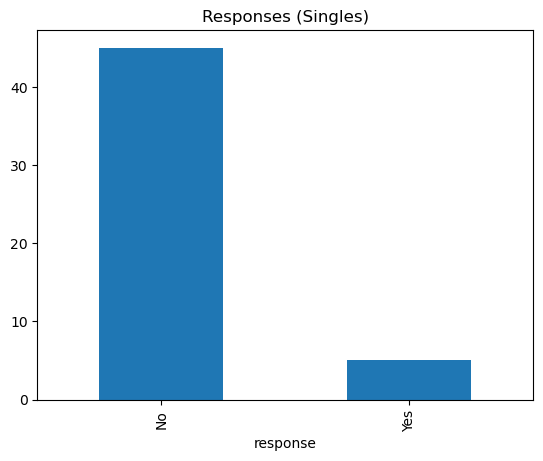

In [27]:
extract_and_analyze_results(singles, "Singles")


################# Analyzing results for Families... #################


Extraction raw result message: {'content': '{"response": "No", "justification": "Clarissa Morales-Hendrix explicitly states she would not use the WanderLux service for a vacation next year because as a single mom with two young children and limited money, she needs affordable and child-friendly trips. The luxury, child-free vacations offered by WanderLux do not fit her current life situation, preferences, or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Calvin Hiroshi Langston Jr. prefers family-friendly vacations with young children and dislikes places that are not child-friendly. The WanderLux service focuses on quiet, adult-only luxury vacations, which does not fit his vacation preferences or current life situation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Clarence Redbird Jr. explicitly states he would not use the WanderLux service because he is unemployed, has limited income and transportation, prefers simple, child-friendly, and low-cost trips close to home, and does not have the need or budget for luxury, adult-only vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jeremiah Lonewolf is unemployed, lives in rural Oklahoma with two young kids, and prefers simple, affordable, child-friendly vacations. The luxury, adult-only beachfront and spa destinations offered by WanderLux do not fit his needs, preferences, or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julian prefers family-friendly vacations that accommodate his young children and does not align with the adult-only luxury vacation service WanderLux offers. He prioritizes destinations safe and engaging for kids, which WanderLux excludes."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julian Everett Takahashi would not use WanderLux for his next vacation because he has two young children and prefers family-friendly destinations with activities suitable for toddlers. WanderLux focuses on quiet, luxury, adult-only getaways, which do not align with his vacation preferences and practical needs for traveling with young children."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Latoya Morningstar Yazzie explicitly states she would not use the WanderLux service because she is unemployed with two young children, needs affordable and kid-friendly vacations, and luxury adult-only vacations do not fit her current needs or financial situation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Isabela Marquez-Lunares stated that she would not use the WanderLux service for her next vacation because as a mom with two young children, she prefers family-friendly vacations that accommodate kids and offer cultural experiences. She explained that a luxury, quiet, adult-only vacation does not fit her current needs, budget, or family lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elena Marquez-Sullivan explicitly stated she would not use the WanderLux service for a vacation next year because as a mother of two young children, she prefers family-friendly vacations that are not too far from home. The luxury, adult-only beachfront and spa vacation offered by WanderLux does not fit her current priorities or budget, and she wants vacations where her children can be included and feel comfortable."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elena Marlowe-Santiago explicitly states that she would not use the WanderLux service because as a mom with young children, she prefers family-friendly vacations that include her children and focus on their comfort and enjoyment. She finds that quiet, adult-only luxury vacations do not fit her current needs or interests, and she values practicality and affordability over luxury and romance services."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Valeria Montoya-Cruz explained that as a mom with young kids and a busy job, her vacations focus on family-friendly places suitable for children. She values spending quality time with her family in safe, kid-friendly environments and does not look for or can easily afford luxury adult-only vacations like those offered by WanderLux."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Douglas Everett Caldwell Jr. prefers family-friendly vacations that accommodate his young children and prioritize safety, convenience, and kid-appropriate activities. A luxury, adult-only vacation service like WanderLux does not align with his current life situation and vacation preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marcia Tallbear-Hendrix explained that given her current situation as a single mother in rural Oklahoma with limited funds and childcare challenges, a luxury or romantic vacation is not what she needs or can afford. She prefers simple, family-friendly trips close to nature or visiting relatives, and quiet luxury and adult-only places do not fit her life right now."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tanya is a single mom with two young kids, living in rural Oklahoma, unemployed and looking for flexible work. She prefers child-friendly, affordable, low-stress trips that include her children, and dislikes crowded, noisy, or expensive vacations. Therefore, a luxury, quiet, adult-only vacation service like WanderLux does not fit her needs, preferences, or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julian Everett Nakamura-Langston prefers family-friendly vacations with cultural enrichment and activities suitable for children. The WanderLux service focuses on quiet, luxury, adult-only vacations, which do not align with his current life situation, preferences, or needs."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elbert Yazzie-Redbird is unemployed with young children and prefers simple, affordable, family-friendly vacations. He explicitly states that luxury, adult-only vacations do not fit his needs or budget and that he would rather take his children to a nearby park or campground. Therefore, he would not use the WanderLux luxury travel service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Mariana Delgado-Ramirez prefers short, affordable, child-friendly trips close to home due to her current situation caring for young grandchildren and limited finances. Luxury, quiet adult-only vacations do not fit her needs or budget, so she would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elliot Harrison Takahashi-Wells explicitly states that he would not use the WanderLux service because it focuses on quiet, adult-only luxury vacations, which do not align with his current family-oriented vacation needs and preferences. He prefers family-friendly destinations with activities suitable for toddlers and values budget and practical considerations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Gordon Ellsworth Caldwell prefers family-friendly vacations with young children and does not align with the adult-only luxury vacation service offered by WanderLux. He values safety, convenience, and activities suitable for children, and is cautious about spending, making the WanderLux service unsuitable for his current priorities."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Frederick Langston Caldwell prefers family-oriented vacations that include his spouse and children, focusing on safe, comfortable, and educational activities. The WanderLux service targets luxury, adult-only, quiet vacations which do not align with his current priorities and travel style. Financial prudence also influences his decision, making him unlikely to choose a luxury service that excludes his family."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Gregory Stanton Whitfield prefers family-oriented vacations that accommodate young children and does not find a luxury, adult-only vacation service like WanderLux suitable for his current life situation and vacation preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tanya Littlefeather-Brown explicitly states she would not use the WanderLux service because as a single mom in rural Oklahoma, she needs vacations that are affordable and child-friendly, preferring short trips where her kids can play outside and learn about their heritage. She also worries about cost and childcare, so the luxury, adult-only vacation service does not fit her current needs or preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elliot Kiyoshi Merriman would not use the WanderLux service for a vacation next year because his current life situation involves young children, and he prioritizes family-friendly destinations with activities suitable for toddlers and accommodations that support family needs. The service\'s focus on quiet, luxury, adult-only vacations does not align with his vacation preferences, which include engaging places for kids, balancing relaxation with family time, and favoring road trips or short flights to minimize travel stress and fit the family budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Calvin Hiroto Whitman prefers family-friendly vacations that accommodate young children and offer activities suitable for toddlers. The WanderLux service focuses on quiet, adult-only luxury vacations, which do not align with his current priorities and vacation goals."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Calvin Hiroshi Langston prefers family-friendly vacations that accommodate children and balance activities for both kids and adults. The WanderLux service focuses on quiet, adult-only luxury vacations, which do not align with his needs and preferences. Additionally, his moderate budget and priority for comfort and convenience over luxury make him unlikely to choose this service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Clarissa Delgado-Morris Jr. explicitly states that she would not use the WanderLux service because her current life situation involves caring for young grandchildren, managing on a tight budget, and preferring family-friendly, affordable trips rather than luxury, adult-only vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Isabela Marisol Vega-Cruz explicitly states that she would not use WanderLux for her vacation next year because the service focuses on adult-only luxury vacations, which do not fit her current needs and interests as a mother who prefers family-friendly trips with her children. She also mentions budget constraints and her preference for vacations where her kids can have fun and be safe."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marisol Vega-Langston explicitly states that she would not use the WanderLux service because her current life situation involves taking care of young grandchildren and managing on a tight budget. She prefers simple, family-friendly, affordable trips and finds that quiet, adult-only luxury vacations do not fit her needs or preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elena Marlowe-Castillo prefers family-friendly vacations with her children and values safety, comfort, and child-friendly amenities. The WanderLux service focuses on adult-only luxury vacations, which do not align with her current needs, interests, or budget. Therefore, she would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Lucia Marquez-Vega explicitly states that she would not use WanderLux for her vacation next year because her life situation with young children and preference for family-friendly, educational, and cultural trips do not align with the quiet luxury adult-only vacations offered by WanderLux. She values vacations that include her children and considers budget and convenience, making WanderLux not the best match for her current needs and values."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Ethan Kaito Morrison would not use WanderLux for his vacation next year because he has young children and prioritizes family-friendly vacations that are safe and engaging for his kids. The WanderLux service focuses on quiet, adult-only luxury vacations, which do not align with his family\'s needs or vacation style. He prefers destinations with activities suitable for toddlers and amenities that accommodate children, such as national parks or theme parks."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tanya is unemployed with two young children and prefers family-friendly, affordable vacations. Luxury, adult-only vacations like those offered by WanderLux do not fit her current needs or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Elijah Crowfeather explicitly states that he would not use the WanderLux service because it does not fit his current life situation, preferences, or budget. He prefers simple, affordable, kid-friendly trips close to home rather than luxury, quiet adult-only vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tanya Redbird-Holloway Jr. explicitly states she would not use the WanderLux service because it focuses on luxury, adult-only vacations that do not fit her current life situation as a single mother with two young children, limited income, and preference for affordable, child-friendly vacations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Gordon Ellsworth Merriman explicitly states that he would not use the WanderLux service because his current life situation with young children leads him to prefer family-friendly vacations. He values educational and nature experiences suitable for his kids and finds that a luxury adult-only vacation does not align with his priorities. Additionally, he is financially prudent and prefers vacations that balance comfort with affordability, often favoring road trips and family-oriented accommodations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Malcolm Yazzie stated that he wouldn\'t use WanderLux because his situation with two young kids and limited income means he looks for simple, affordable trips with his children. He prefers quiet nature spots or visiting family, not luxury or adult-only places, which do not fit his needs or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Dolores Santiago-Morrison explicitly states that she would not use the WanderLux service due to her current life situation of caring for young grandchildren and having limited financial resources. She prefers simple, family-friendly trips that include children, which contrasts with the luxury, quiet, adult-only vacation offered by the service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julian Everett Nakamura would not use WanderLux for his vacation next year because his current family situation with young children leads him to prioritize family-friendly destinations with activities suitable for toddlers. WanderLux\'s focus on quiet, adult-only luxury vacations does not align with his needs or preferences, as he prefers trips that combine relaxation with educational experiences and kid-friendly environments."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Gordon Ellsworth Merriweather would not use the WanderLux service because his current life situation involves having two young children, and he prioritizes family-oriented, child-friendly vacations within the U.S. that offer relaxation and educational opportunities for his children. The luxury, quiet, adult-only vacation offered by WanderLux does not align with his vacation style or priorities."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Jeremiah Tallbear is living in rural South Dakota, unemployed, with two young children. He prefers simple, family-friendly vacations with outdoor activities like fishing and nature walks. Luxury and romantic beachfront vacations with no kids do not fit his needs or budget. He would rather take his children to a nearby lake or state park for a quiet trip. Given his financial constraints and family priorities, he would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marsha is unemployed with two young children and prefers simple, affordable, child-friendly vacations close to home. Luxury, quiet, adult-only vacations do not fit her needs or budget, so she would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Charles Everett Langston has young children and prioritizes family-friendly vacations that accommodate their needs. He prefers safe, calm environments suitable for children and does not find a luxury, adult-only beach and spa vacation service like WanderLux aligned with his vacation preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tanya is unemployed, caring for two young children, and prefers short, child-friendly, affordable trips close to home. She explicitly states that a luxury, adult-only vacation service like WanderLux does not fit her needs or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Isabela Marquez-Cruz prefers family-friendly, culturally enriching, and flexible vacations that accommodate her two young children. She does not favor quiet luxury or adult-only environments, and financial constraints also make her cautious about expensive vacations. Therefore, she would not use the WanderLux service for her vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Tanya Redbird-McClain Jr. explained that as a single mother with two young children, limited income, and living in rural Oklahoma, a luxury, quiet, adult-only vacation service like WanderLux does not fit her needs or preferences. She prefers short, low-cost, family-friendly trips that are safe and accessible for her kids, so she would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marisol Jenkins-Ramirez is unemployed with limited income and childcare responsibilities. She prefers family-oriented, affordable, and child-friendly vacations rather than luxury, adult-only vacations. She dislikes crowded or noisy places and expensive resorts, so the WanderLux service does not align with her lifestyle and preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Douglas Everett Whitman would not use the WanderLux service because it focuses on adult-only luxury vacations that exclude children, which conflicts with his family-oriented travel preferences. He prefers vacations that include his young children in safe, child-friendly environments and balances relaxation with educational and outdoor activities. Additionally, he is cautious about spending and looks for moderate budgets, making the luxury adult-only service unsuitable for his needs."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Dolores Marquez-Brown explicitly states that she would not use the WanderLux service due to her current situation caring for young grandchildren, limited finances, and preference for affordable, family-friendly vacations rather than luxury or romantic vacations without children."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Gordon Ellsworth Whitman has young children and prioritizes family-friendly vacations that accommodate toddlers. He prefers safe, comfortable places with activities suitable for young kids rather than quiet, adult-only luxury getaways. Financial prudence also leads him to choose practical, child-oriented vacations over luxury adult-only experiences, so he would not use the WanderLux service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Caleb Hiroshi Whitman Jr. clearly states that he would not use WanderLux for his vacation next year because the service focuses on quiet, luxury, adult-only vacations which do not align with his current life situation and vacation preferences as a father of young children who prioritizes family-friendly destinations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
   response                                      justification
0        No  Clarissa Morales-Hendrix explicitly states she...
1        No  Calvin Hiroshi Langston Jr. prefers family-fri...
2        No  Clarence Redbird Jr. explicitly states he woul...
3        No  Jeremiah Lonewolf is unemployed, lives in rura...
4        No  Julian prefers family-friendly vacations that ...
5        No  Julian Everett Takahashi would not use WanderL...
6        No  Latoya Morningstar Yazzie explicitly states sh...
7        No  Isabela Marquez-Lunare

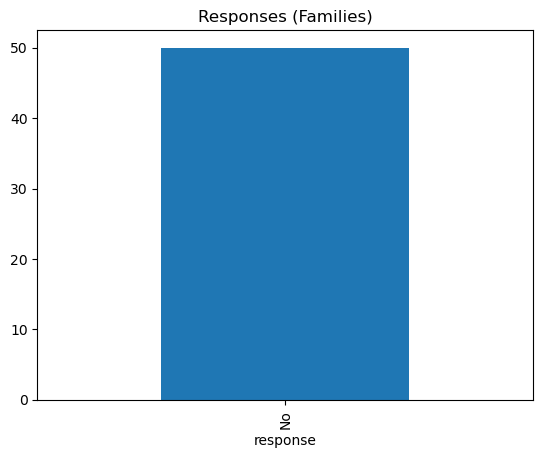

In [28]:
extract_and_analyze_results(families, "Families")

################# Analyzing results for Couples... #################


Extraction raw result message: {'content': '{"response": "No", "justification": "Kiran prefers vacations that combine active exploration and cultural immersion rather than purely quiet luxury beach resorts. Budget constraints and a preference for sustainable and meaningful travel experiences also influence the decision, making it unlikely they would use the WanderLux service for their vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Eleanor Winthrop-Merriman stated that she would likely use the WanderLux service for her vacation next year because its focus on quiet, luxurious, and romantic beachfront and spa destinations aligns well with her preference for calm and refined travel experiences. She appreciates avoiding noisy environments and crowds, which the service promises, and considers it a suitable match for her current lifestyle and interests."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Cameron Elise Fairchild-Blythe explicitly states that she would likely use WanderLux for her vacation next year, appreciating the quiet, luxurious beach and spa getaway as a perfect way to relax and recharge. She values calm environments and wellness activities, which align well with the service offered, and also appreciates avoiding fake reviews and bad experiences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Marisol prefers cultural and nature-focused vacations with her partner, usually by car, avoiding crowded or commercialized places. Although the quiet and calm aspect of the WanderLux service is appealing, she feels luxury beachfront spa vacations do not fully match her interests or budget, and she prefers more authentic, culturally rich experiences and road trips over luxury spa resorts."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "The person explicitly states they would not use WanderLux for their vacation next year. They appreciate quiet and calm getaways but prefer authentic, nature-oriented experiences like road trips, exploring national parks, and cultural sites rather than luxury beachfront resorts. Their travel style and budget constraints do not align well with the luxury spa vacation service offered by WanderLux."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Emilio Santiago-Caldwell is a 13-year-old student who prefers adventure, nature, and spending time with family or friends on vacations. He does not find quiet luxury vacations without kids appealing, and such trips might be too expensive or unsuitable for his family situation. Therefore, he would not use the WanderLux service for his vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Rivka Tova Greenfield would not use the WanderLux service because her ideal vacations involve cultural immersion and exploring historical sites rather than luxury beachfront or spa experiences. She values meaningful travel connected to local traditions and history, prefers boutique hotels or B&Bs, and considers affordability and authenticity important, which may not align with the service\'s focus."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Isandro prefers vacations that combine adventure, cultural experiences, and nature rather than luxury or overly quiet, formal experiences. He explicitly states that luxury beachfront and spa spots do not fit his style or budget, and he values meaningful, affordable travel connected to culture and nature. Therefore, he would not use the WanderLux service for his vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Marisol Vega-Redbird explicitly states she would use the WanderLux service for a vacation next year, appreciating its focus on quiet, calm, and classy environments without kids, which aligns with her preference for peaceful getaways with her partner. She also values the trusted service aspect to avoid fake reviews and bad experiences, making planning less stressful."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Santiago Moreno-Hawthorne is a 13-year-old middle school student who prefers active and fun vacations with family or friends, such as trips to national parks or beaches for hiking, swimming, and playing basketball. The WanderLux service focuses on luxury, quiet vacations for adults, which does not match his preferences or situation. Additionally, as a kid, he lacks the budget and independence for luxury vacations, so he clearly states he would not use the service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Mariana Solis-Ramsey stated she probably wouldn\'t use WanderLux for her next vacation because she prefers trips involving cultural immersion, nature, and road trips with her partner. She finds beachfront luxury and spa vacations do not match her interests or budget and tends to avoid overly commercialized or impersonal travel experiences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Eleanor Grace Whitfield explicitly states she would not use the WanderLux service because her vacation preferences focus on connecting with nature, exploring rural areas, and engaging with local cultures rather than luxury beachfront or spa experiences. She prefers eco-friendly travel options and meaningful outdoor activities over luxury amenities, which the service offers."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "N/A", "justification": "The agent did not provide a direct answer of Yes, No, or Maybe regarding whether they would use the WanderLux service for a vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Eleanor Grace Whitmore expressed that she would likely use the WanderLux service for a vacation next year because it aligns with her preference for quiet, elegant, and culturally rich experiences. She values peaceful getaways without noisy crowds, which fits the service\'s focus on luxury beachfront and spa destinations for a calm and classy vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Santiago Moreno-Fairchild is 12 years old and prefers fun, active vacations with family and friends, such as going to museums and parks. The WanderLux service is designed for adults seeking quiet, luxury vacations without kids, which does not fit Santiago\'s preferences or situation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Eleanor values quiet and calm vacations focused on nature and cultural exploration rather than luxury beachfront or spa experiences. She prefers meaningful, restorative trips aligned with her interests in sustainability and avoids overly commercialized or flashy destinations. Therefore, she does not think the WanderLux service would be the best fit for her."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Morgan Elise Fairchild-Blythe explicitly states that she would use WanderLux for her vacation next year because the service\'s focus on quiet, calm, and classy beachfront and spa destinations aligns well with her preference for peaceful getaways without noisy crowds or children. She values relaxation and luxury to manage work stress and appreciates avoiding fake reviews and bad experiences, making the service a good fit for her."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Mariana Estela Redbird-Morales would not use the WanderLux service for her vacation next year because, although she appreciates quiet and calm getaways, her ideal vacations involve a balance of relaxation with cultural experiences and light adventure. She prefers meaningful and affordable trips over purely luxury-focused ones, and the service does not align with her travel style and budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Janelle prefers travel that combines cultural tours, culinary experiences, and outdoor activities rather than purely quiet luxury getaways. She values cultural immersion and sustainable tourism and likes some adventure and exploration, which suggests that the quiet luxury vacation offered by WanderLux does not align well with her interests and lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Julian Mateo Calderón-Winters is 13 years old, prefers vacations with adventure, family, and exploration rather than quiet luxury or romantic getaways. The adult focus and likely cost of WanderLux do not fit his situation or preferences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Avery Simone Langston-Brooks explicitly states multiple times that she would use WanderLux for her next vacation. She values quiet, classy, and well-organized trips that balance relaxation with cultural immersion, which aligns well with the service\'s focus on luxury, romantic, and quiet beachfront or spa destinations without kids. She appreciates the avoidance of fake reviews and bad experiences and sees the service as fitting her current lifestyle and vacation goals nicely."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "N/A", "justification": "The agent did not provide a direct answer of Yes, No, or Maybe regarding whether they would buy the product or service."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Evelyn prefers modest, nature-focused trips over luxury beachfront or spa vacations. She likes traveling by car on scenic routes rather than flying or staying in fancy resorts, so the WanderLux service does not fit her preferences or lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Vivian Marcellus Kensington explicitly states that she would use the WanderLux service for her vacation next year. She values quiet, classy beach vacations with wellness amenities and wants to avoid noisy or chaotic environments. The service aligns well with her preferences, focusing on authentic experiences and avoiding fake reviews, which is important to her. She also mentions that a luxury beachfront spa vacation would be an ideal way to relax and recharge with her partner."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Clinton Everett Hargrove prefers vacations focused on outdoor adventure and cultural experiences rather than luxury beachfront and spa vacations. He values nature-focused, culturally rich, and more rustic vacations that align with his lifestyle and values as a farm manager. Additionally, cost and travel preferences such as a mild fear of flying and favoring road trips influence his decision. Therefore, he would not use the WanderLux service for his next vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Dorian Keaton Langston-Morrison Jr. stated that he probably wouldn\'t use the WanderLux service because his ideal trips usually mix cultural exploration and some activity, not just luxury beachfront and spa relaxation. He also prefers authentic experiences and boutique stays over purely luxury-focused ones, so the service might not fully match what he\'s looking for in a vacation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Vivian states that she would likely use WanderLux for her vacation next year because it aligns with her preference for quiet, authentic, and well-curated experiences. She appreciates avoiding chaotic environments and fake reviews, and values a trusted source for luxury and calm vacations, which fits the service description."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Derek prefers vacations that blend cultural immersion with active experiences and some relaxation, rather than purely quiet luxury. He is cautious with finances and wants meaningful, enriching experiences, which he feels WanderLux\'s focus on quiet luxury does not fully align with."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "No", "justification": "Person_66_Male prefers practical, nature-oriented vacations such as road trips, fishing, and national parks over luxury beachfront or spa experiences. He is cautious about spending and feels that the WanderLux service does not fit his style or budget."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "Yes", "justification": "Cameron Elise Fairchild prefers quiet, classy getaways without the chaos of families with kids, values relaxation and wellness, and appreciates the promise of avoiding fake reviews and bad experiences. The WanderLux service aligns well with these preferences, making it a great fit for their vacation next year."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
   response                                      justification
0        No  Kiran prefers vacations that combine active ex...
1       Yes  Eleanor Winthrop-Merriman stated that she woul...
2       Yes  Cameron Elise Fairchild-Blythe explicitly stat...
3        No  Marisol prefers cultural and nature-focused va...
4        No  The person explicitly states they would not us...
5        No  Emilio Santiago-Caldwell is a 13-year-old stud...
6        No  Rivka Tova Greenfield would not use the Wander...
7        No  Isandro prefers vacations th

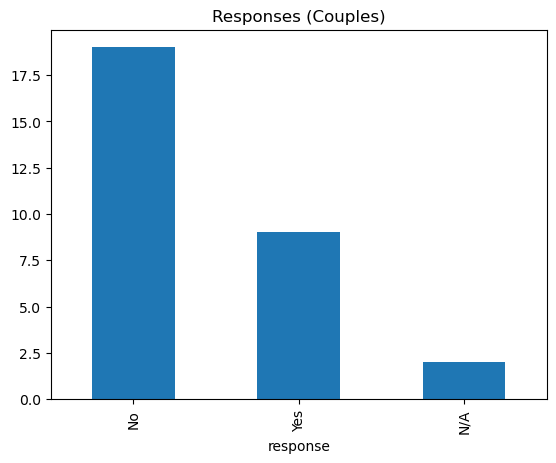

In [29]:
extract_and_analyze_results(couple, "Couples")

In [30]:
control.end()